In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

## DIOPS - Receita e Despesa

In [4]:
#Caminho da pasta com as bases de dados 
path = r'D:\TCC\TCC\diops'

#Leitura das Bases de Dados
text_files = [f for f in os.listdir(path) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

diops = pd.concat([pd.read_csv(path+'\\'+f, sep=';',usecols=['DATA','REG_ANS','CD_CONTA_CONTABIL','VL_SALDO_FINAL'], decimal= ',', encoding='mbcs') for f in text_files]) #Leitura e concatenação de todas as bases

diops['CD_CONTA_CONTABIL'] = diops['CD_CONTA_CONTABIL'].apply(str) #Converte o campo 'CD_CONTA_CONTABIL' em tipo string

diops = diops[diops['CD_CONTA_CONTABIL'].apply(lambda x: len(str(x))==9)] #Seleciona somente os registro com strings com 9 digitos no campo 'CD_CONTA_CONTABIL'

diops = diops[diops['VL_SALDO_FINAL'] != 0] #Exclui todos os registros iguais a '0' no campo 'VL_SALDO_FINAL'

diops['DATA'] = pd.to_datetime(diops['DATA'], dayfirst=True) #Converte o campo 'DATA' em tipo datetime

diops['DATA'] = diops['DATA'] + pd.DateOffset(months=2) #Modifica o mês no campo 'DATA', alterando todos para o último mês do periodo do trimestre analisado

diops.columns = ['id_calendar', 'cd_ops', 'cd_conta_contabil', 'vl_saldo_final'] #Mudando os nomes das colunas no dataframe

diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'vl_saldo_final']] #Reordenando as colunas do dataframe

diops['cd_ops'] = diops['cd_ops'].apply(str)

diops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2987177 entries, 0 to 907072
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   cd_ops             object        
 1   cd_conta_contabil  object        
 2   id_calendar        datetime64[ns]
 3   vl_saldo_final     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 114.0+ MB


In [5]:
# filtra contas contábeis relevantes para a análise
diops  = diops.loc[(diops['cd_conta_contabil'].str.startswith('411') & diops['cd_conta_contabil'].str[4].str.contains('1')) | # despesa / corresponsabilidade assumida médico-hospitalar
                    diops['cd_conta_contabil'].str.startswith('31111') | diops['cd_conta_contabil'].str.startswith('31171')]  # receita / corresponsabilidade cedida médico-hospitalar

diops.reset_index(drop=True, inplace=True) #Reindexando o dataframe

#Criando campo 'gr-cc'
diops.loc[diops['cd_conta_contabil'].str.startswith('4'),'gr_cc'] = 'eventos'
diops.loc[diops['cd_conta_contabil'].str.startswith('31111'),'gr_cc'] = 'receita' 
diops.loc[diops['cd_conta_contabil'].str.startswith('31171'),'gr_cc'] = 'corr_cedida'

diops = diops.groupby(['cd_ops', 'cd_conta_contabil', 'id_calendar', 'gr_cc'], as_index=False)['vl_saldo_final'].agg('sum') #Somando os valores do campo 'vl_saldo_final' pelo agrupamento das demais variaveis

diops = diops.pivot_table(values='vl_saldo_final', index=['cd_ops', 'cd_conta_contabil', 'id_calendar'], columns='gr_cc').fillna(0)

diops = pd.DataFrame(diops.to_records()) #Convertendo a tabela pivotada para um objeto tipo dataframe

diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'receita', 'eventos', 'corr_cedida']] #Reordenando as colunas

#Criação do campo 'vigencia' pela condição do codigo da conta contabil
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'vigencia'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|3|5'),'vigencia'] = 'A'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('2|4|6'),'vigencia'] = 'P'

#Criação do campo 'contratacao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'contratacao'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|2'),'contratacao'] = 'Individual'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('3|4'),'contratacao'] = 'Adesao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('5|6'),'contratacao'] = 'Empresarial'

#Criação do campo 'financiamento'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'financiamento'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('1'),'financiamento'] = 'Pre-estabelecido'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('2'),'financiamento'] = 'Pos-estabelecido'

diops = diops.drop(diops[diops.vigencia == 'corr_assumida'].index) # exclui corr assumida no campo 'vigencia'

# Cálculo do campo 'despesa'
#diops['despesa'] = diops.apply(lambda x: x['eventos'] - x['corr_cedida'], ax1is = 1)

diops['despesa'] = diops['eventos'] - diops['corr_cedida']

diops['ano'] = diops['id_calendar'].dt.to_period('Y')

diops['trimestre'] = diops['id_calendar'].dt.to_period('Q')

#diops['quarter'] = diops['id_calendar'].dt.quarter

diops = diops.groupby(['cd_ops', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], as_index=False).agg({'receita':'sum','despesa':'sum'})

diops.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '01-diops_trimestral_acumulada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops['receita'] = diops['receita'].abs()

diops['despesa'] = diops['despesa'].abs()

diops


cd_ops vigencia contratacao     financiamento id_calendar   ano trimestre     receita      despesa
0         27        A  Individual  Pre-estabelecido  2017-09-01  2017    2017Q3   12981.240        0.000
1         27        A  Individual  Pre-estabelecido  2017-12-01  2017    2017Q4   17821.560        0.000
2         27        A  Individual  Pre-estabelecido  2018-03-01  2018    2018Q1    4465.750        0.000
3         27        A  Individual  Pre-estabelecido  2018-06-01  2018    2018Q2    8761.930        0.000
4         27        A  Individual  Pre-estabelecido  2018-09-01  2018    2018Q3   13136.900        0.000
...      ...      ...         ...               ...         ...   ...       ...         ...          ...
60307    884        P  Individual  Pre-estabelecido  2021-03-01  2021    2021Q1  489740.570  6408902.090
60308    884        P  Individual  Pre-estabelecido  2021-06-01  2021    2021Q2 1002331.270 14237176.570
60309    884        P  Individual  Pre-estabelecido  2021-09-01  2021    2021Q3 1497760.340 22156839.620
60310    884        P  Individual  Pre-estabelecido  2021-12-01  2021    2021Q4 1970643.810 29519977.060
60311    884        P  Individual  Pre-estabelecido  2022-03-01  2022    2022Q1  459471.780  7558650.640

[60312 rows x 9 columns]

In [6]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_trimestral_ops = diops.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                                                                    'cd_ops':lambda x: x.nunique()})

diops_trimestral_ops['pct_despesa'] = diops_trimestral_ops.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_ops.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_ops = diops_trimestral_ops[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_ops = diops_trimestral_ops[(diops_trimestral_ops['trimestre'] >= '2018Q1')&(diops_trimestral_ops['trimestre'] < '2022Q1')]

diops_trimestral_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '02-diops_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      45.810   35.970    700       78.520
2018Q2      95.320   77.120    708       80.910
2018Q3     145.270  118.640    709       81.670
2018Q4     205.140  168.460    707       82.120
2019Q1      50.580   40.210    688       79.500
2019Q2     100.300   82.450    686       82.200
2019Q3     156.190  129.620    686       82.990
2019Q4     209.760  172.850    688       82.400
2020Q1      54.590   42.430    673       77.720
2020Q2     108.940   77.110    673       70.780
2020Q3     163.650  118.170    660       72.210
2020Q4     220.540  164.300    672       74.500
2021Q1      57.870   45.800    661       79.140
2021Q2     115.000   94.540    671       82.210
2021Q3     173.950  145.890    669       83.870
2021Q4     239.820  202.900    672       84.610

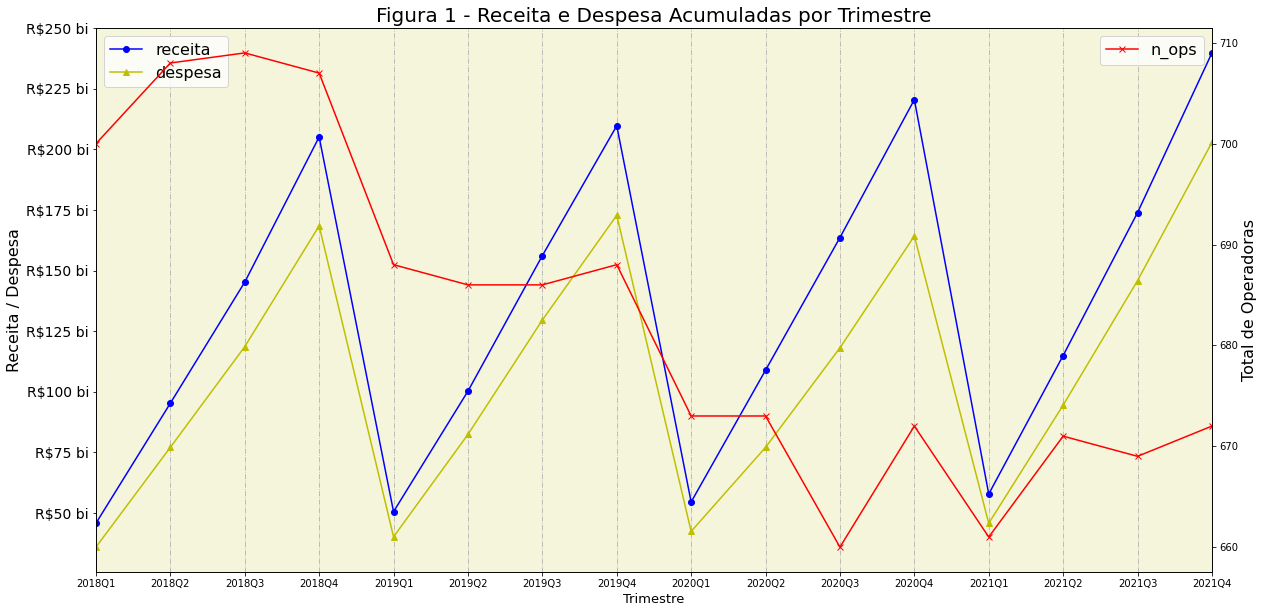

In [7]:
from matplotlib.pyplot import xticks

fig,ax1 = plt.subplots()

diops_trimestral_ops.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre',fontsize = 20)
ax1.set_xticks(diops_trimestral_ops.index)
ax1.set_xticklabels(diops_trimestral_ops.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_trimestral_ops.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_ops.index)
ax2.set_xticklabels(diops_trimestral_ops.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

# SIB

In [8]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '03-sib.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib

cd_ops         modalidade vigencia  contratacao     financiamento id_calendar   ano trimestre  benef
146900      27  Médico-hospitalar        A   Individual  Não identificado  2017-09-01  2017    2017Q3      4
228965      27  Médico-hospitalar        A   Individual  Não identificado  2017-10-01  2017    2017Q4      4
332456      27  Médico-hospitalar        A   Individual  Não identificado  2017-11-01  2017    2017Q4      4
332180      27  Médico-hospitalar        A   Individual  Não identificado  2017-12-01  2017    2017Q4      4
33924       27  Médico-hospitalar        A   Individual  Não identificado  2018-01-01  2018    2018Q1      4
...        ...                ...      ...          ...               ...         ...   ...       ...    ...
390516  422975       Odontológico        P       Adesao  Pre-estabelecido  2022-03-01  2022    2022Q1    137
137641  422975       Odontológico        P  Empresarial  Pre-estabelecido  2022-01-01  2022    2022Q1     92
250037  422975       Odontológico        P  Empresarial  Pre-estabelecido  2022-02-01  2022    2022Q1     99
29707   422975       Odontológico        P  Empresarial  Pre-estabelecido  2022-03-01  2022    2022Q1    115
94145   422975       Odontológico        P   Individual  Pre-estabelecido  2022-03-01  2022    2022Q1      2

[242393 rows x 9 columns]

In [9]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

cd_ops   benef port_ops
0     477  115244   Grande
1     515   33402    Médio
2     582  990798   Grande
3     701  614431   Grande
4     884    8336  Pequeno

In [10]:
sib_media_agregada = sib.groupby(['ano', 'trimestre'],  as_index=False).agg({'benef':lambda x: round(sum(x)/3,0),
                                                                             'cd_ops':lambda x: x.nunique()})

sib_media_agregada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '04-sib_media_agregada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_media_agregada

ano trimestre        benef  cd_ops
0   2017    2017Q3 23087643.000    1075
1   2017    2017Q4 69417614.000    1073
2   2018    2018Q1 69491979.000    1064
3   2018    2018Q2 70069275.000    1061
4   2018    2018Q3 70793574.000    1055
5   2018    2018Q4 71284403.000    1050
6   2019    2019Q1 71274410.000    1032
7   2019    2019Q2 71378857.000    1020
8   2019    2019Q3 71780017.000    1015
9   2019    2019Q4 72539561.000    1009
10  2020    2020Q1 72881891.000    1010
11  2020    2020Q2 72107257.000     994
12  2020    2020Q3 72432777.000     989
13  2020    2020Q4 73690711.000     978
14  2021    2021Q1 74550853.000     967
15  2021    2021Q2 75363274.000     965
16  2021    2021Q3 76520512.000     966
17  2021    2021Q4 77581744.000     958
18  2022    2022Q1 78183768.000     949

In [11]:
#Filtra segmentos alvo da análise e totaliza por mês, operadora e tipo de plano.

filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['vigencia'].isin(['P'])
filtro3 = sib['financiamento'] != 'Pós-estabelecido'
filtro4 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3 & filtro4 ]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops', 'contratacao', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '05-sib_filtrada.csv', sep=';', encoding='mbcs', decimal=',')

sib_filtrada

ano  cd_ops  contratacao id_calendar trimestre  benef
0      2017      27       Adesao  2017-09-01    2017Q3  11173
1      2017      27       Adesao  2017-10-01    2017Q4  10909
2      2017      27       Adesao  2017-11-01    2017Q4  10754
3      2017      27       Adesao  2017-12-01    2017Q4  10584
4      2017      27  Empresarial  2017-09-01    2017Q3  17237
...     ...     ...          ...         ...       ...    ...
90032  2022  422827  Empresarial  2022-02-01    2022Q1     98
90033  2022  422827  Empresarial  2022-03-01    2022Q1    188
90034  2022  422835  Empresarial  2022-01-01    2022Q1      3
90035  2022  422835  Empresarial  2022-02-01    2022Q1      7
90036  2022  422835  Empresarial  2022-03-01    2022Q1     14

[90037 rows x 6 columns]

In [12]:
sib_filtrada_analise = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benef':lambda x: round(sum(x)/3,0),
                                                                                                        'cd_ops':lambda x: x.nunique()})

sib_filtrada_analise = pd.DataFrame(sib_filtrada_analise.pivot_table(index='trimestre', columns='contratacao', values=['benef','cd_ops']).to_records())

sib_filtrada_analise.columns = ['trimestre','benef.Adesao','benef.Empresarial','benef.Individual','n_ops.Adesao','n_ops.Empresarial','n_ops.Individual']

sib_filtrada_analise = sib_filtrada_analise[(sib_filtrada_analise.trimestre >= '2018Q1') & (sib_filtrada_analise.trimestre < '2022Q1')]

sib_filtrada_analise.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '16-sib_analise_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise.set_index('trimestre', inplace=True)

sib_filtrada_analise

benef.Adesao  benef.Empresarial  benef.Individual  n_ops.Adesao  n_ops.Empresarial  n_ops.Individual
trimestre                                                                                                      
2018Q1      4620328.000       26480498.000       8079433.000           532                636               547
2018Q2      4640851.000       26595191.000       8063981.000           535                630               542
2018Q3      4627192.000       26625322.000       8047408.000           531                630               541
2018Q4      4636134.000       26726328.000       8056454.000           530                627               537
2019Q1      4635217.000       26697425.000       8013962.000           524                615               525
2019Q2      4661787.000       26764243.000       8010452.000           521                609               519
2019Q3      4661235.000       26810821.000       8015401.000           516                603               521
2019Q4      4684491.000       26935935.000       8026914.000           518                600               517
2020Q1      4697040.000       26997049.000       8008429.000           517                602               518
2020Q2      4721254.000       26816055.000       7962939.000           513                594               511
2020Q3      4740247.000       26834019.000       8008151.000           511                595               514
2020Q4      4808323.000       27117341.000       8061367.000           507                592               512
2021Q1      4800893.000       27458223.000       8068045.000           505                584               508
2021Q2      4821943.000       27865313.000       8026948.000           503                584               508
2021Q3      4856359.000       28278132.000       7992506.000           506                584               505
2021Q4      4893064.000       28685964.000       7989680.000           506                586               503

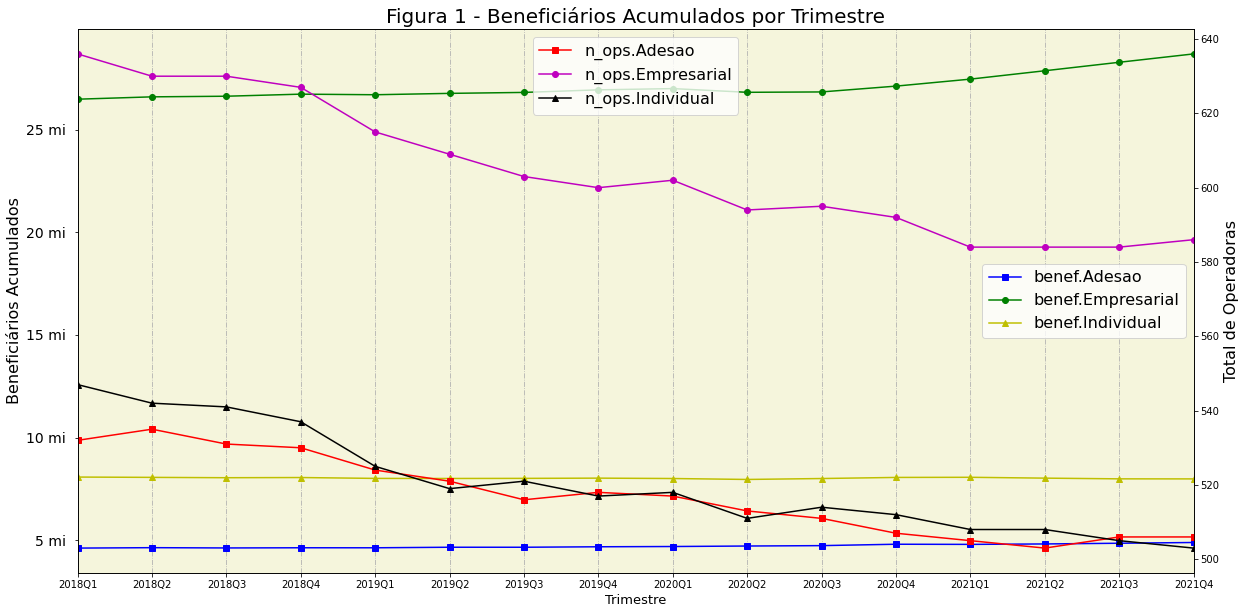

In [13]:
df_plot = sib_filtrada_analise.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['benef.Adesao','benef.Empresarial','benef.Individual'], figsize=(20,10), style=['bs-','go-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Beneficiários Acumulados por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['{:.0f} mi '.format(x/1e6) for x in yticks], fontsize = 14)
ax1.set_ylabel('Beneficiários Acumulados', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops.Adesao','n_ops.Empresarial','n_ops.Individual'], figsize=(20,10), style=['rs-','mo-','k^-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [14]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['cd_ops', 'contratacao', 'id_calendar', 'benef', 'ano', 'trimestre', 'benefm', 'n_meses', 'mes']]

sib_filtrada

cd_ops  contratacao id_calendar  benef   ano trimestre    benefm  n_meses  mes
0          27       Adesao  2017-09-01  11173  2017    2017Q3 11173.000        1    9
1          27       Adesao  2017-10-01  10909  2017    2017Q4 10909.000        3   10
2          27       Adesao  2017-11-01  10754  2017    2017Q4 10831.500        3   11
3          27       Adesao  2017-12-01  10584  2017    2017Q4 10749.000        3   12
6887       27       Adesao  2018-01-01  10576  2018    2018Q1 10576.000        3    1
...       ...          ...         ...    ...   ...       ...       ...      ...  ...
90032  422827  Empresarial  2022-02-01     98  2022    2022Q1    98.000        2    2
90033  422827  Empresarial  2022-03-01    188  2022    2022Q1   143.000        2    3
90034  422835  Empresarial  2022-01-01      3  2022    2022Q1     3.000        3    1
90035  422835  Empresarial  2022-02-01      7  2022    2022Q1     5.000        3    2
90036  422835  Empresarial  2022-03-01     14  2022    2022Q1     8.000        3    3

[90037 rows x 9 columns]

In [15]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes'], axis='columns', inplace=True)

#Base SIB com numero de beneficiarios
#sib_filtrada_temp = sib_filtrada.copy()

sib_filtrada.drop(['benef'], axis='columns', inplace=True)

sib_filtrada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '13-sib3.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise_2 = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benefm':lambda x: round(sum(x),0),
                                                                                                          'cd_ops':lambda x: x.nunique()})

sib_filtrada_analise_2.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '17-sib_analise2_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

#sib_filtrada_analise_2

In [16]:
#################################################################################################################################
#OPERADORAS
################################################################################################################################

path_operadoras = r'D:\TCC\TCC\Cadop'

text_files_operadoras = [f for f in os.listdir(path_operadoras) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

cadop = pd.concat([pd.read_csv(path_operadoras+'\\'+f, sep=';', encoding="ANSI") for f in text_files_operadoras]) #Leitura e concatenação de todas as bases

#cadop = cadop[['Registro_ANS', 'Razao_Social', 'Modalidade', 'Data_Registro_ANS', 'Data_Descredenciamento']]

cadop = cadop[['CD_OPERADO', 'RAZAO_SOCIAL', 'MODALIDADE', 'DATA_REGISTRO_ANS', 'DATA_DESCREDENCIAMENTO']]

cadop.columns = ['cd_ops', 'razao_social', 'modalidade', 'dt_registro', 'dt_cancelamento']

cadop['dt_registro'] = pd.to_datetime(cadop['dt_registro'], dayfirst=True)

cadop['dt_cancelamento'] = pd.to_datetime(cadop['dt_cancelamento'], dayfirst=True)

cadop = pd.merge(cadop, ops, on='cd_ops', how='left')

cadop.drop(['benef'], axis='columns', inplace=True)

cadop['port_ops'] = cadop['port_ops'].fillna('Pequeno')

cadop['modalidade'] = cadop['modalidade'].str.replace('Seguradora Especializada em Saúde','Seguradora')

cadop = cadop.loc[cadop['modalidade'].isin(['Autogestão', 'Cooperativa Médica', 'Filantropia', 'Medicina de Grupo', 'Seguradora'])]

cadop['ano - dt_cancelamento'] = cadop['dt_cancelamento'].dt.year

cadop['ano - dt_registro'] = cadop['dt_registro'].dt.year

cadop['lg_cancelada'] = np.select([cadop['ano - dt_cancelamento'] <= 2021, (cadop['ano - dt_cancelamento'] != "NaN")],[1,0]) # Filtro de fim da Operação

cadop['lg_nova_ops'] = np.where(cadop['ano - dt_registro'] >= 2018, 1, 0) # Filtro de inicio da Operação

cadop = cadop[['cd_ops', 'razao_social', 'modalidade', 'port_ops', 'lg_cancelada', 'lg_nova_ops']]

cadop.to_csv(f'D:/TCC/TCC/codigos/preparacao_dados' + '\\' + '18-cadop.csv', sep=';', index=False, encoding='mbcs', decimal=',')

cadop

cd_ops                                                                      razao_social         modalidade port_ops  lg_cancelada  lg_nova_ops
0     418374              CAIXA DE ASSISTÊNCIA DO SETOR DE ENERGIA -EVIDA -ASSISTÊNCIA À SAÚDE         Autogestão  Pequeno             0            0
3     421421                                                    2CARE OPERADORA DE SAÚDE LTDA.  Medicina de Grupo    Médio             0            1
5     406708                                      A.P.S ASSISTÊNCIA PERSONALIZADA À SAÚDE LTDA  Medicina de Grupo  Pequeno             0            0
9     314668  ABERTTA SAÚDE - ASSOCIAÇÃO BENEFICENTE DOS EMPREGADOS DA ARCELORMITTAL NO BRASIL         Autogestão    Médio             0            0
16    419168                                      ADPART M2 ADMINISTRAÇÃO E PARTICIPAÇÕES LTDA  Medicina de Grupo  Pequeno             0            0
...      ...                                                                               ...                ...      ...           ...          ...
4022  345628                                                  WMS SUPERMERCADOS DO BRASIL LTDA         Autogestão  Pequeno             1            0
4023  320633                                              WOLF EQUIPAMENTOS DE PERFURAÇÃO LTDA         Autogestão  Pequeno             1            0
4025  327492                                        WORLD MED CARD SISTEMAS E LANÇAMENTOS LTDA  Medicina de Grupo  Pequeno             1            0
4026  339750                WS OPERADORA DE PLANOS DE SAÚDE LTDA - EM LIQUIDAÇÃO EXTRAJUDICIAL  Medicina de Grupo  Pequeno             1            0
4027  409677                                     WSC ASSISTENCIA MEDICA ESPECIALIZADA S/C LTDA  Medicina de Grupo  Pequeno             1            0

[2599 rows x 6 columns]

In [17]:
cadop_analise = cadop.agg(  n_ops=('cd_ops', lambda x: x.nunique()),
                            n_canceladas = ('lg_cancelada','sum'),
                            n_novas_ops = ('lg_nova_ops', 'sum'))

cadop_analise.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '19-cadop_analise.csv', sep=';', index=False, encoding='mbcs', decimal=',')

cadop_analise

cd_ops  lg_cancelada  lg_nova_ops
n_ops        2599.000           NaN          NaN
n_canceladas      NaN      1872.000          NaN
n_novas_ops       NaN           NaN       65.000

# DIOPS - TCC - Receita e Despesa desacumulados

In [18]:

############################################################################################################################################################################################
#                                                                                           DIOPS TCC
############################################################################################################################################################################################

#Cópia da base diops acumulada
diops_temp = diops.copy()

diops_temp['ref1'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str))

diops_temp['ref2'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str) + 
                        diops_temp['trimestre'].map(str))

#Cálculo das diferenças dos valores acumulados
diops_receita_temp = diops_temp[['ref1', 'ref2', 'receita']]

diops_receita_temp =  diops_receita_temp.set_index(['ref1', 'ref2']).sort_index()[['receita']]
diops_receita_temp['dif_receita'] = np.nan
idx = pd.IndexSlice

for ix in diops_receita_temp.index.levels[0]:
    diops_receita_temp.loc[ idx[ix,:], 'dif_receita'] = diops_receita_temp.loc[idx[ix,:],'receita'].diff()
    
diops_despesa_temp = diops_temp[['ref1', 'ref2', 'despesa']]

diops_despesa_temp =  diops_despesa_temp.set_index(['ref1', 'ref2']).sort_index()[['despesa']]
diops_despesa_temp['dif_despesa'] = np.nan
idx = pd.IndexSlice

for ix in diops_despesa_temp.index.levels[0]:
    diops_despesa_temp.loc[ idx[ix,:], 'dif_despesa'] = diops_despesa_temp.loc[idx[ix,:],'despesa'].diff()

diops_temp1 =  pd.merge(diops_temp, diops_receita_temp, on='ref2', how='left')

diops_temp2 =  pd.merge(diops_temp1, diops_despesa_temp, on='ref2', how='left')

diops_tcc = diops_temp2.drop(columns = ['ref1','ref2', 'receita_y', 'despesa_y'])

diops_tcc.dif_receita.fillna(diops_tcc.receita_x, inplace=True)

diops_tcc.dif_despesa.fillna(diops_tcc.despesa_x, inplace=True)

diops_tcc = diops_tcc.drop(columns = ['receita_x', 'despesa_x'])

diops_tcc.rename(columns = {'dif_receita':'receita', 'dif_despesa':'despesa'}, inplace = True)

del diops_temp, diops_receita_temp, diops_despesa_temp, diops_temp1, diops_temp2

#print('diops_tcc')
#print(diops_tcc)

diops_tcc.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '04-diops_trimestral_tcc.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc['receita'] = diops_tcc['receita'].abs()

diops_tcc['despesa'] = diops_tcc['despesa'].abs()

diops_tcc

cd_ops vigencia contratacao     financiamento id_calendar   ano trimestre    receita     despesa
0         27        A  Individual  Pre-estabelecido  2017-09-01  2017    2017Q3  12981.240       0.000
1         27        A  Individual  Pre-estabelecido  2017-12-01  2017    2017Q4   4840.320       0.000
2         27        A  Individual  Pre-estabelecido  2018-03-01  2018    2018Q1   4465.750       0.000
3         27        A  Individual  Pre-estabelecido  2018-06-01  2018    2018Q2   4296.180       0.000
4         27        A  Individual  Pre-estabelecido  2018-09-01  2018    2018Q3   4374.970       0.000
...      ...      ...         ...               ...         ...   ...       ...        ...         ...
60307    884        P  Individual  Pre-estabelecido  2021-03-01  2021    2021Q1 489740.570 6408902.090
60308    884        P  Individual  Pre-estabelecido  2021-06-01  2021    2021Q2 512590.700 7828274.480
60309    884        P  Individual  Pre-estabelecido  2021-09-01  2021    2021Q3 495429.070 7919663.050
60310    884        P  Individual  Pre-estabelecido  2021-12-01  2021    2021Q4 472883.470 7363137.440
60311    884        P  Individual  Pre-estabelecido  2022-03-01  2022    2022Q1 459471.780 7558650.640

[60312 rows x 9 columns]

In [19]:
diops_tcc_analise = diops_tcc.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                'despesa':lambda x: sum_billion(x),
                                                                                'cd_ops':lambda x: x.nunique()})

diops_tcc_analise['pct_despesa'] = diops_tcc_analise.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_analise.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_analise = diops_tcc_analise[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_analise = diops_tcc_analise[(diops_tcc_analise.trimestre > '2017Q4') & (diops_tcc_analise.trimestre < '2022Q1')]

diops_tcc_analise.set_index('trimestre', inplace=True)

diops_tcc_analise

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      45.810   35.970    700       78.520
2018Q2      49.610   41.180    708       83.010
2018Q3      50.030   44.320    709       88.590
2018Q4      61.130   55.650    707       91.040
2019Q1      50.580   40.210    688       79.500
2019Q2      51.420   43.600    686       84.790
2019Q3      54.840   46.760    686       85.270
2019Q4      55.970   45.740    688       81.720
2020Q1      54.590   42.430    673       77.720
2020Q2      54.380   34.700    673       63.810
2020Q3      55.450   41.580    660       74.990
2020Q4      57.500   46.720    672       81.250
2021Q1      57.870   45.800    661       79.140
2021Q2      58.750   50.020    671       85.140
2021Q3      59.220   51.700    669       87.300
2021Q4      65.120   56.340    672       86.520

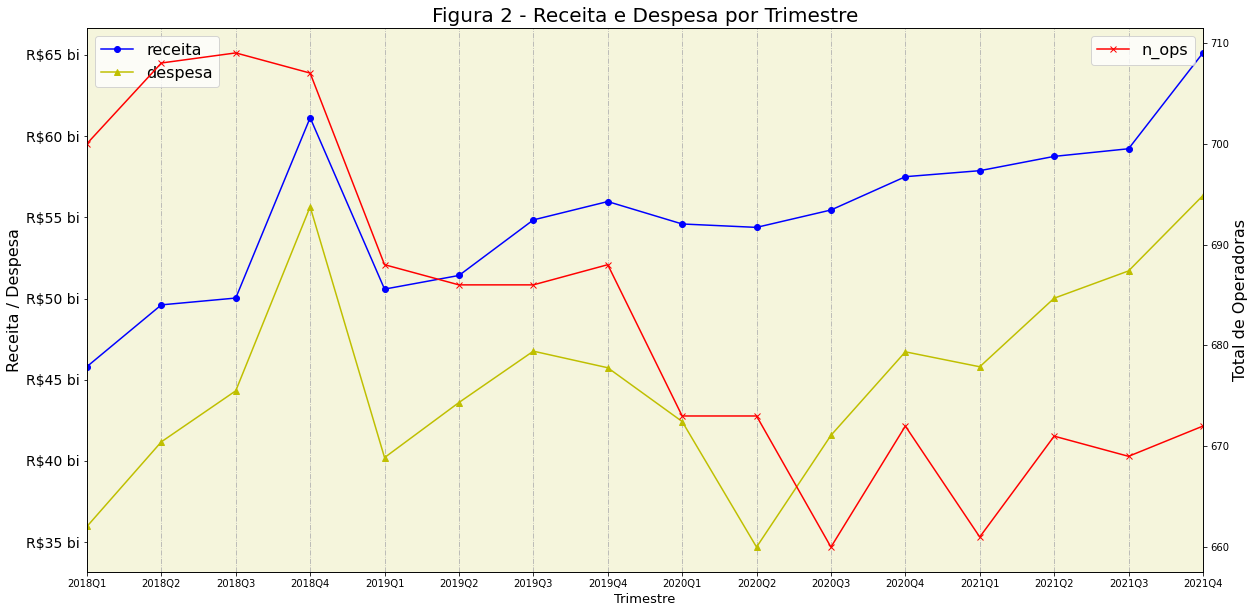

In [20]:
fig,ax1 = plt.subplots()

diops_tcc_analise.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(diops_tcc_analise.index)
ax1.set_xticklabels(diops_tcc_analise.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

diops_tcc_analise.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_analise.index)
ax2.set_xticklabels(diops_tcc_analise.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

## Limpeza e Tratamento de Dados

In [21]:
diops_tcc_analise1 = diops_tcc.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                          'despesa':'sum'})

diops_tcc_analise1 = diops_tcc_analise1[(diops_tcc_analise1['ano']>'2017') & (diops_tcc_analise1['ano']<'2022')] #Filtra anos de 2018 até 2021

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita != 0) & (diops_tcc_analise1.despesa == 0)].index)

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita == 0) & (diops_tcc_analise1.despesa != 0)].index)

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita == 0) & (diops_tcc_analise1.despesa == 0)].index)

diops_tcc_analise1

ano  cd_ops trimestre       receita       despesa
1428   2018      27    2018Q1  23205753.800  21011412.760
1429   2018      27    2018Q2  23299209.530  19557072.570
1430   2018      27    2018Q3  19029243.290  19869707.410
1431   2018      27    2018Q4  13584160.740  15486481.580
1432   2018  300012    2018Q1   4890415.420   3805978.920
...     ...     ...       ...           ...           ...
12346  2021     701    2021Q4 871792540.860 726156850.330
12347  2021     884    2021Q1  50117093.710  62328456.740
12348  2021     884    2021Q2  51133604.040  75619208.010
12349  2021     884    2021Q3  49093642.160  68671675.190
12350  2021     884    2021Q4  47122745.620  72791331.030

[10701 rows x 5 columns]

In [22]:
diops_tcc_analise2 = diops_tcc_analise1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
diops_tcc_analise2.head(15)

ano  cd_ops  n_trimestre
0   2018      27            4
1   2018  300012            4
2   2018  300136            4
3   2018  300713            4
4   2018  301060            4
5   2018  301124            4
6   2018  301574            4
7   2018  301728            4
8   2018  301744            4
9   2018  302091            4
10  2018  302147            4
11  2018  302228            3
12  2018  302490            4
13  2018  302627            4
14  2018  302953            4

In [23]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
diops_tcc_analise_complete = diops_tcc_analise2[diops_tcc_analise2['n_trimestre']==4].reset_index(drop=True)
diops_tcc_analise_complete = diops_tcc_analise_complete[['ano','cd_ops']]
diops_tcc_analise_complete.head()

ano  cd_ops
0  2018      27
1  2018  300012
2  2018  300136
3  2018  300713
4  2018  301060

In [24]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
diops_tcc_analise_imcomplete = diops_tcc_analise2[diops_tcc_analise2['n_trimestre']!=4].reset_index(drop=True)
diops_tcc_analise_imcomplete = diops_tcc_analise_imcomplete[['ano','cd_ops']]
diops_tcc_analise_imcomplete.head()

ano  cd_ops
0  2018  302228
1  2018  308005
2  2018  309401
3  2018  309907
4  2018  311961

In [25]:
#Filtra as operadoras com lançamentos completos
keys = list(diops_tcc_analise_complete.columns.values)
i1 = diops_tcc_analise1.set_index(keys).index
i2 = diops_tcc_analise_complete.set_index(keys).index

diops_tcc_analise3 =  diops_tcc_analise1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

diops_tcc_analise3.head()

#Verificação da filtragem
#diops_tcc_analise_vef = diops_tcc_analise_temp[(diops_tcc_analise_temp['ano']>'2017') & (diops_tcc_analise_temp['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

ano  cd_ops trimestre      receita      despesa
1428  2018      27    2018Q1 23205753.800 21011412.760
1429  2018      27    2018Q2 23299209.530 19557072.570
1430  2018      27    2018Q3 19029243.290 19869707.410
1431  2018      27    2018Q4 13584160.740 15486481.580
1432  2018  300012    2018Q1  4890415.420  3805978.920

In [26]:
#Cálculo do percentual de crescimento entre os trimestres
diops_tcc_analise3['ref1'] = (  diops_tcc_analise3['ano'].map(str) + 
                                diops_tcc_analise3['cd_ops'].map(str))

diops_tcc_analise3['ref2'] = (  diops_tcc_analise3['ano'].map(str) + 
                                diops_tcc_analise3['cd_ops'].map(str)+
                                diops_tcc_analise3['trimestre'].map(str))

diops_tcc_analise3[['receita_shifted','despesa_shifted']] = diops_tcc_analise3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

diops_tcc_analise3['pct_tri_receita'] = ((diops_tcc_analise3['receita'] / diops_tcc_analise3['receita_shifted'])) 
diops_tcc_analise3['pct_tri_despesa'] = ((diops_tcc_analise3['despesa'] / diops_tcc_analise3['despesa_shifted'])) 
 
diops_tcc_analise3 = diops_tcc_analise3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

diops_tcc_analise3

ano  cd_ops trimestre       receita  receita_shifted  pct_tri_receita       despesa  despesa_shifted  pct_tri_despesa
1428   2018      27    2018Q1  23205753.800            0.000            0.000  21011412.760            0.000            0.000
1429   2018      27    2018Q2  23299209.530     23205753.800            1.004  19557072.570     21011412.760            0.931
1430   2018      27    2018Q3  19029243.290     23299209.530            0.817  19869707.410     19557072.570            1.016
1431   2018      27    2018Q4  13584160.740     19029243.290            0.714  15486481.580     19869707.410            0.779
1432   2018  300012    2018Q1   4890415.420            0.000            0.000   3805978.920            0.000            0.000
...     ...     ...       ...           ...              ...              ...           ...              ...              ...
12346  2021     701    2021Q4 871792540.860    842368816.870            1.035 726156850.330    730249404.890            0.994
12347  2021     884    2021Q1  50117093.710            0.000            0.000  62328456.740            0.000            0.000
12348  2021     884    2021Q2  51133604.040     50117093.710            1.020  75619208.010     62328456.740            1.213
12349  2021     884    2021Q3  49093642.160     51133604.040            0.960  68671675.190     75619208.010            0.908
12350  2021     884    2021Q4  47122745.620     49093642.160            0.960  72791331.030     68671675.190            1.060

[10308 rows x 9 columns]

In [27]:
stats_diops_tcc = pd.DataFrame(diops_tcc_analise3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_diops_tcc = stats_diops_tcc.reset_index(level=[0,1])

stats_diops_tcc.columns = ['_'.join(col) for col in stats_diops_tcc.columns.values]

stats_diops_tcc = stats_diops_tcc[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_diops_tcc.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_tri_receita_25%':'pct_tri_receita_25',
                                  'pct_tri_receita_75%':'pct_tri_receita_75',
                                  'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                  'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_diops_tcc

ano trimestre  pct_tri_receita_25  pct_tri_receita_75  pct_tri_despesa_25  pct_tri_despesa_75
0   2018    2018Q1               0.000               0.000               0.000               0.000
1   2018    2018Q2               1.001               1.041               1.012               1.145
2   2018    2018Q3               1.004               1.046               0.972               1.094
3   2018    2018Q4               1.010               1.494               0.957               1.879
4   2019    2019Q1               0.000               0.000               0.000               0.000
5   2019    2019Q2               0.996               1.037               1.024               1.168
6   2019    2019Q3               1.001               1.042               0.968               1.094
7   2019    2019Q4               1.002               1.051               0.930               1.086
8   2020    2020Q1               0.000               0.000               0.000               0.000
9   2020    2020Q2               0.985               1.018               0.727               0.910
10  2020    2020Q3               0.993               1.031               1.050               1.300
11  2020    2020Q4               0.996               1.055               1.037               1.208
12  2021    2021Q1               0.000               0.000               0.000               0.000
13  2021    2021Q2               1.000               1.040               1.024               1.192
14  2021    2021Q3               0.990               1.032               0.979               1.145
15  2021    2021Q4               0.985               1.033               0.914               1.057

In [28]:
diops_tcc_analise4 =  pd.merge(diops_tcc_analise3, stats_diops_tcc, how = 'left', on = ['ano','trimestre'])

diops_tcc_analise4 = diops_tcc_analise4[(   (diops_tcc_analise4['pct_tri_receita'] >= diops_tcc_analise4['pct_tri_receita_25']) & 
                                            (diops_tcc_analise4['pct_tri_receita'] <= diops_tcc_analise4['pct_tri_receita_75'])) &
                                            ((diops_tcc_analise4['pct_tri_despesa'] >= diops_tcc_analise4['pct_tri_despesa_25']) & 
                                             (diops_tcc_analise4['pct_tri_despesa'] <= diops_tcc_analise4['pct_tri_despesa_75']))]

diops_tcc_analise4

ano  cd_ops trimestre        receita  receita_shifted  pct_tri_receita        despesa  despesa_shifted  pct_tri_despesa  pct_tri_receita_25  pct_tri_receita_75  pct_tri_despesa_25  pct_tri_despesa_75
0      2018      27    2018Q1   23205753.800            0.000            0.000   21011412.760            0.000            0.000               0.000               0.000               0.000               0.000
4      2018  300012    2018Q1    4890415.420            0.000            0.000    3805978.920            0.000            0.000               0.000               0.000               0.000               0.000
7      2018  300012    2018Q4    5489315.920      5191346.120            1.057    4119828.300      4051667.270            1.017               1.010               1.494               0.957               1.879
8      2018  300136    2018Q1   16878219.620            0.000            0.000   11900073.200            0.000            0.000               0.000               0.000               0.000               0.000
12     2018  300713    2018Q1   18684392.750            0.000            0.000   12529482.030            0.000            0.000               0.000               0.000               0.000               0.000
...     ...     ...       ...            ...              ...              ...            ...              ...              ...                 ...                 ...                 ...                 ...
10296  2021    6246    2021Q1 4693965248.310            0.000            0.000 3673295170.170            0.000            0.000               0.000               0.000               0.000               0.000
10298  2021    6246    2021Q3 4737997981.100   4668179872.960            1.015 4425569169.300   4054426648.120            1.092               0.990               1.032               0.979               1.145
10299  2021    6246    2021Q4 4783797155.930   4737997981.100            1.010 4337487608.560   4425569169.300            0.980               0.985               1.033               0.914               1.057
10300  2021     701    2021Q1  769613531.730            0.000            0.000  597844794.020            0.000            0.000               0.000               0.000               0.000               0.000
10304  2021     884    2021Q1   50117093.710            0.000            0.000   62328456.740            0.000            0.000               0.000               0.000               0.000               0.000

[4802 rows x 13 columns]

In [29]:
stats_diops_tcc2 = diops_tcc_analise4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_diops_tcc2 = stats_diops_tcc2.reset_index(level=[0,1])

stats_diops_tcc2.columns = ['_'.join(col) for col in stats_diops_tcc2.columns.values]

stats_diops_tcc2 = stats_diops_tcc2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_diops_tcc2.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_tri_receita_50%':'pct_tri_receita_50',
                                  'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_diops_tcc2

ano trimestre  pct_tri_receita_50  pct_tri_despesa_50
0   2018    2018Q1               0.000               0.000
1   2018    2018Q2               1.021               1.084
2   2018    2018Q3               1.027               1.034
3   2018    2018Q4               1.045               1.042
4   2019    2019Q1               0.000               0.000
5   2019    2019Q2               1.015               1.083
6   2019    2019Q3               1.021               1.026
7   2019    2019Q4               1.025               1.005
8   2020    2020Q1               0.000               0.000
9   2020    2020Q2               1.004               0.818
10  2020    2020Q3               1.008               1.184
11  2020    2020Q4               1.023               1.107
12  2021    2021Q1               0.000               0.000
13  2021    2021Q2               1.018               1.096
14  2021    2021Q3               1.008               1.052
15  2021    2021Q4               1.004               0.988

In [30]:
stats_diops_tcc2 = stats_diops_tcc2.replace(0.0, 1.0)

stats_diops_tcc2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_diops_tcc2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_diops_tcc2.fillna(1.0, inplace=True)

stats_diops_tcc2['pct_tri_receita_50_m1'] = stats_diops_tcc2['pct_tri_receita_50'] * stats_diops_tcc2['pct_tri_receita_50_l1']

stats_diops_tcc2['pct_tri_despesa_50_m1'] = stats_diops_tcc2['pct_tri_despesa_50'] * stats_diops_tcc2['pct_tri_despesa_50_l1']

stats_diops_tcc2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_diops_tcc2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_diops_tcc2.fillna(1.0, inplace=True)

stats_diops_tcc2['pct_tri_receita_50_m2'] = stats_diops_tcc2['pct_tri_receita_50'] * stats_diops_tcc2['pct_tri_receita_50_l2']

stats_diops_tcc2['pct_tri_despesa_50_m2'] = stats_diops_tcc2['pct_tri_despesa_50'] * stats_diops_tcc2['pct_tri_despesa_50_l2']

stats_diops_tcc2 = stats_diops_tcc2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_diops_tcc2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                   'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_diops_tcc2

ano trimestre  pct_tri_receita_50  pct_tri_despesa_50
0   2018    2018Q1               1.000               1.000
1   2018    2018Q2               1.021               1.084
2   2018    2018Q3               1.049               1.121
3   2018    2018Q4               1.096               1.169
4   2019    2019Q1               1.000               1.000
5   2019    2019Q2               1.015               1.083
6   2019    2019Q3               1.036               1.112
7   2019    2019Q4               1.062               1.118
8   2020    2020Q1               1.000               1.000
9   2020    2020Q2               1.004               0.818
10  2020    2020Q3               1.012               0.969
11  2020    2020Q4               1.035               1.072
12  2021    2021Q1               1.000               1.000
13  2021    2021Q2               1.018               1.096
14  2021    2021Q3               1.026               1.153
15  2021    2021Q4               1.030               1.139

In [31]:
keys = list(diops_tcc_analise_complete.columns.values)
i1 = diops_tcc_analise1.set_index(keys).index
i2 = diops_tcc_analise_complete.set_index(keys).index

diops_tcc_analise5 =  diops_tcc_analise1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
diops_tcc_analise5 = diops_tcc_analise5[((diops_tcc_analise5['receita']!=0.0)&(diops_tcc_analise5['despesa']!=0.0))]

#diops_tcc_analise5.head()

diops_tcc_analise5[diops_tcc_analise5['cd_ops']=='302091']

#diops_tcc_analise_vef = diops_tcc_analise5[(diops_tcc_analise5['ano']>'2017') & (diops_tcc_analise5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

ano  cd_ops trimestre       receita       despesa
9710  2021  302091    2021Q1 465530623.590 256208379.180
9711  2021  302091    2021Q2 470407847.820 225636490.230
9712  2021  302091    2021Q3 471168766.720 356784174.890

In [32]:
diops_tcc_analise6 = diops_tcc_analise5[['cd_ops','trimestre','receita','despesa']]
diops_tcc_analise6 = diops_tcc_analise6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([diops_tcc_analise6.index.levels[0], diops_tcc_analise6.index.levels[1]],names=['cd_ops','trimestre'])
diops_tcc_analise6 = diops_tcc_analise6.reindex(mux, fill_value=0).reset_index()

diops_tcc_analise6['ano'] = diops_tcc_analise6['trimestre'].dt.year

diops_tcc_analise6['ano'] = diops_tcc_analise6['ano'].apply(pd.Period, freq='A-DEC')

diops_tcc_analise6 = diops_tcc_analise6[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

diops_tcc_analise6[diops_tcc_analise6['cd_ops']=='302091']

#diops_tcc_analise6.head(30)

ano  cd_ops trimestre       receita       despesa
0     2018  302091    2018Q1         0.000         0.000
1     2018  302091    2018Q2         0.000         0.000
2     2018  302091    2018Q3         0.000         0.000
3     2018  302091    2018Q4         0.000         0.000
588   2019  302091    2019Q1         0.000         0.000
589   2019  302091    2019Q2         0.000         0.000
590   2019  302091    2019Q3         0.000         0.000
591   2019  302091    2019Q4         0.000         0.000
1176  2020  302091    2020Q1         0.000         0.000
1177  2020  302091    2020Q2         0.000         0.000
1178  2020  302091    2020Q3         0.000         0.000
1179  2020  302091    2020Q4         0.000         0.000
1764  2021  302091    2021Q1 465530623.590 256208379.180
1765  2021  302091    2021Q2 470407847.820 225636490.230
1766  2021  302091    2021Q3 471168766.720 356784174.890
1767  2021  302091    2021Q4         0.000         0.000

In [33]:
diops_tcc_analise7 = diops_tcc_analise6.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                        'despesa': 'sum'})

diops_tcc_analise7['receita_tri'] = diops_tcc_analise7['receita'] / 4.0

diops_tcc_analise7['despesa_tri'] = diops_tcc_analise7['despesa'] / 4.0

diops_tcc_analise7.head()

ano  cd_ops      receita      despesa  receita_tri  despesa_tri
0  2018  302091        0.000        0.000        0.000        0.000
1  2018  302228 18517714.580 25297419.510  4629428.645  6324354.878
2  2018  304701        0.000        0.000        0.000        0.000
3  2018  305995        0.000        0.000        0.000        0.000
4  2018  306444        0.000        0.000        0.000        0.000

In [34]:
diops_tcc_analise8 =  pd.merge(diops_tcc_analise6, diops_tcc_analise7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

diops_tcc_analise8 = diops_tcc_analise8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

diops_tcc_analise8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

diops_tcc_analise8 = diops_tcc_analise8.drop(diops_tcc_analise8[(diops_tcc_analise8.receita == 0) & (diops_tcc_analise8.despesa == 0)].index)

diops_tcc_analise8 = diops_tcc_analise8.drop(diops_tcc_analise8[(diops_tcc_analise8.receita < 1.0) | (diops_tcc_analise8.despesa < 1.0)].index)

diops_tcc_analise8[diops_tcc_analise8['cd_ops']=='302228']

#diops_tcc_analise8.head()

#diops_tcc_analise_vef = diops_tcc_analise_temp5[(diops_tcc_analise_temp5['ano']>'2017') & (diops_tcc_analise_temp5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

ano  cd_ops trimestre     receita     despesa
4  2018  302228    2018Q1 4629428.645 6324354.878
5  2018  302228    2018Q2 4629428.645 6324354.878
6  2018  302228    2018Q3 4629428.645 6324354.878
7  2018  302228    2018Q4 4629428.645 6324354.878

In [35]:
diops_tcc_analise9 = pd.merge(diops_tcc_analise8,stats_diops_tcc2, on=['ano','trimestre'])

diops_tcc_analise9['receita_m1'] = diops_tcc_analise9['receita'] * diops_tcc_analise9['pct_tri_receita_50']

diops_tcc_analise9['despesa_m1'] = diops_tcc_analise9['despesa'] * diops_tcc_analise9['pct_tri_despesa_50']

diops_tcc_analise9 = diops_tcc_analise9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

diops_tcc_analise9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#diops_tcc_analise9[diops_tcc_analise9['cd_ops']=='302228']
 
diops_tcc_analise9.head()

ano  cd_ops trimestre      receita      despesa
0  2018  302228    2018Q1  4629428.645  6324354.878
1  2018  308005    2018Q1  2251850.935  1826842.618
2  2018  309401    2018Q1   183766.797   116052.867
3  2018  309907    2018Q1 23316465.517 18008740.152
4  2018  311961    2018Q1 71627340.273 63443205.945

In [36]:
diops_tcc_analise10 = diops_tcc_analise9.groupby(['ano','cd_ops'], as_index=False).agg({'receita': 'sum',
                                                                                        'despesa': 'sum'})

diops_tcc_analise10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

diops_tcc_analise10 = pd.merge(diops_tcc_analise10, diops_tcc_analise7, on=['ano','cd_ops'])

diops_tcc_analise10 = diops_tcc_analise10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

diops_tcc_analise10['receita_diff'] = diops_tcc_analise10['receita2'] - diops_tcc_analise10['receita']

diops_tcc_analise10['despesa_diff'] = diops_tcc_analise10['despesa2'] - diops_tcc_analise10['despesa']

diops_tcc_analise10['receita_tri_diff'] = diops_tcc_analise10['receita_diff'] / 4.0

diops_tcc_analise10['despesa_tri_diff'] = diops_tcc_analise10['despesa_diff'] / 4.0

diops_tcc_analise10 = diops_tcc_analise10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

diops_tcc_analise10.head()

ano  cd_ops  receita_tri_diff  despesa_tri_diff
0  2018  302228        192684.866        591827.104
1  2018  308005         93725.950        170954.192
2  2018  309401          7648.694         10860.117
3  2018  309907        970471.820       1685240.746
4  2018  311961       2981254.393       5936954.769

In [37]:
diops_tcc_analise11 =  pd.merge(diops_tcc_analise9, diops_tcc_analise10, how = 'outer', on = ['ano','cd_ops'])

diops_tcc_analise11['receita_final'] = diops_tcc_analise11['receita'] - diops_tcc_analise11['receita_tri_diff']

diops_tcc_analise11['despesa_final'] = diops_tcc_analise11['despesa'] - diops_tcc_analise11['despesa_tri_diff']

diops_tcc_analise11 = diops_tcc_analise11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

diops_tcc_analise11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

diops_tcc_analise11.head()

#diops_tcc_analise_vef = diops_tcc_analise_temp5[(diops_tcc_analise_temp5['ano']>'2017') & (diops_tcc_analise_temp5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

ano  cd_ops trimestre     receita     despesa
0  2018  302228    2018Q1 4436743.779 5732527.773
1  2018  302228    2018Q2 4535575.896 6266544.195
2  2018  302228    2018Q3 4664040.799 6500090.090
3  2018  302228    2018Q4 4881354.106 6798257.452
4  2018  308005    2018Q1 2158124.985 1655888.426

In [38]:
diops_tcc_analise12 = diops_tcc_analise11.groupby(['ano','cd_ops'], as_index=False).agg({'receita': 'sum',
                                                                                         'despesa': 'sum'})

diops_tcc_analise12['receita_tri'] = diops_tcc_analise12['receita'] / 4.0

diops_tcc_analise12['despesa_tri'] = diops_tcc_analise12['despesa'] / 4.0

diops_tcc_analise12.head()

ano  cd_ops       receita       despesa  receita_tri  despesa_tri
0  2018  302228  18517714.580  25297419.510  4629428.645  6324354.877
1  2018  308005   9007403.740   7307370.470  2251850.935  1826842.618
2  2018  309401    735067.190    464211.470   183766.797   116052.867
3  2018  309907  93265862.070  72034960.610 23316465.517 18008740.152
4  2018  311961 286509361.090 253772823.780 71627340.273 63443205.945

In [39]:
diops_tcc_analise13 = diops_tcc_analise3[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise14 = pd.concat([diops_tcc_analise13, diops_tcc_analise11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

diops_tcc_analise14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

ano  cd_ops trimestre      receita      despesa
0  2018      27    2018Q1 23205753.800 21011412.760
1  2018      27    2018Q2 23299209.530 19557072.570
2  2018      27    2018Q3 19029243.290 19869707.410
3  2018      27    2018Q4 13584160.740 15486481.580
4  2018  300012    2018Q1  4890415.420  3805978.920

In [40]:
diops_tcc_analise15 = diops_tcc_analise14.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_analise15['pct_despesa'] = diops_tcc_analise15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_analise15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_analise15 = diops_tcc_analise15[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_analise15.set_index('trimestre', inplace=True)

diops_tcc_analise15

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      47.180   37.080    714       78.590
2018Q2      48.290   40.230    714       83.310
2018Q3      50.050   44.420    714       88.750
2018Q4      61.070   55.390    714       90.700
2019Q1      51.050   40.530    690       79.390
2019Q2      52.210   44.270    690       84.790
2019Q3      53.540   45.690    690       85.340
2019Q4      56.010   45.800    690       81.770
2020Q1      54.650   42.450    672       77.680
2020Q2      54.150   34.530    672       63.770
2020Q3      55.500   41.620    672       74.990
2020Q4      57.630   46.800    672       81.210
2021Q1      58.550   46.340    674       79.150
2021Q2      59.620   51.080    674       85.680
2021Q3      60.690   52.910    674       87.180
2021Q4      62.080   53.510    674       86.200

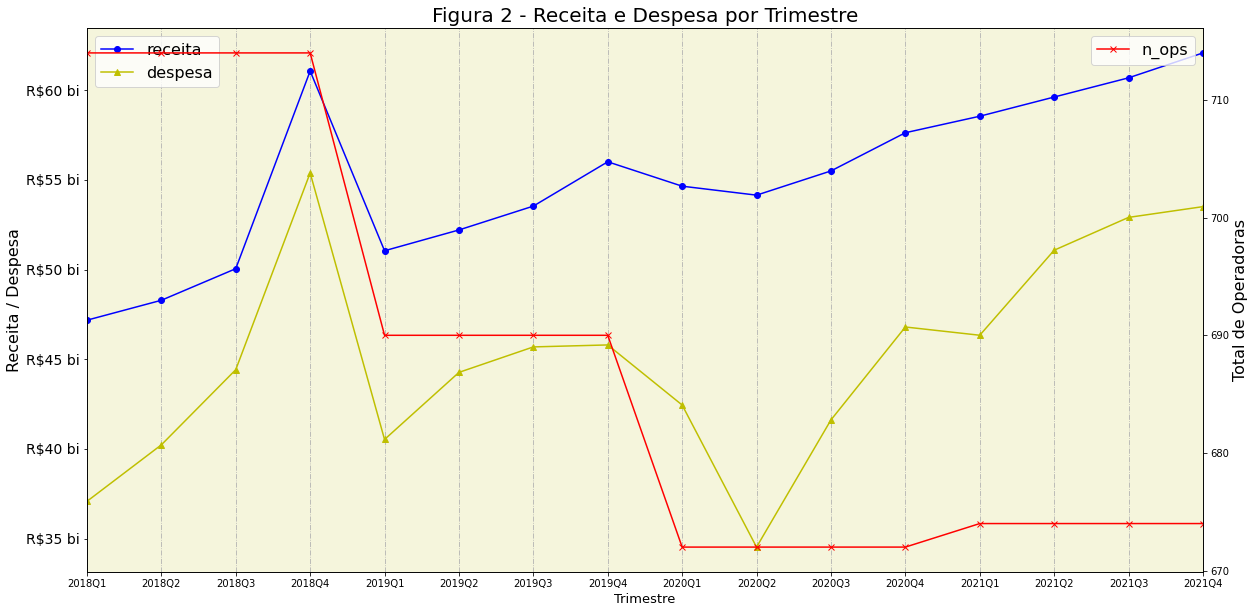

In [41]:
df_plot = diops_tcc_analise15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)


plt.show()

In [42]:
#Cria o rankin das operadoras com maior receita e despesa
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                         'despesa':lambda x: sum_billion(x)})

diops_tcc_analise16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

diops_tcc_analise16

ano  cd_ops  receita  despesa
709   2018    5711   22.230   19.290
185   2018  326305   19.990   16.780
711   2018    6246   15.470   12.130
414   2018  359017    5.590    6.700
509   2018  393321    5.510    4.780
...    ...     ...      ...      ...
2736  2021  422584    0.000    0.000
2737  2021  422614    0.000    0.000
2740  2021  422720    0.000    0.000
2741  2021  422754    0.000    0.000
2742  2021  422762    0.000    0.000

[2750 rows x 4 columns]

In [43]:
diops_tcc_trimestral_ops = diops_tcc_analise16.head(100)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops']].reset_index(drop=True)

keys = list(diops_tcc_trimestral_ops.columns.values)
i1 = diops_tcc_analise14.set_index(keys).index
i2 = diops_tcc_trimestral_ops.set_index(keys).index

diops_tcc_analise16 =  diops_tcc_analise14[i1.isin(i2)]

diops_tcc_analise16.sort_values(by=['receita'], ascending=False, inplace=True)

diops_tcc_analise16.head()

ano cd_ops trimestre        receita        despesa
10291  2021   5711    2021Q4 6949369996.220 6381595012.610
10290  2021   5711    2021Q3 6776296671.760 6329774938.060
10289  2021   5711    2021Q2 6722286604.220 6100189595.320
10288  2021   5711    2021Q1 6661933042.600 5771245701.700
7775   2020   5711    2020Q4 6546387457.780 5747678390.500

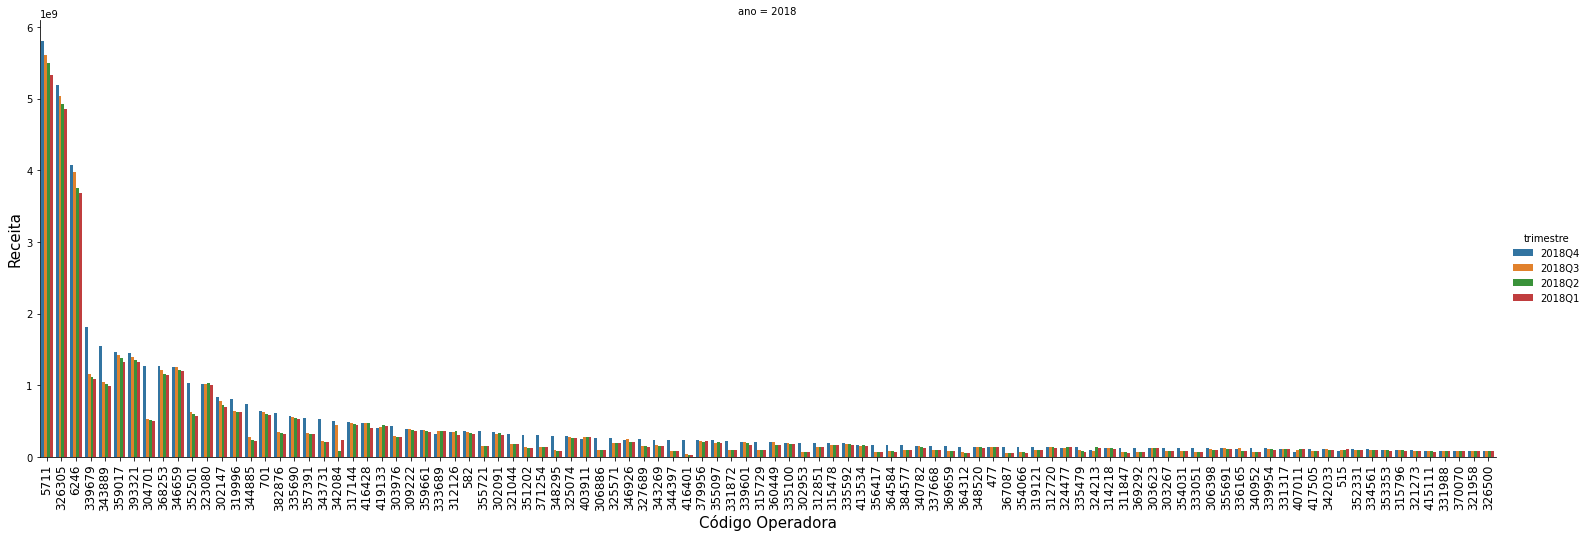

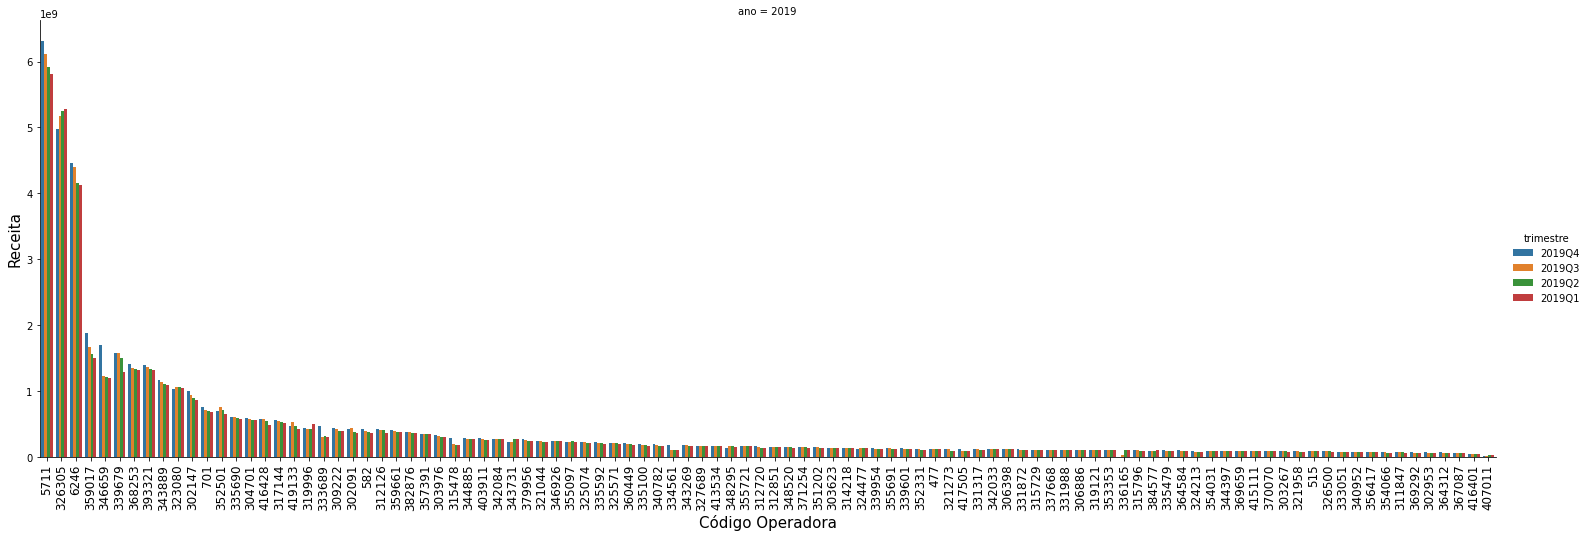

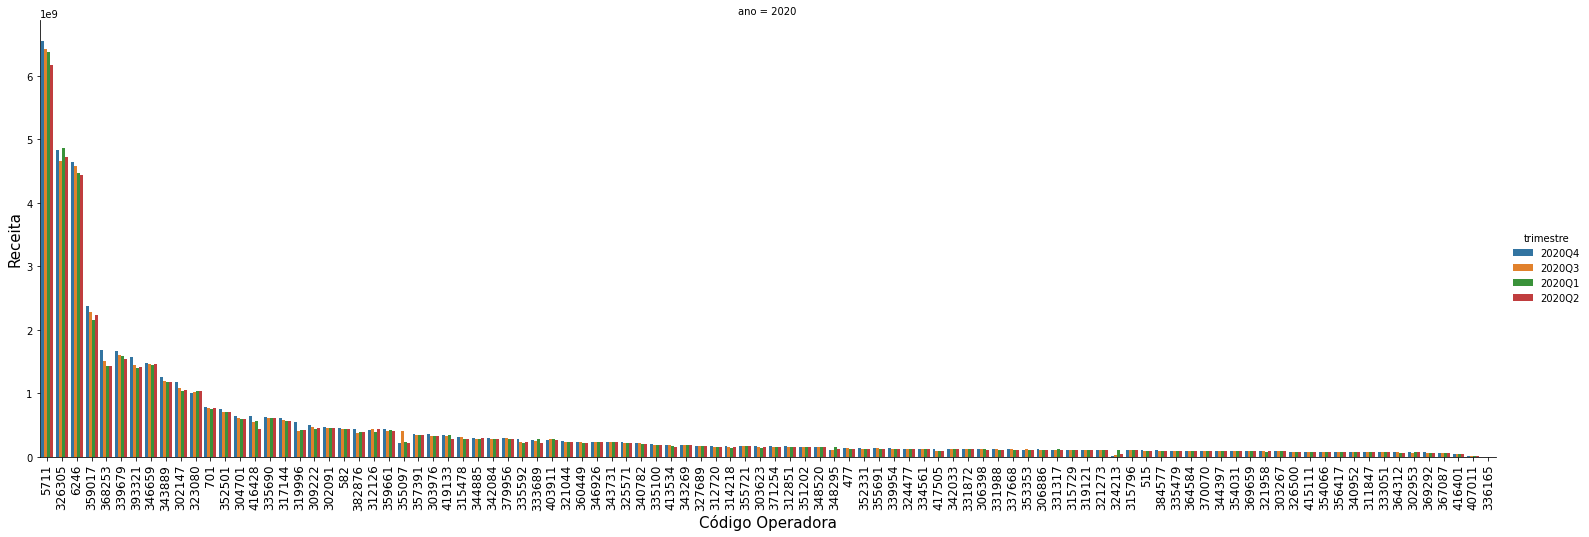

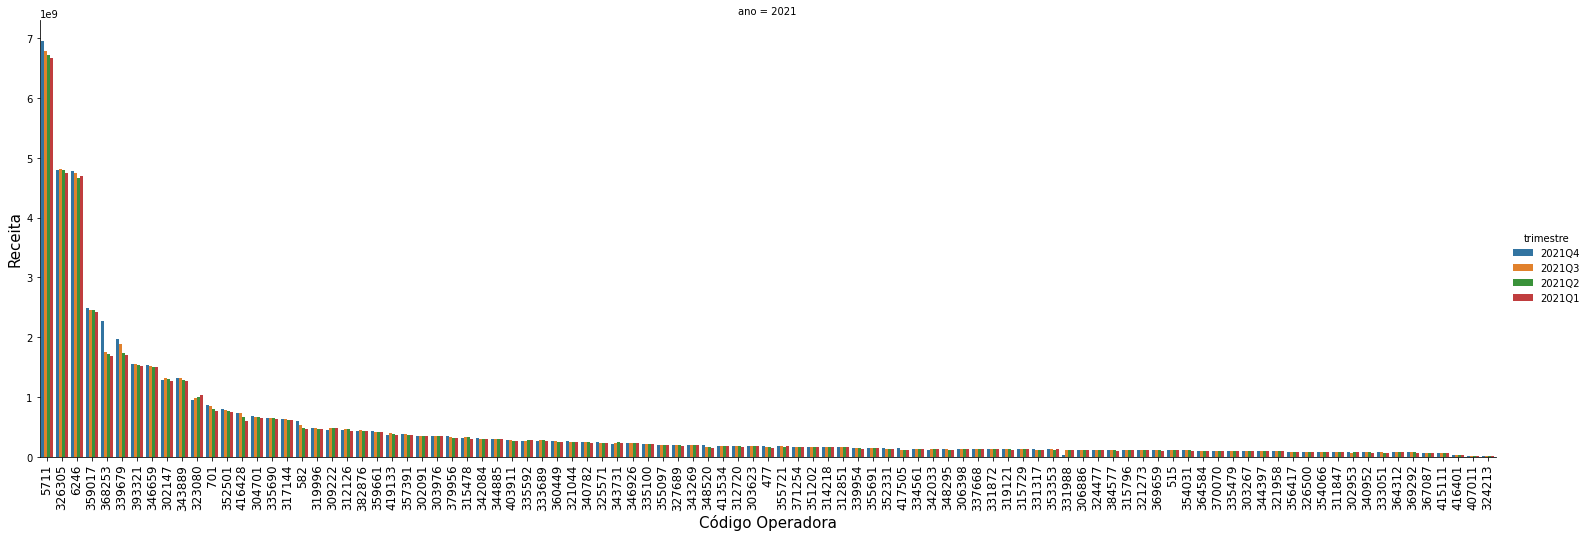

In [44]:
df_plot = diops_tcc_analise16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

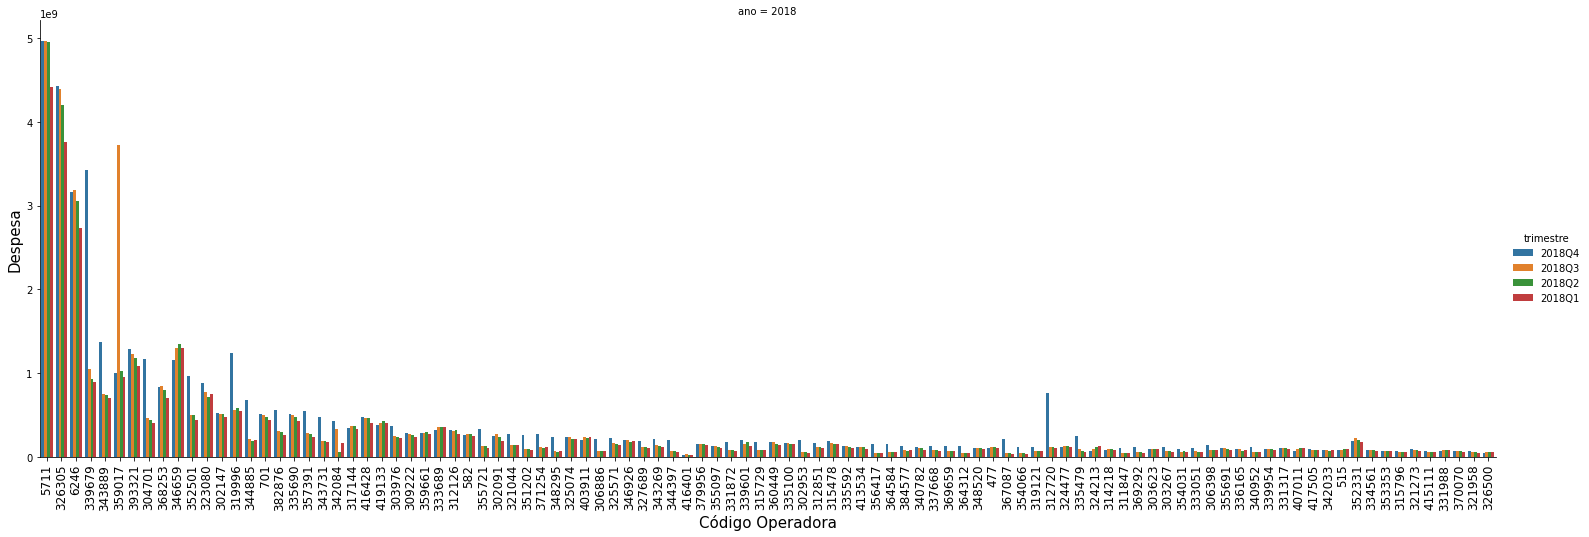

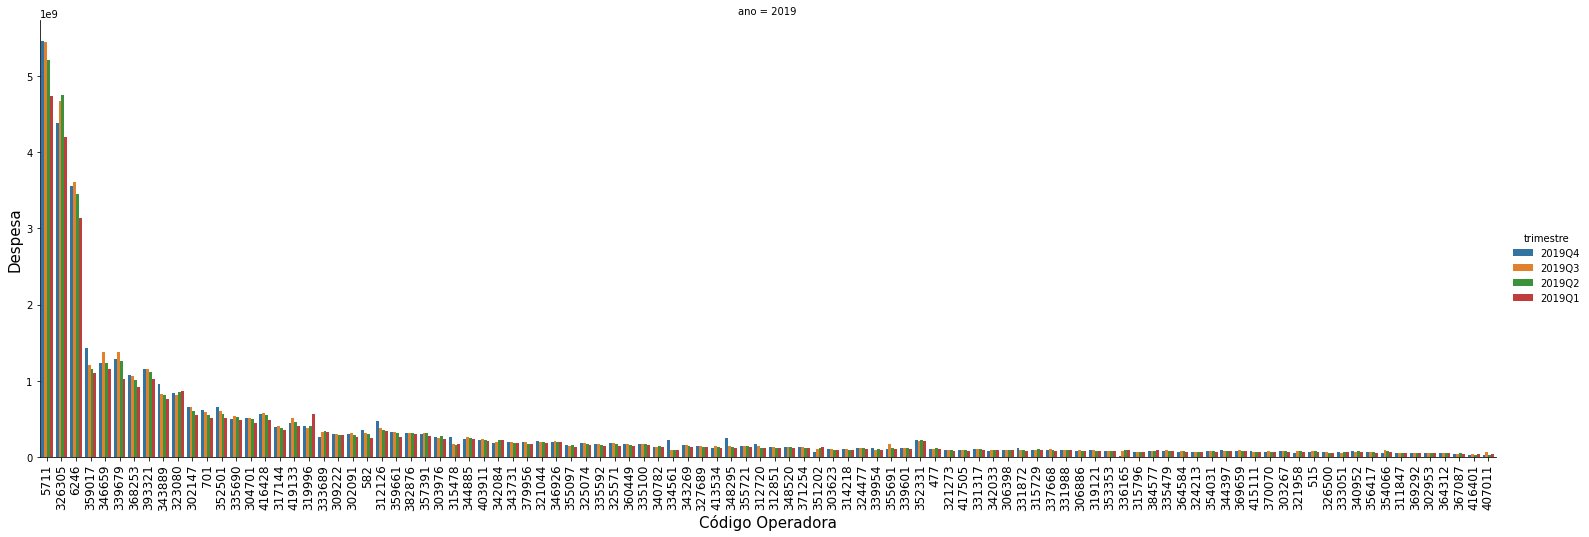

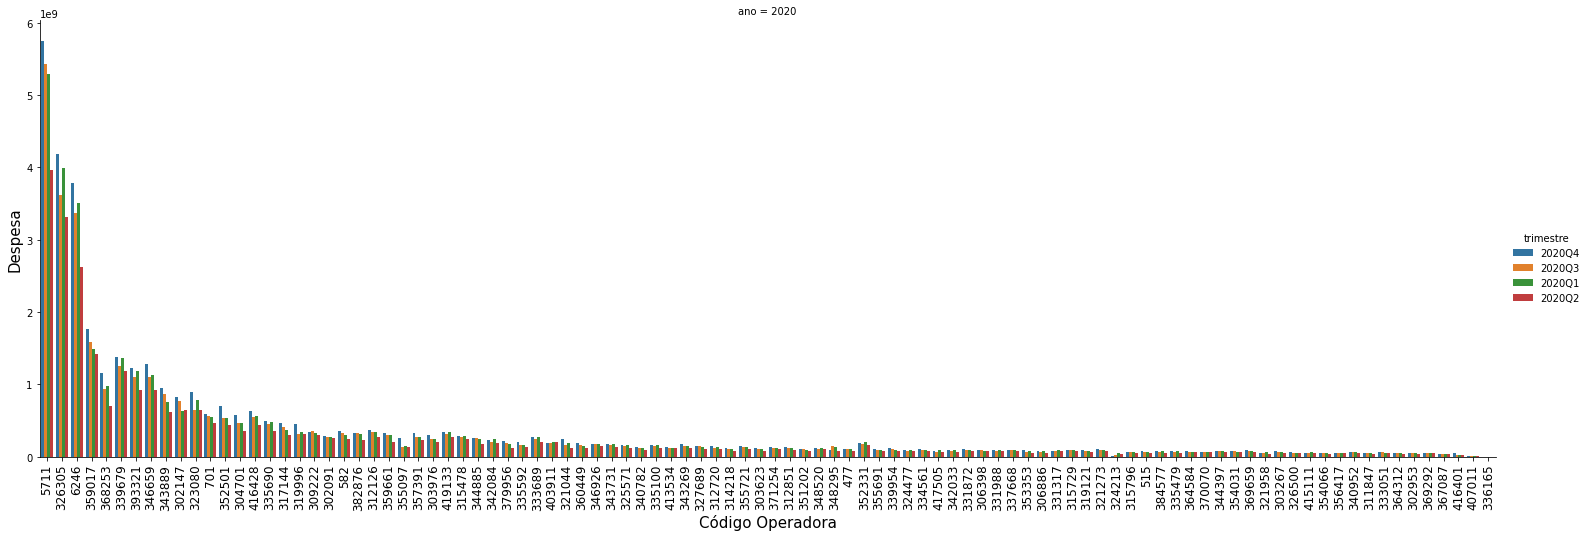

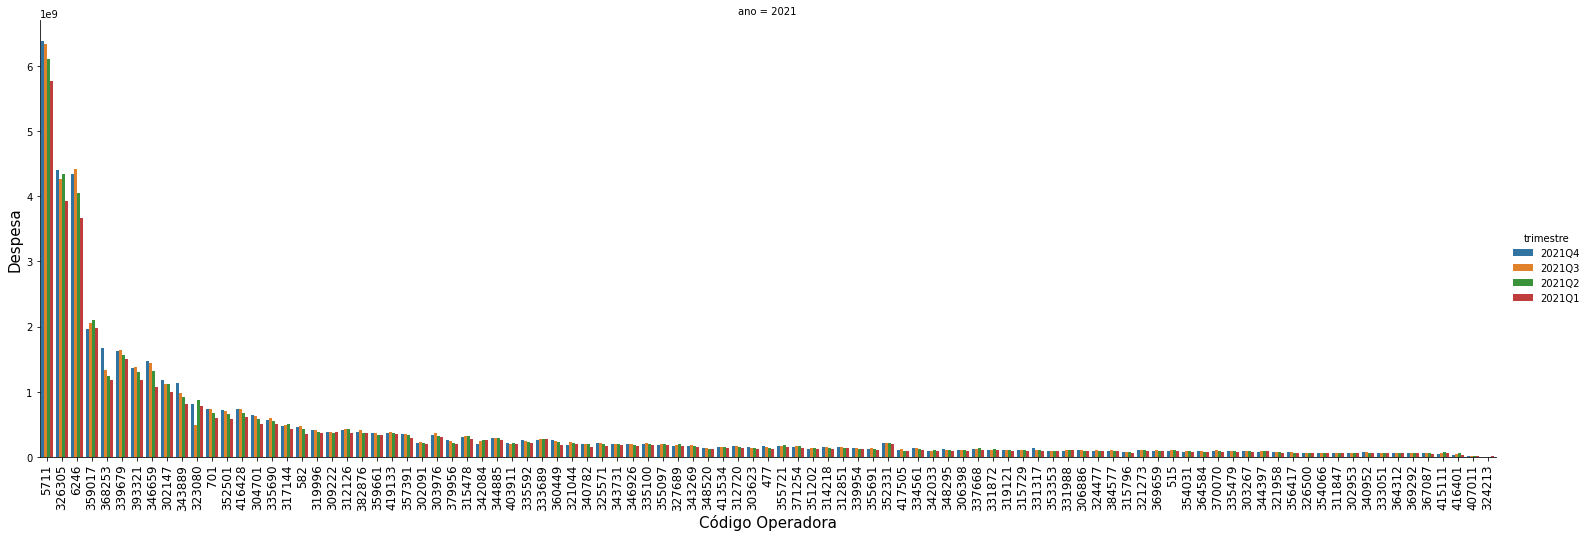

In [45]:
df_plot = diops_tcc_analise16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [46]:
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg( receita_total = ('receita','sum'),
                                                                                         despesa_total = ('despesa','sum'))

diops_tcc_analise17 = pd.merge(diops_tcc_analise14,diops_tcc_analise16, how='left', on=['ano','cd_ops'])

#diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['trimestre']=='2018Q4') | (diops_tcc_analise17['trimestre']=='2018Q3')]

diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['ano']=='2018')]

diops_tcc_analise17['pct_receita'] = diops_tcc_analise17['receita'] / diops_tcc_analise17['receita_total']

diops_tcc_analise17['pct_despesa'] = diops_tcc_analise17['despesa'] / diops_tcc_analise17['despesa_total']

diops_tcc_analise17.head()

ano  cd_ops trimestre      receita      despesa  receita_total  despesa_total  pct_receita  pct_despesa
0  2018      27    2018Q1 23205753.800 21011412.760   79118367.360   75924674.320        0.293        0.277
1  2018      27    2018Q2 23299209.530 19557072.570   79118367.360   75924674.320        0.294        0.258
2  2018      27    2018Q3 19029243.290 19869707.410   79118367.360   75924674.320        0.241        0.262
3  2018      27    2018Q4 13584160.740 15486481.580   79118367.360   75924674.320        0.172        0.204
4  2018  300012    2018Q1  4890415.420  3805978.920   20390875.840   15644601.650        0.240        0.243

In [47]:
stats_diops_tcc3 = diops_tcc_analise17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_diops_tcc3

pct_receita                                     pct_despesa                                    
                     count  mean   std   min   50%   51%   max       count  mean   std   min   50%   51%   max
ano  trimestre                                                                                                
2018 2018Q1        714.000 0.228 0.048 0.005 0.237 0.238 0.753     714.000 0.213 0.050 0.001 0.224 0.225 0.667
     2018Q2        714.000 0.232 0.038 0.004 0.244 0.244 0.419     714.000 0.229 0.048 0.002 0.245 0.246 0.461
     2018Q3        714.000 0.238 0.041 0.003 0.251 0.251 0.739     714.000 0.236 0.049 0.010 0.253 0.254 0.556
     2018Q4        714.000 0.302 0.094 0.010 0.264 0.264 0.929     714.000 0.322 0.122 0.072 0.269 0.269 0.939

In [48]:
stats_diops_tcc4 = stats_diops_tcc3.reset_index(level=[0,1])

stats_diops_tcc4.columns = ['_'.join(col) for col in stats_diops_tcc4.columns.values]

stats_diops_tcc4 = stats_diops_tcc4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_diops_tcc4.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_receita_50%':'pct_receita_50',
                                  'pct_despesa_50%':'pct_despesa_50',
                                  'pct_receita_51%':'pct_receita_ref',
                                  'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_diops_tcc4

ano trimestre  pct_receita_mean  pct_despesa_mean  pct_receita_50  pct_despesa_50  pct_receita_ref  pct_despesa_ref
0  2018    2018Q1             0.228             0.213           0.237           0.224            0.238            0.225
1  2018    2018Q2             0.232             0.229           0.244           0.245            0.244            0.246
2  2018    2018Q3             0.238             0.236           0.251           0.253            0.251            0.254
3  2018    2018Q4             0.302             0.322           0.264           0.269            0.264            0.269

In [49]:
diops_tcc_analise18 = pd.merge(diops_tcc_analise17,stats_diops_tcc4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

diops_tcc_analise18['receita_mean'] = diops_tcc_analise18['receita_total'] * diops_tcc_analise18['pct_receita_50']

diops_tcc_analise18['despesa_mean'] = diops_tcc_analise18['despesa_total'] * diops_tcc_analise18['pct_despesa_50']

diops_tcc_analise18 = diops_tcc_analise18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

diops_tcc_analise18.head()

ano  cd_ops trimestre  receita_mean  despesa_mean
0  2018      27    2018Q1  18753945.107  17040532.034
1  2018      27    2018Q2  19301098.588  18596318.891
2  2018      27    2018Q3  19861991.173  19239626.079
3  2018      27    2018Q4  20860548.034  20403483.555
4  2018  300012    2018Q1   4833382.929   3511274.009

In [50]:
diops_tcc_analise19 = pd.merge(diops_tcc_analise17,stats_diops_tcc4, how='left', on=['ano','trimestre'])

#diops_tcc_analise18 = diops_tcc_analise18[(diops_tcc_analise18['pct_receita'] > diops_tcc_analise18['pct_receita_ref']) | (diops_tcc_analise18['pct_despesa'] > diops_tcc_analise18['pct_despesa_ref'])]

diops_tcc_analise19 = diops_tcc_analise19[(diops_tcc_analise19['pct_receita'] > diops_tcc_analise19['pct_receita_50'])]

diops_tcc_analise19 = diops_tcc_analise19[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

diops_tcc_analise19.head()

ano  cd_ops trimestre      receita      despesa
0  2018      27    2018Q1 23205753.800 21011412.760
1  2018  408522    2018Q3   986831.470   468625.420
2  2018  408522    2018Q2   977278.310   457337.280
3  2018  408522    2018Q1   951991.160   283241.210
4  2018  408263    2018Q3  1979247.400  1824661.980

In [51]:
diops_tcc_analise20 = pd.merge(diops_tcc_analise19,diops_tcc_analise18, how='left', on=['ano','cd_ops','trimestre'])

diops_tcc_analise20 = diops_tcc_analise20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

diops_tcc_analise20.head()

ano  cd_ops trimestre  receita_mean  despesa_mean
0  2018      27    2018Q1  18753945.107  17040532.034
1  2018  408522    2018Q3    984042.124    405905.027
2  2018  408522    2018Q2    956253.272    392332.953
3  2018  408522    2018Q1    929145.110    359509.981
4  2018  408263    2018Q3   1969388.809   1975468.201

In [52]:
diops_tcc_analise21 = pd.merge(diops_tcc_analise14,diops_tcc_analise20, how='left', on=['ano','cd_ops','trimestre'])

#diops_tcc_analise21['receita_diff'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_mean']) / 4.0

#diops_tcc_analise21['despesa_diff'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_mean'])/ 4.0

diops_tcc_analise21.fillna(0, inplace=True)

diops_tcc_analise21['receita_corrigida'] = np.where(diops_tcc_analise21['receita_mean'] == 0, diops_tcc_analise21['receita'], diops_tcc_analise21['receita_mean'])

diops_tcc_analise21['despesa_corrigida'] = np.where(diops_tcc_analise21['despesa_mean'] == 0, diops_tcc_analise21['despesa'], diops_tcc_analise21['despesa_mean'])

diops_tcc_analise21['receita_diff_tri'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_corrigida']) / 4.0

diops_tcc_analise21['despesa_diff_tri'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

diops_tcc_analise21.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise21[diops_tcc_analise21['cd_ops']=='300012']

ano  cd_ops trimestre      receita      despesa  receita_mean  despesa_mean  receita_corrigida  despesa_corrigida  receita_diff_tri  despesa_diff_tri
4     2018  300012    2018Q1  4890415.420  3805978.920   4833382.929   3511274.009        4833382.929        3511274.009         14258.123         73676.228
5     2018  300012    2018Q2  4819798.380  3667127.160         0.000         0.000        4819798.380        3667127.160             0.000             0.000
6     2018  300012    2018Q3  5191346.120  4051667.270   5118955.427   3964406.678        5118955.427        3964406.678         18097.673         21815.148
7     2018  300012    2018Q4  5489315.920  4119828.300   5376309.688   4204224.455        5376309.688        4204224.455         28251.558        -21099.039
2672  2019  300012    2019Q1  5404309.720  4749396.120         0.000         0.000        5404309.720        4749396.120             0.000             0.000
2673  2019  300012    2019Q2 15586110.070 13672212.360         0.000         0.000       15586110.070       13672212.360             0.000             0.000
2674  2019  300012    2019Q3  5193069.290  4415964.750         0.000         0.000        5193069.290        4415964.750             0.000             0.000
2675  2019  300012    2019Q4 10201126.690  9393758.350         0.000         0.000       10201126.690        9393758.350             0.000             0.000
5263  2020  300012    2020Q4  5095946.890  3439589.030         0.000         0.000        5095946.890        3439589.030             0.000             0.000
5262  2020  300012    2020Q3  5041079.870  4026865.790         0.000         0.000        5041079.870        4026865.790             0.000             0.000
5261  2020  300012    2020Q2  4955691.290  3404150.530         0.000         0.000        4955691.290        3404150.530             0.000             0.000
5260  2020  300012    2020Q1  5112226.920  4302009.630         0.000         0.000        5112226.920        4302009.630             0.000             0.000
7792  2021  300012    2021Q1  5420046.590  4331914.120         0.000         0.000        5420046.590        4331914.120             0.000             0.000
7793  2021  300012    2021Q2  3974205.990  4326984.010         0.000         0.000        3974205.990        4326984.010             0.000             0.000
7794  2021  300012    2021Q3  1891722.860  1291948.460         0.000         0.000        1891722.860        1291948.460             0.000             0.000
7795  2021  300012    2021Q4  1761541.560  9252348.520         0.000         0.000        1761541.560        9252348.520             0.000             0.000

In [53]:
diops_tcc_analise22 = diops_tcc_analise21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

diops_tcc_analise22 = diops_tcc_analise22[diops_tcc_analise22['receita_diff_tri']!=0]

diops_tcc_analise22.head()

ano  cd_ops  receita_diff_tri  despesa_diff_tri
0  2018      27       2112479.909       1232908.601
1  2018  300012         60607.354         74392.337
2  2018  300136       1976140.941       3642167.893
3  2018  300713       5240114.086       4692626.018
4  2018  301060       2043831.816       2417939.009

In [54]:
diops_tcc_analise23 = diops_tcc_analise21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

diops_tcc_analise23.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise23.head()

ano  cd_ops trimestre  receita_corrigida  despesa_corrigida
0     2018      27    2018Q1       18753945.107       17040532.034
1898  2018      27    2018Q2       19301098.588       18596318.891
1899  2018      27    2018Q3       19029243.290       19869707.410
1900  2018      27    2018Q4       13584160.740       15486481.580
1901  2018  300012    2018Q1        4833382.929        3511274.009

In [55]:
diops_tcc_analise24 = pd.merge(diops_tcc_analise23, diops_tcc_analise22, how='left', on = ['ano','cd_ops'])

diops_tcc_analise24.fillna(0, inplace=True)

diops_tcc_analise24.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise24['receita'] = diops_tcc_analise24['receita_corrigida'] + diops_tcc_analise24['receita_diff_tri']

diops_tcc_analise24['despesa'] = diops_tcc_analise24['despesa_corrigida'] + diops_tcc_analise24['despesa_diff_tri']

diops_tcc_analise24 = diops_tcc_analise24[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise24[diops_tcc_analise24['cd_ops']=='342084']

ano  cd_ops trimestre       receita       despesa
1048  2018  342084    2018Q4 408009446.076 322985700.559
1040  2018  342084    2018Q1 310453941.343 225715979.796
1041  2018  342084    2018Q2 158546252.223 117893368.066
1042  2018  342084    2018Q3 391993296.718 308045333.610
3695  2019  342084    2019Q1 266070034.890 225561079.020
3692  2019  342084    2019Q4 276905080.430 184037585.490
3693  2019  342084    2019Q3 268637676.190 196724239.350
3694  2019  342084    2019Q2 268501971.520 220265723.230
6330  2020  342084    2020Q1 284858475.390 241688474.860
6331  2020  342084    2020Q2 284660769.750 188116134.460
6332  2020  342084    2020Q3 286739349.130 205361125.640
6333  2020  342084    2020Q4 296160229.580 225444865.500
9503  2021  342084    2021Q1 297935919.730 253272632.480
9501  2021  342084    2021Q2 300830832.120 262893217.640
9484  2021  342084    2021Q3 305358194.690 239853690.980
9485  2021  342084    2021Q4 309276745.950 199536796.210

In [56]:
diops_tcc_analise25 = diops_tcc_analise24.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_analise25['pct_despesa'] = diops_tcc_analise25.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_analise25.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_analise25 = diops_tcc_analise25[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_analise25.set_index('trimestre', inplace=True)

diops_tcc_analise25

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      48.790   39.430    714       80.820
2018Q2      50.040   43.360    714       86.650
2018Q3      51.720   44.930    714       86.870
2018Q4      56.030   49.390    714       88.150
2019Q1      51.050   40.530    690       79.390
2019Q2      52.210   44.270    690       84.790
2019Q3      53.540   45.690    690       85.340
2019Q4      56.010   45.800    690       81.770
2020Q1      54.650   42.450    672       77.680
2020Q2      54.150   34.530    672       63.770
2020Q3      55.500   41.620    672       74.990
2020Q4      57.630   46.800    672       81.210
2021Q1      58.550   46.340    674       79.150
2021Q2      59.620   51.080    674       85.680
2021Q3      60.690   52.910    674       87.180
2021Q4      62.080   53.510    674       86.200

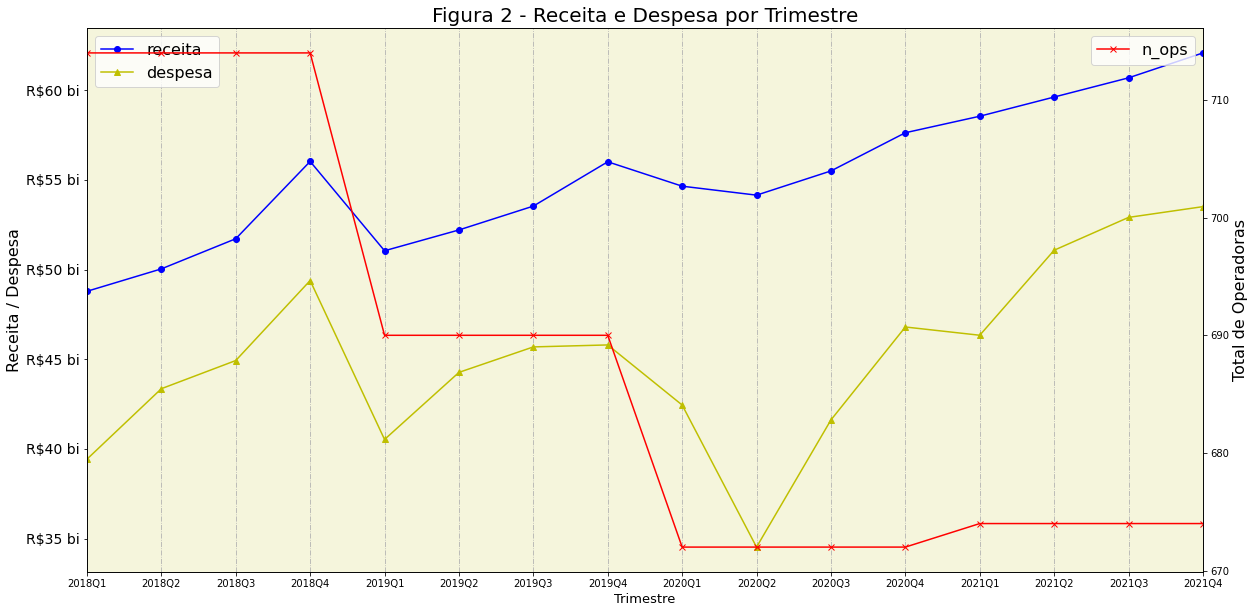

In [57]:
df_plot = diops_tcc_analise25.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('visao_geral.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

In [58]:
#Cria o rankin das operadoras com maior receita e despesa
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                         'despesa':lambda x: sum_billion(x)})

diops_tcc_analise16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

diops_tcc_analise16

ano  cd_ops  receita  despesa
709   2018    5711   22.230   19.290
185   2018  326305   19.990   16.780
711   2018    6246   15.470   12.130
414   2018  359017    5.590    6.700
509   2018  393321    5.510    4.780
...    ...     ...      ...      ...
2736  2021  422584    0.000    0.000
2737  2021  422614    0.000    0.000
2740  2021  422720    0.000    0.000
2741  2021  422754    0.000    0.000
2742  2021  422762    0.000    0.000

[2750 rows x 4 columns]

In [59]:
diops_tcc_trimestral_ops = diops_tcc_analise16.head(100)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops']].reset_index(drop=True)

keys = list(diops_tcc_trimestral_ops.columns.values)
i1 = diops_tcc_analise24.set_index(keys).index
i2 = diops_tcc_trimestral_ops.set_index(keys).index

diops_tcc_analise25 =  diops_tcc_analise24[i1.isin(i2)]

diops_tcc_analise25.sort_values(by=['receita'], ascending=False, inplace=True)

diops_tcc_analise25.head()

ano cd_ops trimestre        receita        despesa
9950  2021   5711    2021Q4 6949369996.220 6381595012.610
9951  2021   5711    2021Q3 6776296671.760 6329774938.060
9952  2021   5711    2021Q2 6722286604.220 6100189595.320
9953  2021   5711    2021Q1 6661933042.600 5771245701.700
7204  2020   5711    2020Q4 6546387457.780 5747678390.500

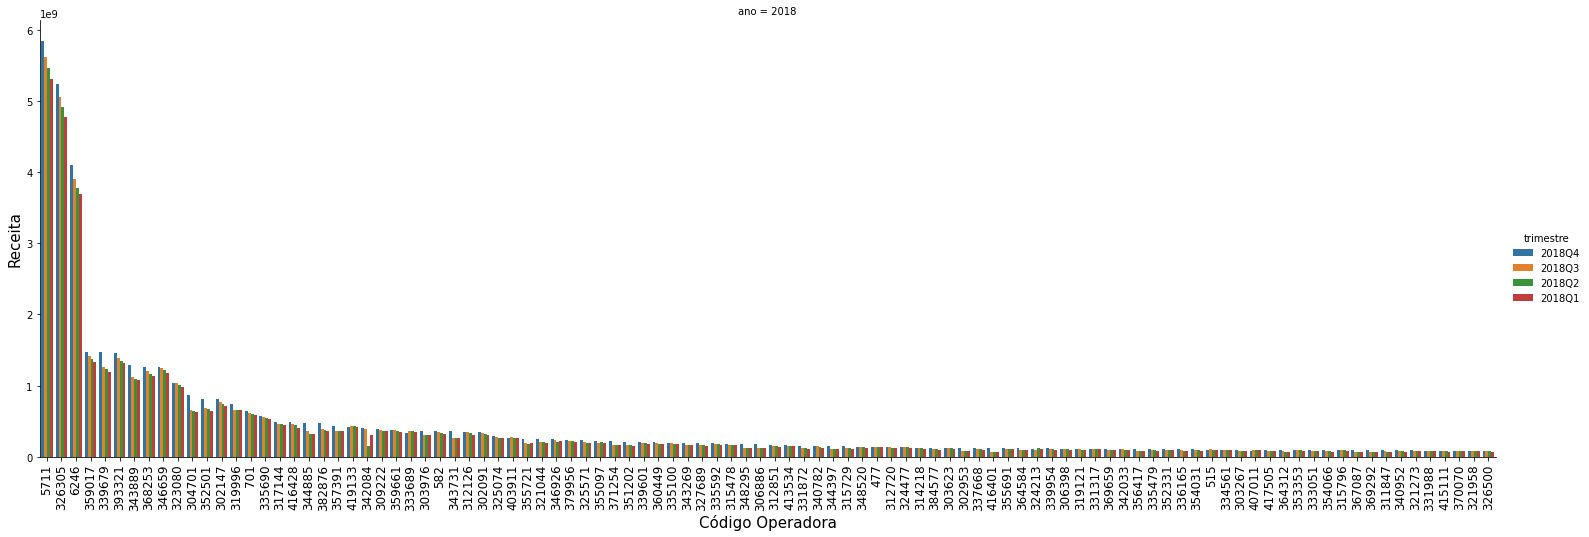

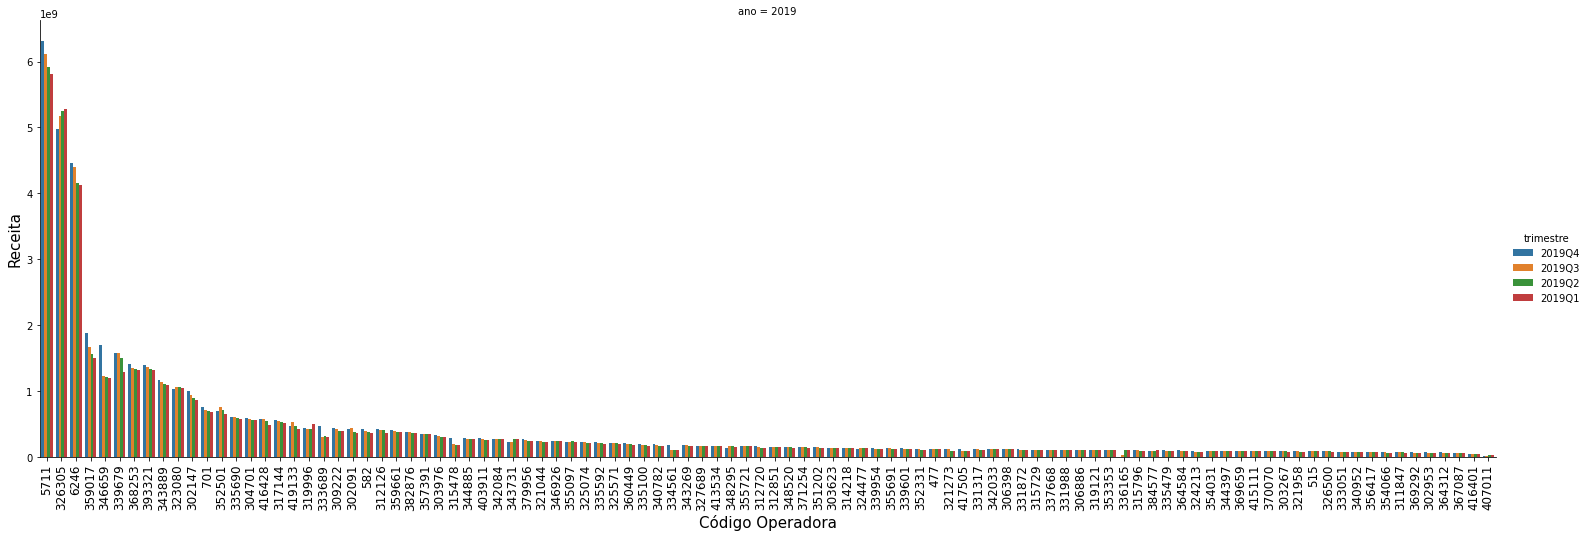

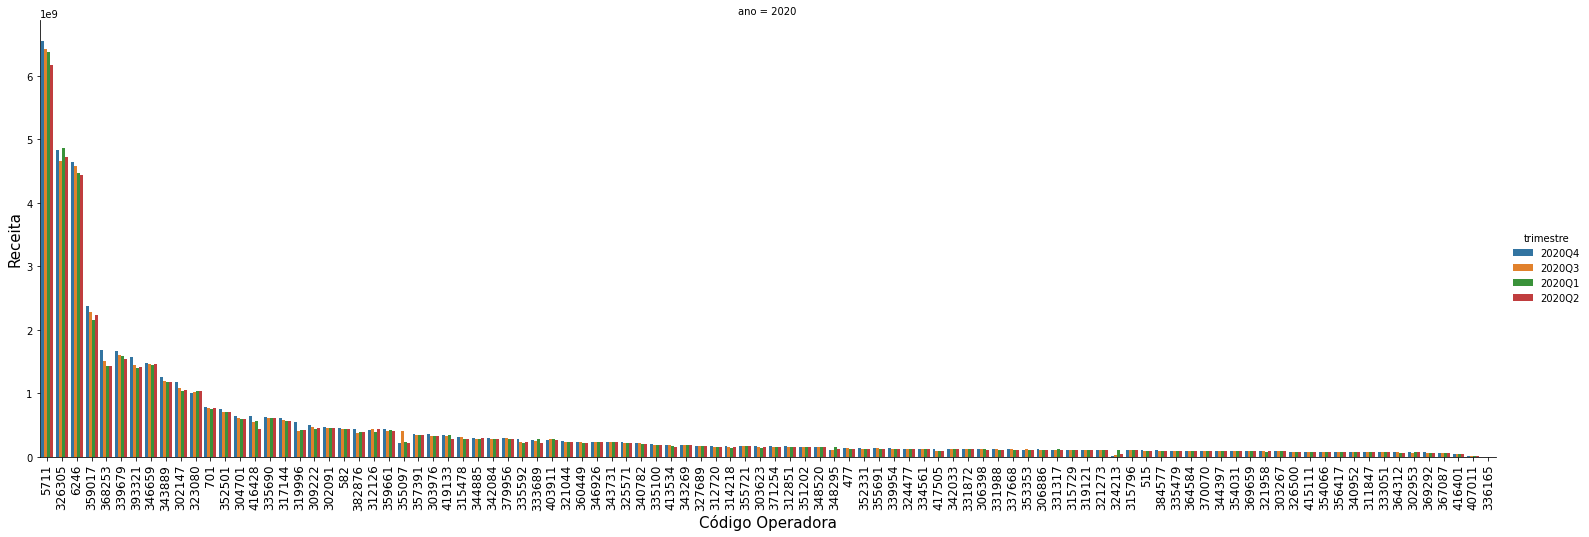

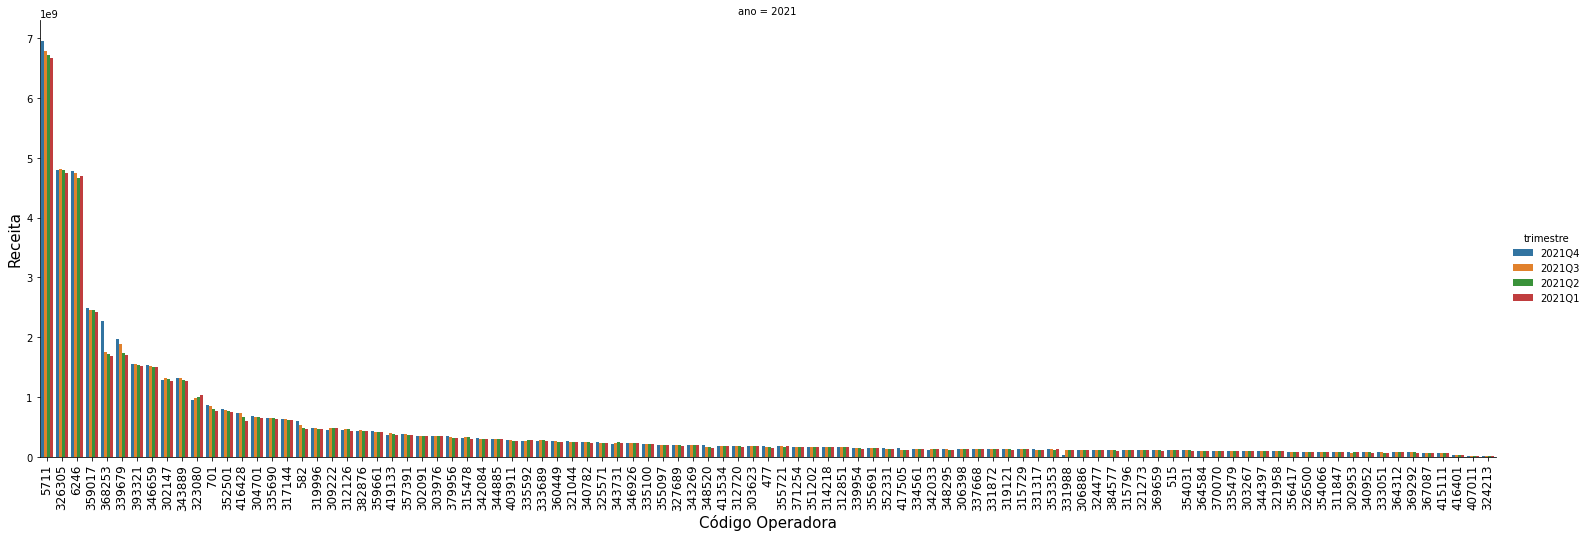

In [60]:
df_plot = diops_tcc_analise25.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

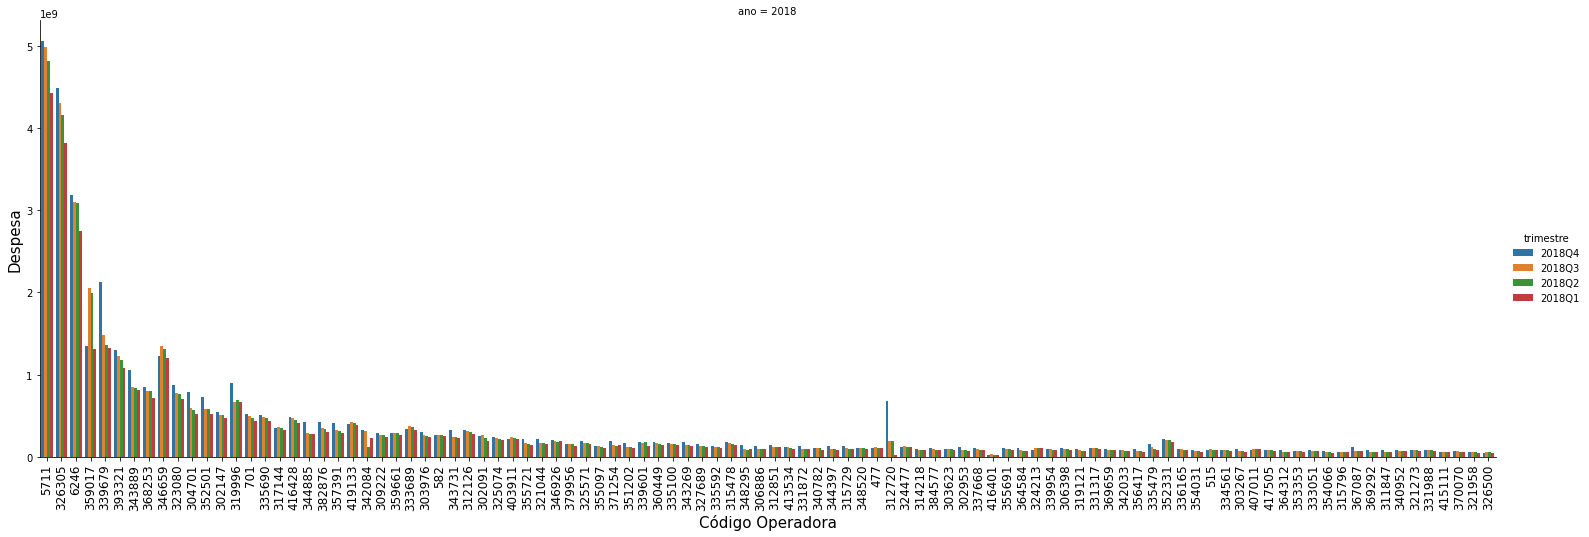

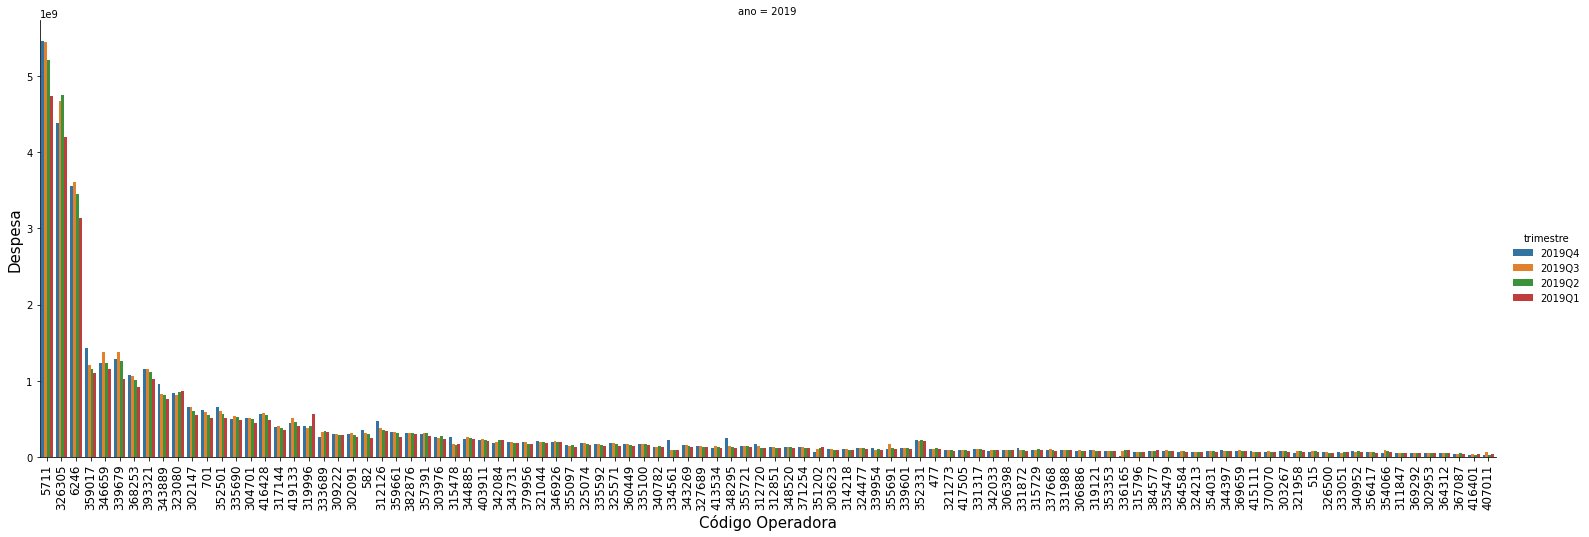

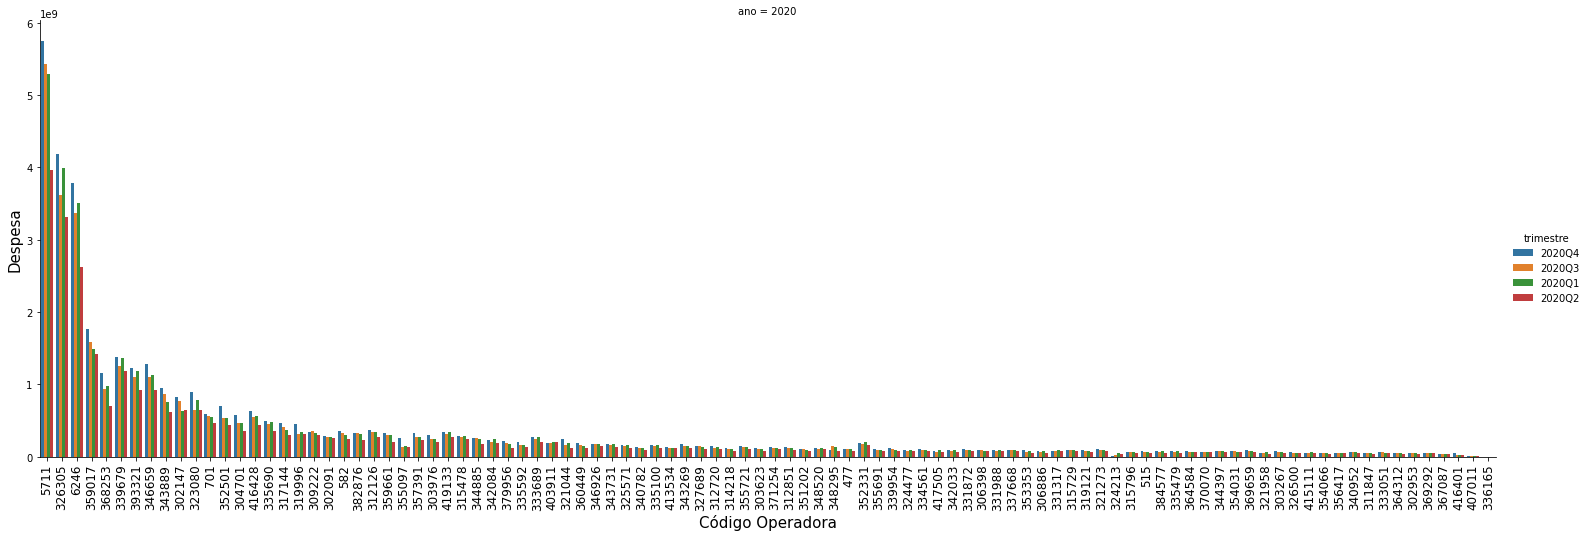

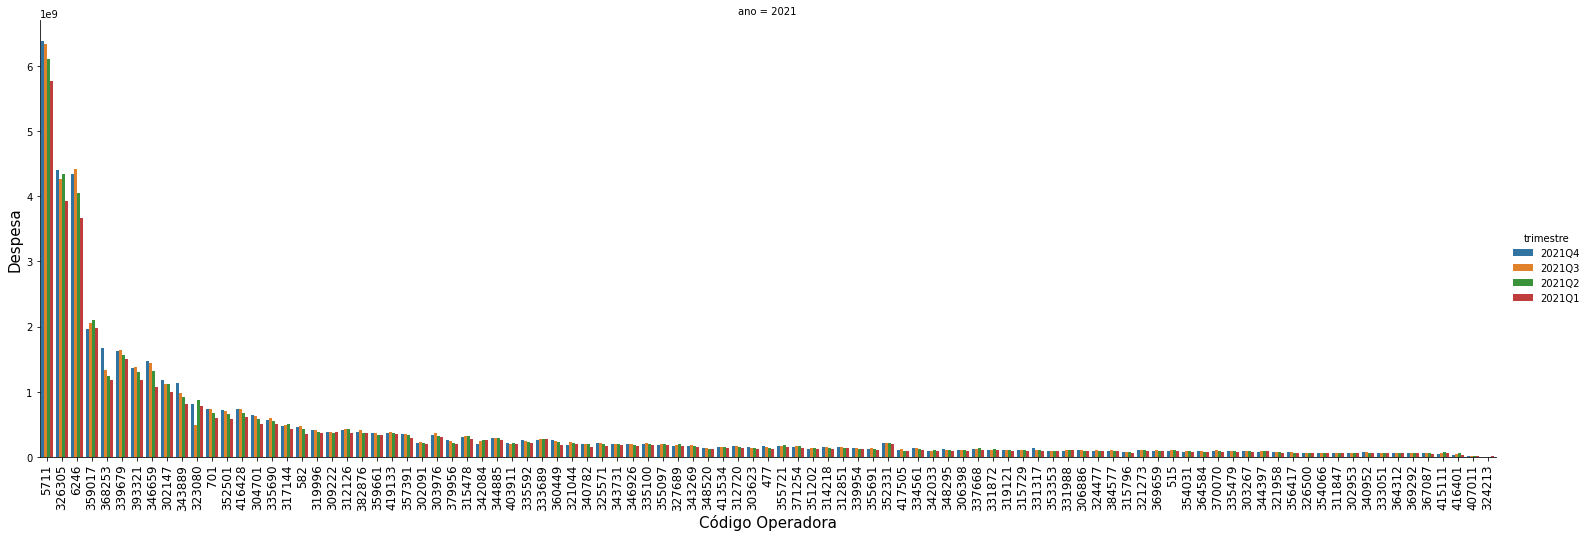

In [61]:
df_plot = diops_tcc_analise25.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [62]:
#############################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas trimestre a trimestre resumidas 

diops_tcc_trimestral = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                        'despesa':lambda x: sum_billion(x),
                                                                                                                                        'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral['pct_despesa'] = diops_tcc_trimestral.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral = diops_tcc_trimestral[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral = diops_tcc_trimestral[diops_tcc_trimestral['trimestre'] >= '2018Q1']

diops_tcc_trimestral.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '05-diops_trimestral_tcc_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral.set_index('trimestre', inplace=True)

diops_tcc_trimestral

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      45.810   35.970    700       78.520
2018Q2      49.610   41.180    708       83.010
2018Q3      50.030   44.320    709       88.590
2018Q4      61.130   55.650    707       91.040
2019Q1      50.580   40.210    688       79.500
2019Q2      51.420   43.600    686       84.790
2019Q3      54.840   46.760    686       85.270
2019Q4      55.970   45.740    688       81.720
2020Q1      54.590   42.430    673       77.720
2020Q2      54.380   34.700    673       63.810
2020Q3      55.450   41.580    660       74.990
2020Q4      57.500   46.720    672       81.250
2021Q1      57.870   45.800    661       79.140
2021Q2      58.750   50.020    671       85.140
2021Q3      59.220   51.700    669       87.300
2021Q4      65.120   56.340    672       86.520
2022Q1      58.220   48.940    662       84.060

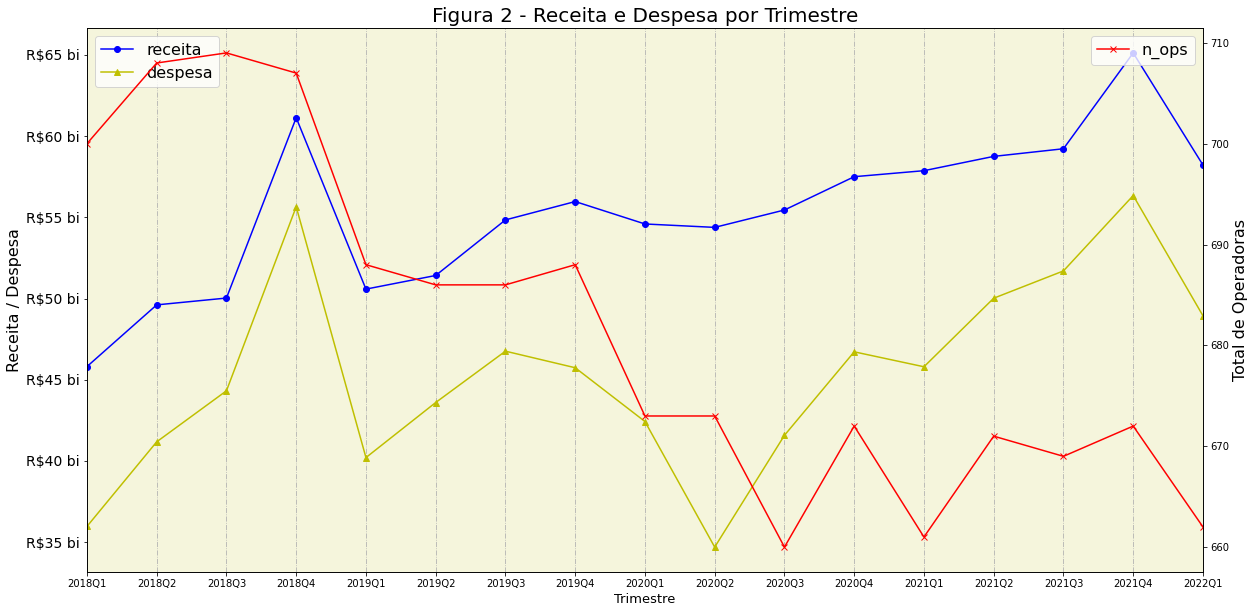

In [63]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral.index)
ax1.set_xticklabels(diops_tcc_trimestral.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

diops_tcc_trimestral.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral.index)
ax2.set_xticklabels(diops_tcc_trimestral.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)


plt.show()

In [64]:
diops_tcc_trimestral_ops = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                         'despesa': 'sum'})

diops_tcc_trimestral_ops['receita'] = diops_tcc_trimestral_ops['receita'].apply(np.floor)

diops_tcc_trimestral_ops['despesa'] = diops_tcc_trimestral_ops['despesa'].apply(np.floor)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[(diops_tcc_trimestral_ops['receita'] != 0) & (diops_tcc_trimestral_ops['despesa'] != 0)]

diops_tcc_trimestral_ops['ano'] = diops_tcc_trimestral_ops['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops','ano','trimestre','receita','despesa']]

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[(diops_tcc_trimestral_ops['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops['trimestre'] < '2022Q1') ]

diops_tcc_trimestral_ops.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops.head()

cd_ops   ano trimestre        receita        despesa
12334   5711  2021    2021Q4 6949369996.000 6381595012.000
12333   5711  2021    2021Q3 6776296671.000 6329774938.000
12332   5711  2021    2021Q2 6722286604.000 6100189595.000
12331   5711  2021    2021Q1 6661933042.000 5771245701.000
9661    5711  2020    2020Q4 6546387457.000 5747678390.000

In [65]:
diops_tcc_trimestral_ops_top = diops_tcc_trimestral_ops.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_top = diops_tcc_trimestral_ops_top[['ano','trimestre','cd_ops','receita','despesa']]

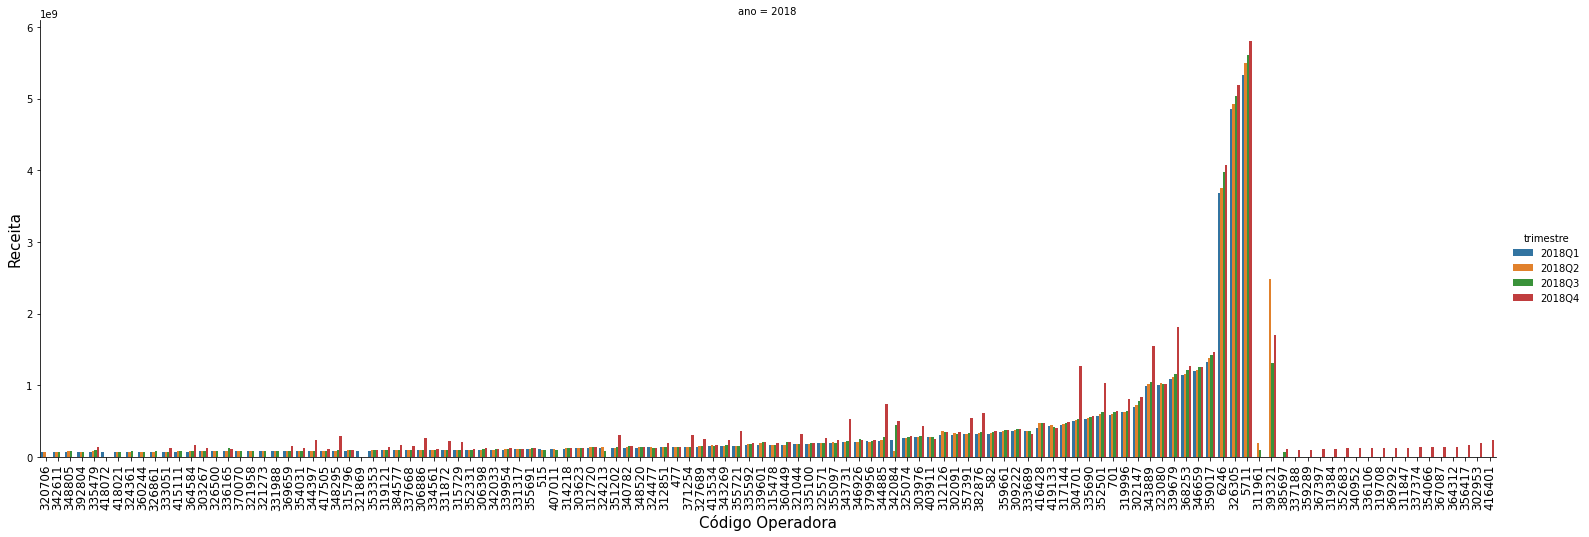

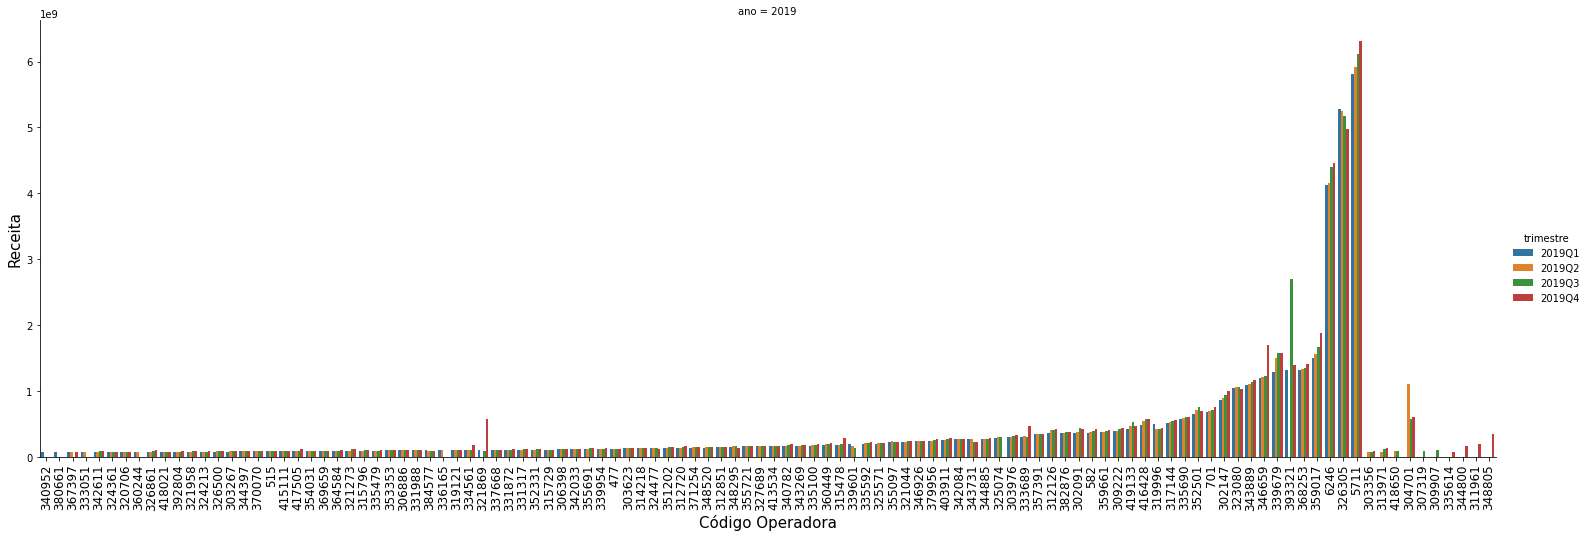

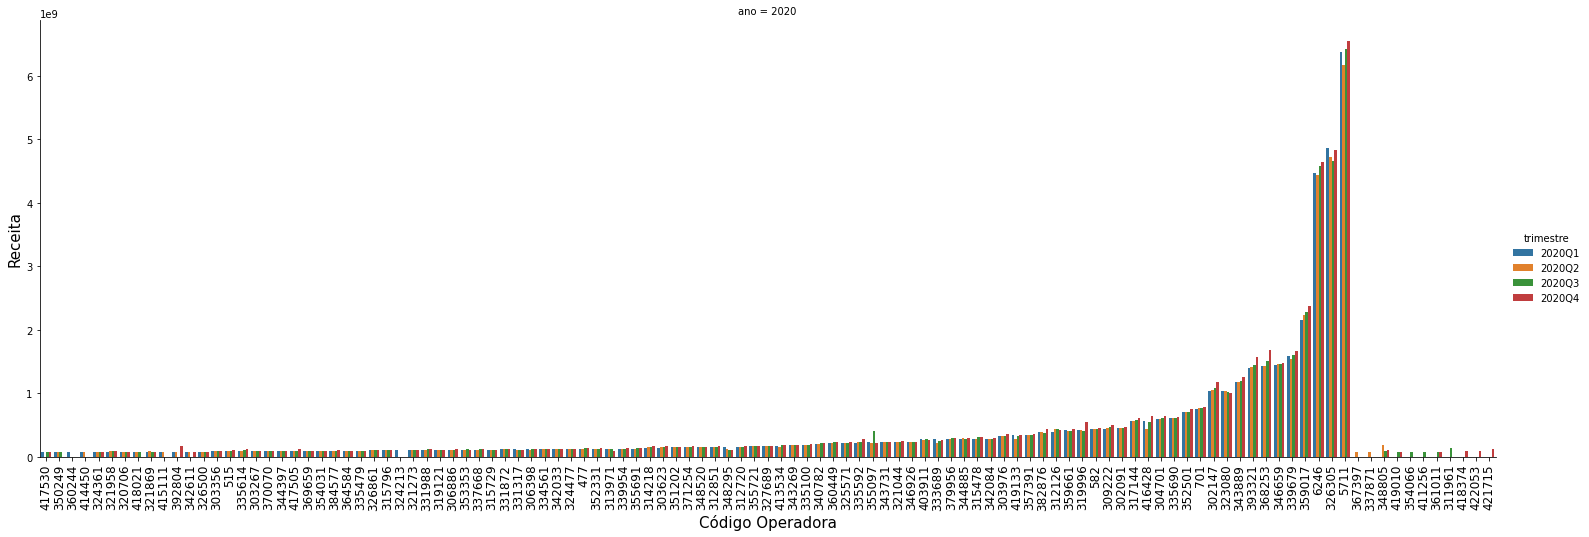

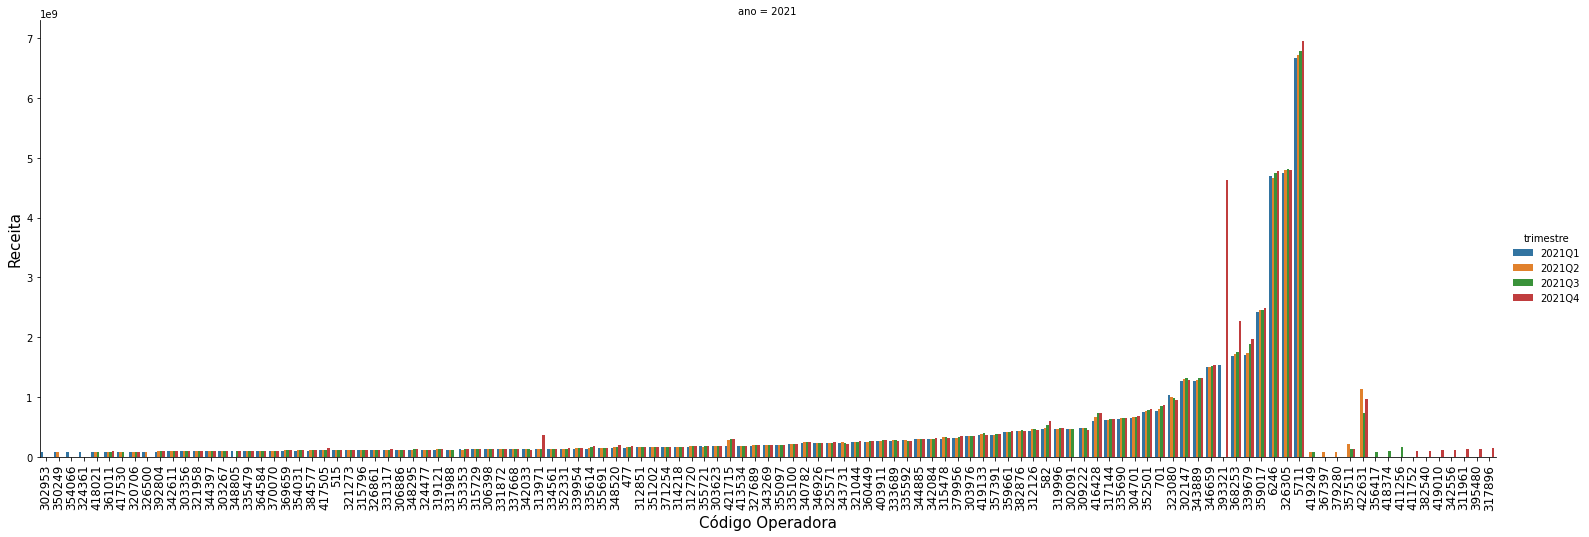

In [66]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

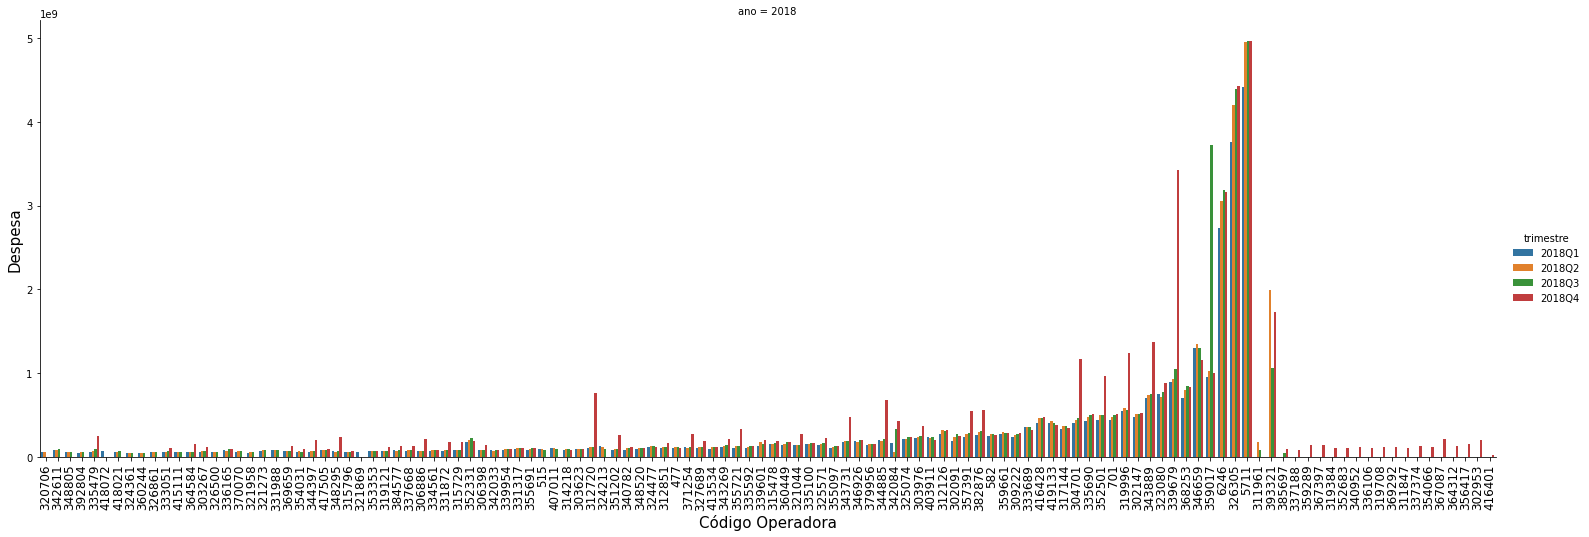

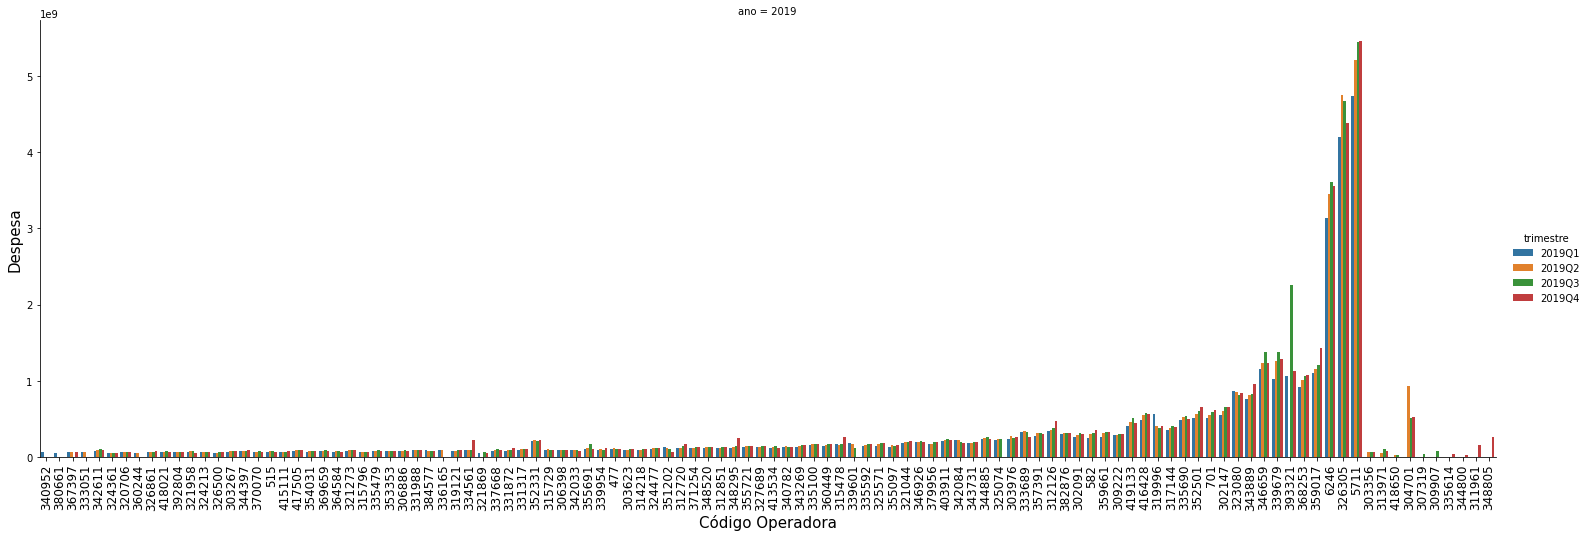

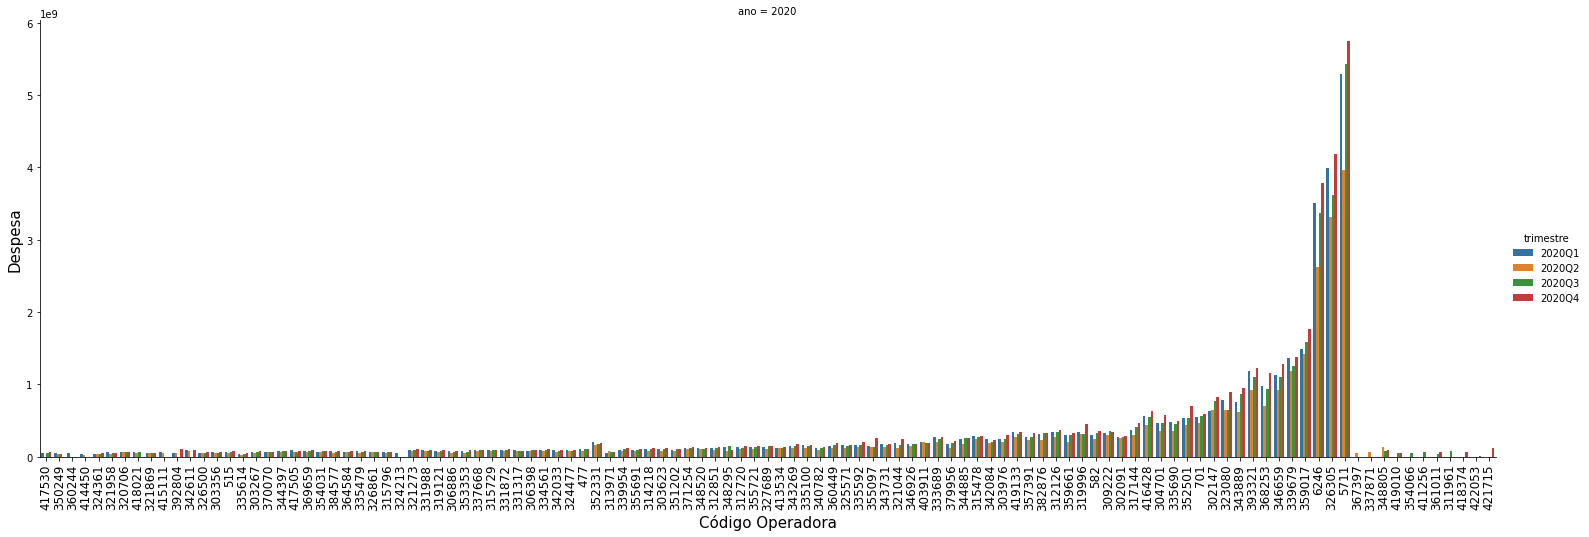

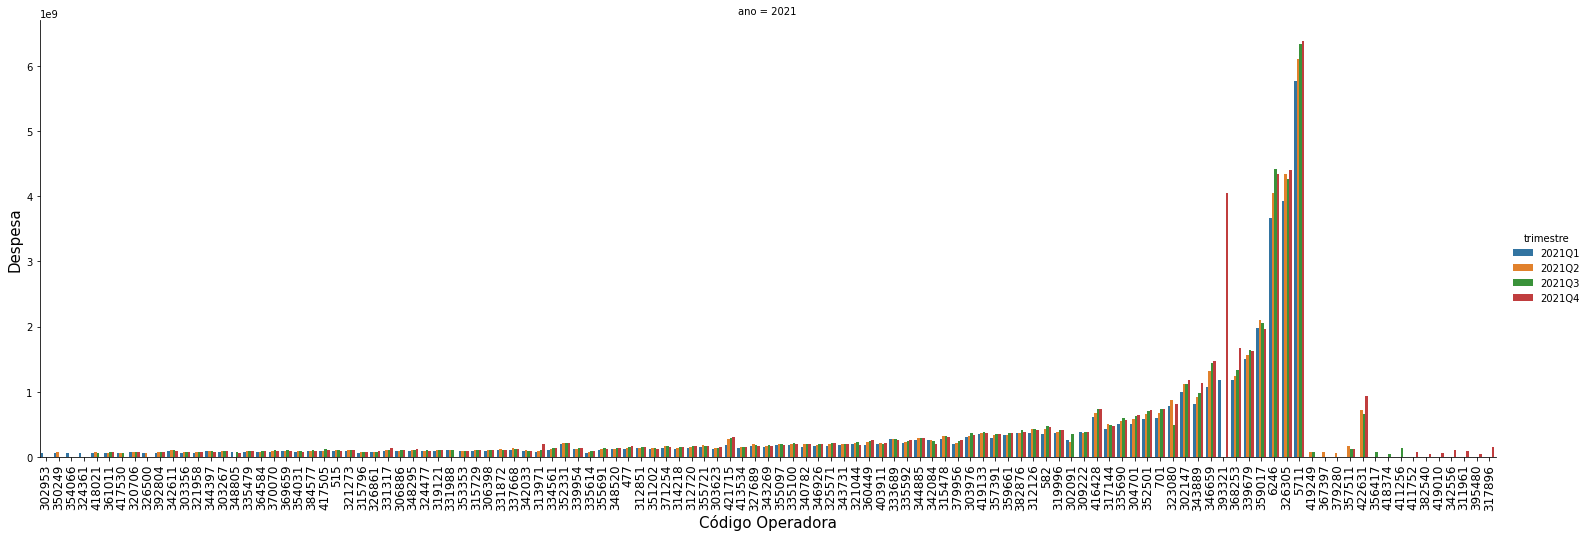

In [67]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato

In [68]:
diops_tcc_trimestral_cont = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao', 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                                                'despesa':lambda x: sum_billion(x),
                                                                                                                                                                'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_cont['pct_despesa'] = diops_tcc_trimestral_cont.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_cont.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_cont = diops_tcc_trimestral_cont[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_cont = diops_tcc_trimestral_cont[diops_tcc_trimestral_cont['trimestre'] >= '2018Q1']

diops_tcc_trimestral_cont.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '06-diops_contrato_trimestral_tcc_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_cont.set_index('trimestre', inplace=True)

In [69]:
diops_tcc_trimestral_ops_cont = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                                                    'despesa': 'sum'})

diops_tcc_trimestral_ops_cont['receita'] = diops_tcc_trimestral_ops_cont['receita'].apply(np.floor)

diops_tcc_trimestral_ops_cont['despesa'] = diops_tcc_trimestral_ops_cont['despesa'].apply(np.floor)

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['receita'] != 0) & (diops_tcc_trimestral_ops_cont['despesa'] != 0)]

diops_tcc_trimestral_ops_cont['ano'] = diops_tcc_trimestral_ops_cont['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_cont['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_tcc_trimestral_ops_cont.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_cont.head(20)

ano trimestre  cd_ops  contratacao        receita        despesa
29538  2021    2021Q4    5711  Empresarial 6099863318.000 5424011841.000
29537  2021    2021Q3    5711  Empresarial 5882847948.000 5411391051.000
29536  2021    2021Q2    5711  Empresarial 5801113430.000 5184503155.000
29535  2021    2021Q1    5711  Empresarial 5718682544.000 4866206801.000
23113  2020    2020Q4    5711  Empresarial 5595989651.000 4887812065.000
23112  2020    2020Q3    5711  Empresarial 5559274169.000 4595205382.000
23110  2020    2020Q1    5711  Empresarial 5521062359.000 4493337744.000
16666  2019    2019Q4    5711  Empresarial 5428141145.000 4647909154.000
23111  2020    2020Q2    5711  Empresarial 5309975239.000 3279773337.000
16665  2019    2019Q3    5711  Empresarial 5294246731.000 4573904404.000
16664  2019    2019Q2    5711  Empresarial 5091005045.000 4435371788.000
16663  2019    2019Q1    5711  Empresarial 4996375831.000 3969251993.000
10100  2018    2018Q4    5711  Empresarial 4971094327.000 4186870168.000
10099  2018    2018Q3    5711  Empresarial 4839293015.000 4178454485.000
10098  2018    2018Q2    5711  Empresarial 4704475170.000 4167729812.000
10097  2018    2018Q1    5711  Empresarial 4555586885.000 3697839472.000
11972  2019    2019Q1  326305  Empresarial 3721479328.000 2718277001.000
11973  2019    2019Q2  326305  Empresarial 3713061652.000 3093437964.000
5286   2018    2018Q4  326305  Empresarial 3631331535.000 2881299808.000
11974  2019    2019Q3  326305  Empresarial 3612301287.000 3015082749.000

## Adesão

In [70]:
df_tcc_trimestral_cont_ade = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Adesao')]
df_tcc_trimestral_cont_ade 

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1         Adesao    7.730    6.850    522       88.620
2018Q2         Adesao    8.730    7.870    528       90.150
2018Q3         Adesao    8.770    8.420    527       96.010
2018Q4         Adesao   11.130    7.570    538       68.010
2019Q1         Adesao    7.840    6.290    527       80.230
2019Q2         Adesao    7.420    6.500    522       87.600
2019Q3         Adesao    8.930    7.290    526       81.630
2019Q4         Adesao    8.360    6.980    527       83.490
2020Q1         Adesao    8.130    6.320    514       77.740
2020Q2         Adesao    8.220    5.230    524       63.630
2020Q3         Adesao    8.580    6.400    525       74.590
2020Q4         Adesao    8.620    6.910    529       80.160
2021Q1         Adesao    8.770    6.890    519       78.560
2021Q2         Adesao    9.360    7.840    525       83.760
2021Q3         Adesao    9.120    8.010    527       87.830
2021Q4         Adesao   11.340   10.120    528       89.240
2022Q1         Adesao    8.950    7.560    524       84.470

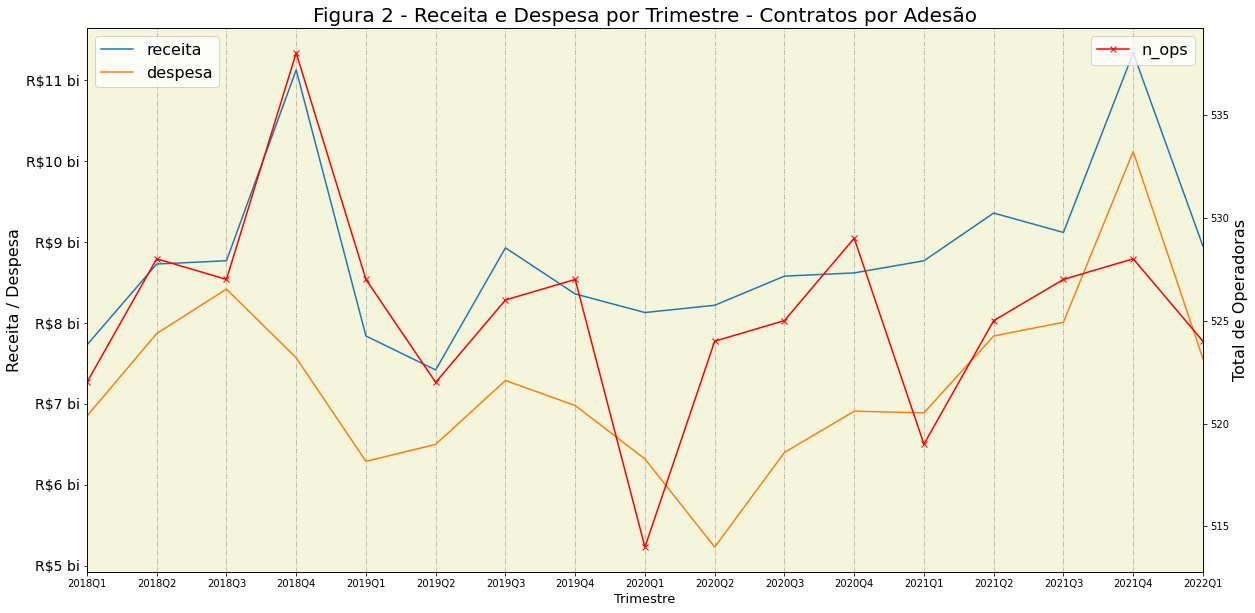

In [71]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_ade.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos por Adesão',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_ade.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_ade.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_ade.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_ade.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_ade.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [72]:
diops_tcc_trimestral_ops_cont_ade = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Adesao')] 

diops_tcc_trimestral_ops_cont_ade_top = diops_tcc_trimestral_ops_cont_ade.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_ade_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ade_top = diops_tcc_trimestral_ops_cont_ade_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ade_top.head()

ano trimestre  cd_ops      receita      despesa
1599  2018    2018Q1  363766 10920217.000  6031647.000
1598  2018    2018Q1  326500 10954957.000  8626836.000
1597  2018    2018Q1  367087 11227328.000  7117581.000
1595  2018    2018Q1  311375 11550261.000 13845389.000
1593  2018    2018Q1      27 11644624.000 13298916.000

### Receita

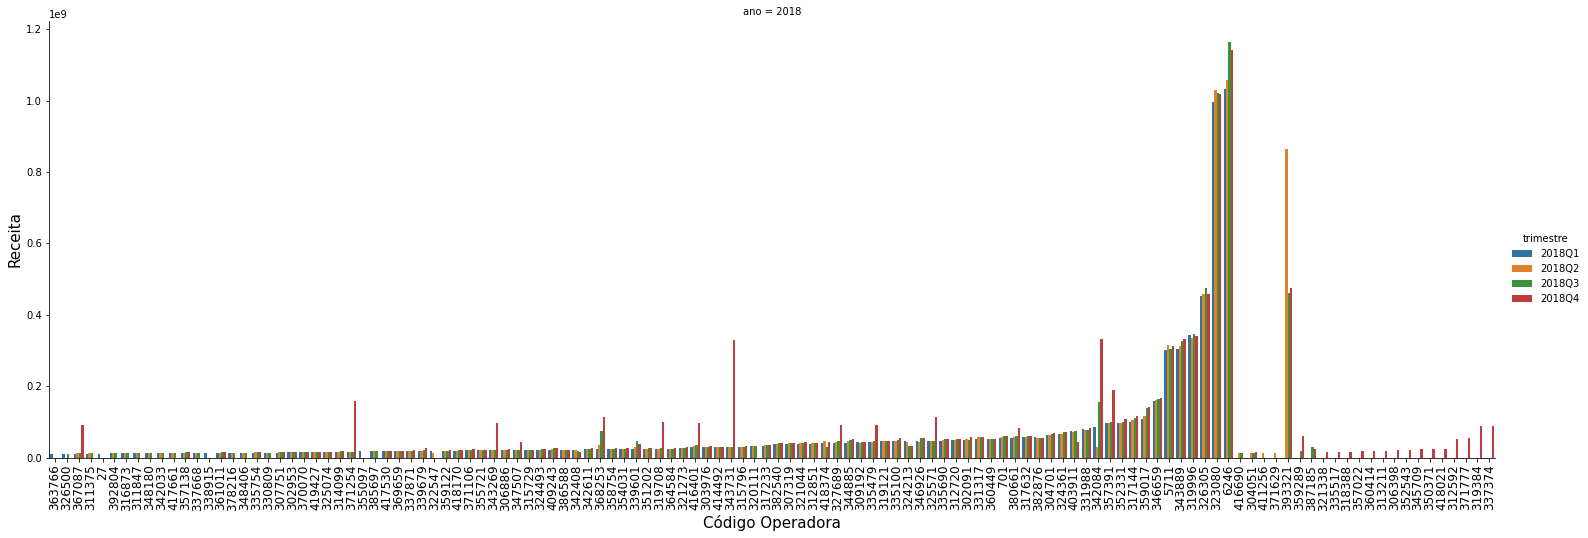

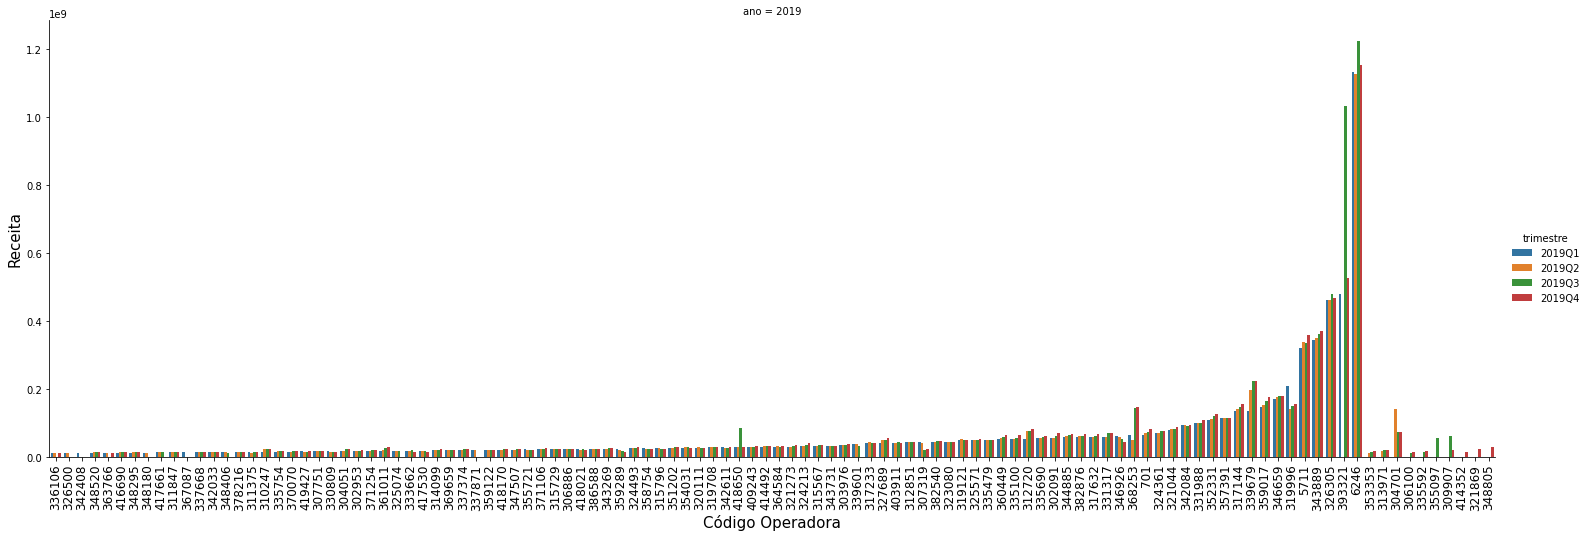

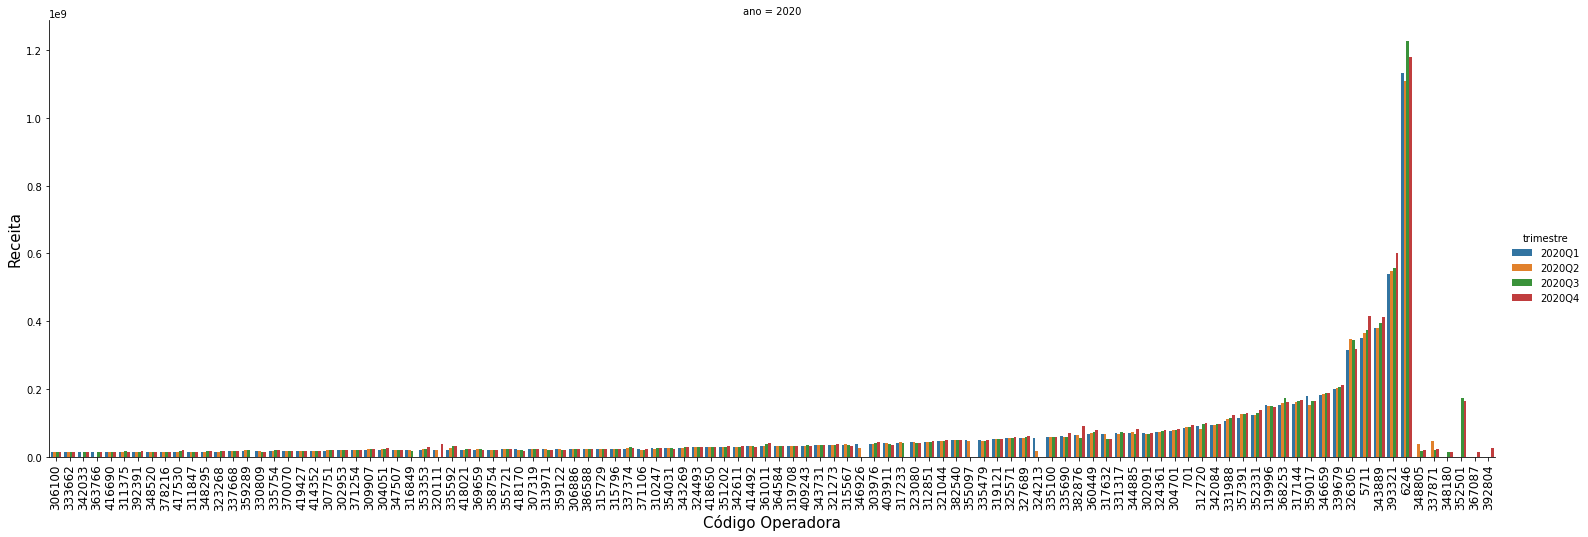

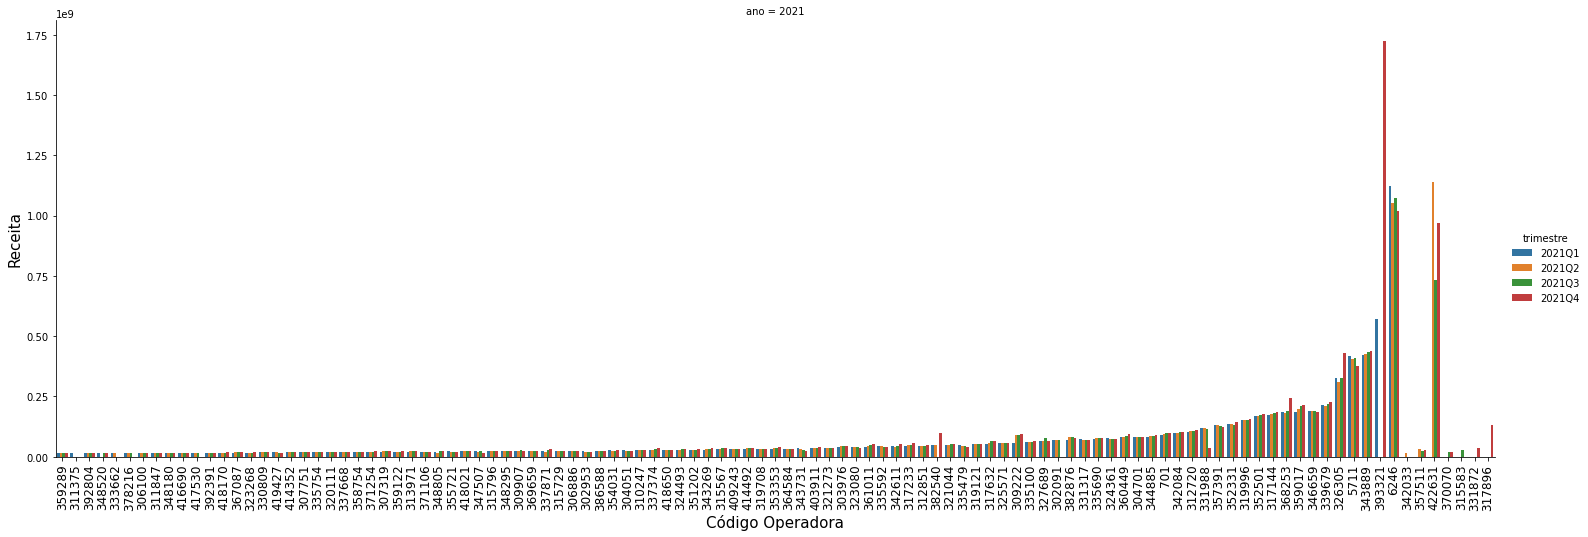

In [73]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Despesa

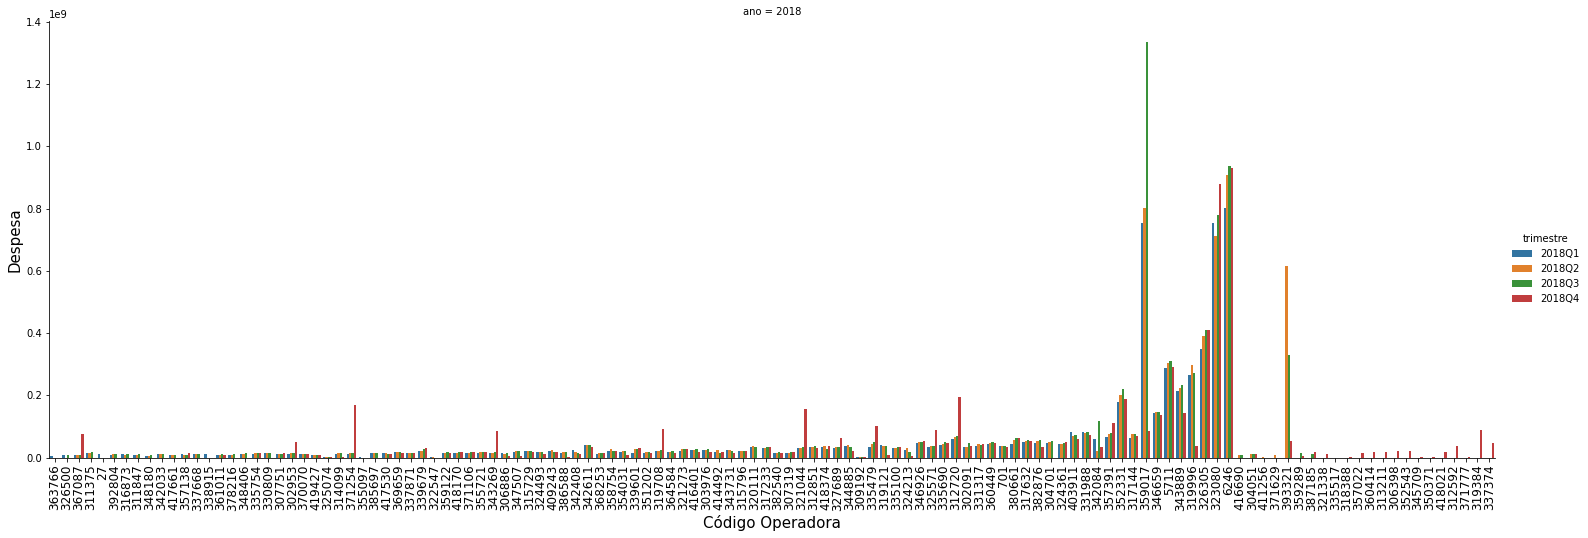

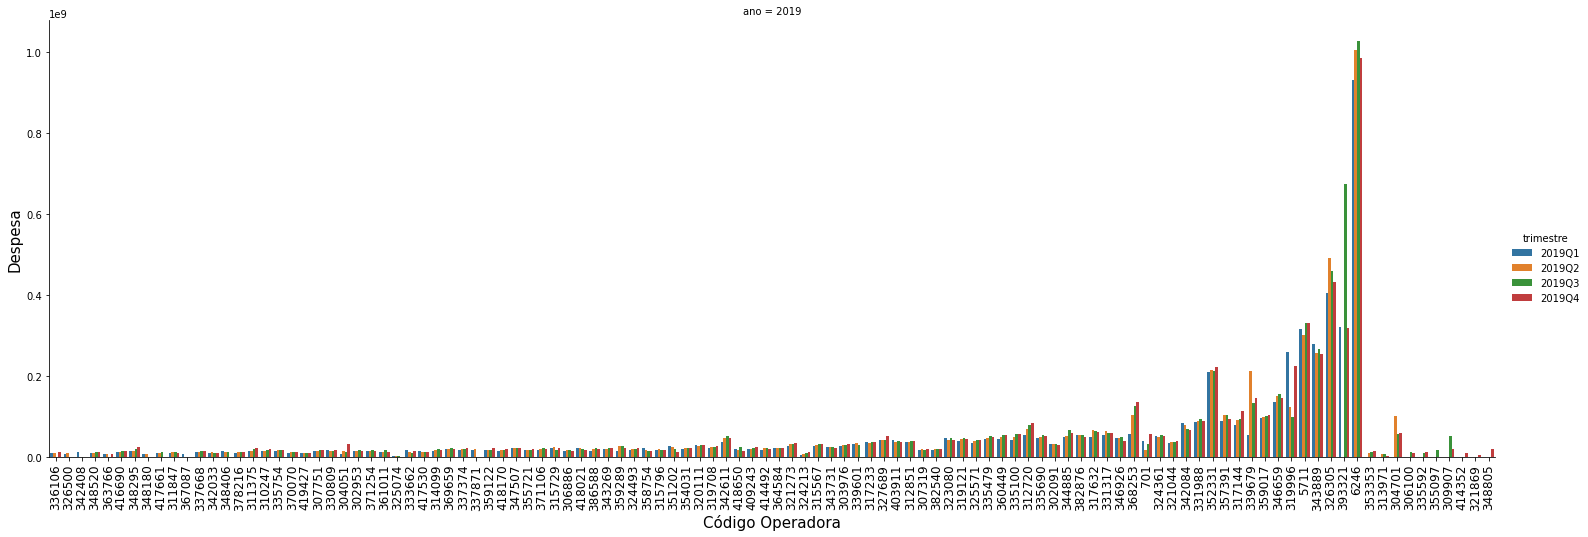

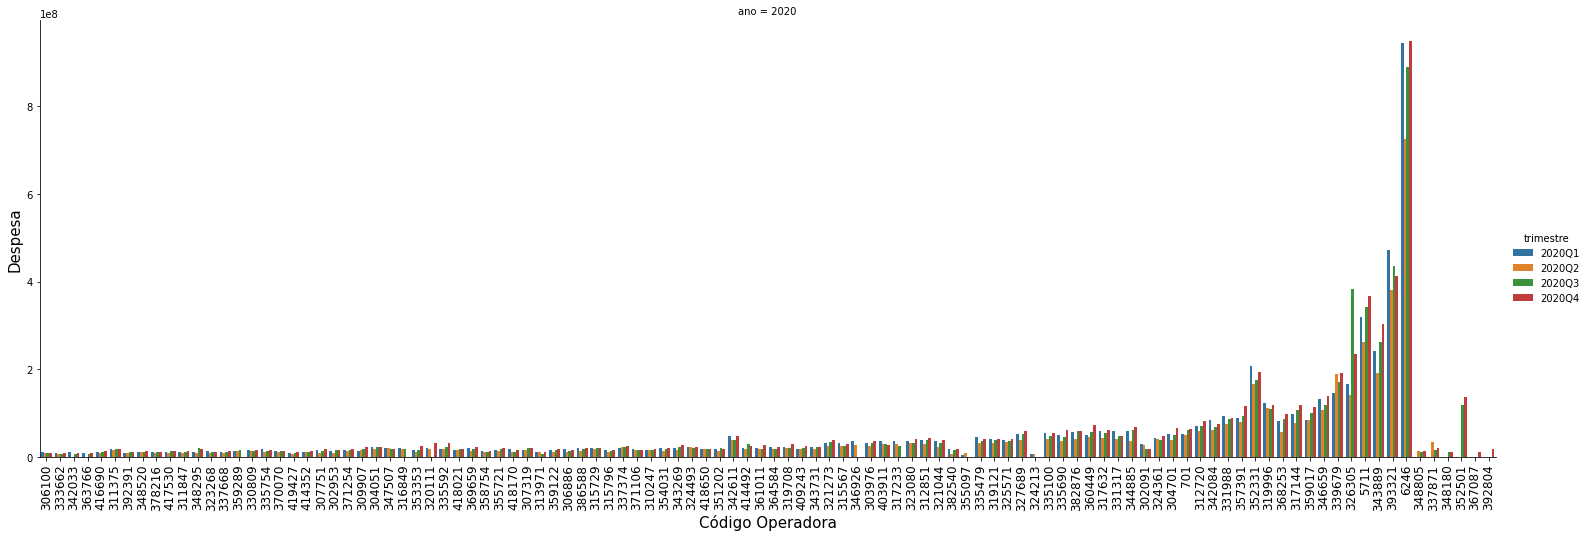

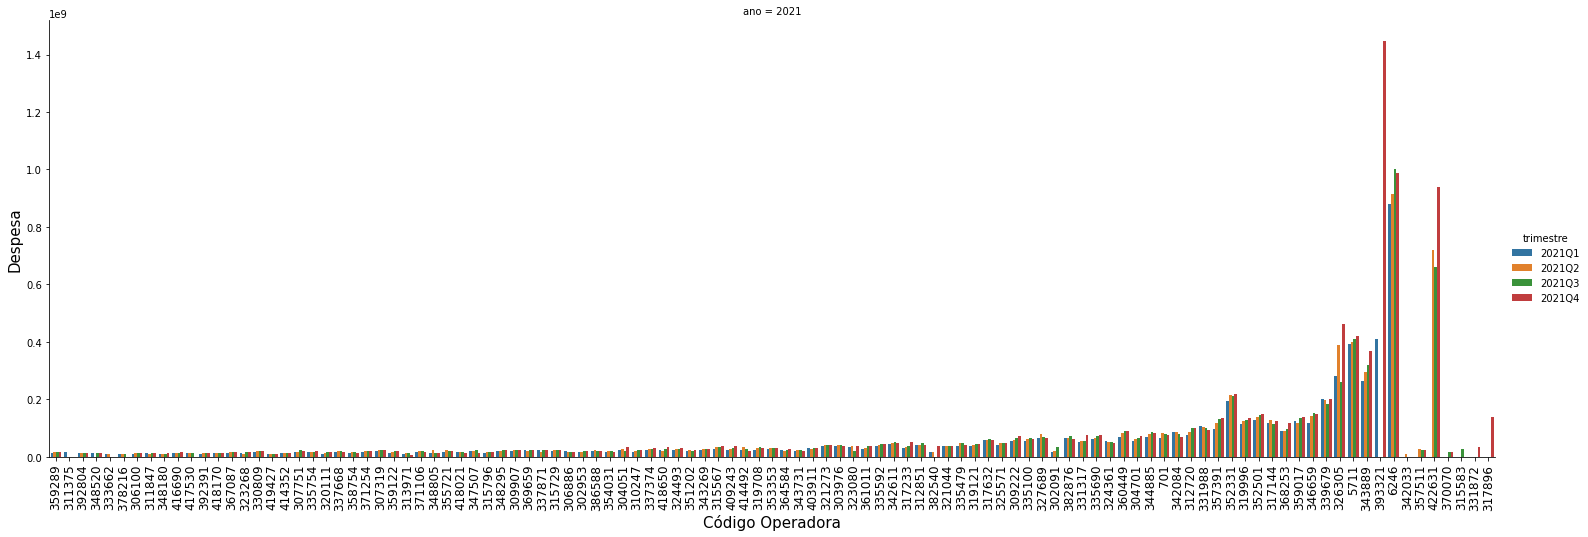

In [74]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial

In [75]:
df_tcc_trimestral_cont_emp = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Empresarial')]
df_tcc_trimestral_cont_emp 

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                   
2018Q1     Empresarial   27.280   20.770    595       76.140
2018Q2     Empresarial   28.780   23.280    600       80.890
2018Q3     Empresarial   29.350   25.660    603       87.430
2018Q4     Empresarial   37.640   29.440    597       78.210
2019Q1     Empresarial   30.840   24.530    594       79.540
2019Q2     Empresarial   31.840   26.980    596       84.740
2019Q3     Empresarial   32.980   28.260    592       85.690
2019Q4     Empresarial   34.480   28.070    593       81.410
2020Q1     Empresarial   33.510   26.420    576       78.840
2020Q2     Empresarial   33.160   21.130    579       63.720
2020Q3     Empresarial   33.630   25.600    574       76.120
2020Q4     Empresarial   34.970   29.140    582       83.330
2021Q1     Empresarial   35.160   28.440    572       80.890
2021Q2     Empresarial   35.750   31.380    579       87.780
2021Q3     Empresarial   36.740   32.380    579       88.130
2021Q4     Empresarial   39.100   32.980    577       84.350
2022Q1     Empresarial   36.090   29.440    576       81.570

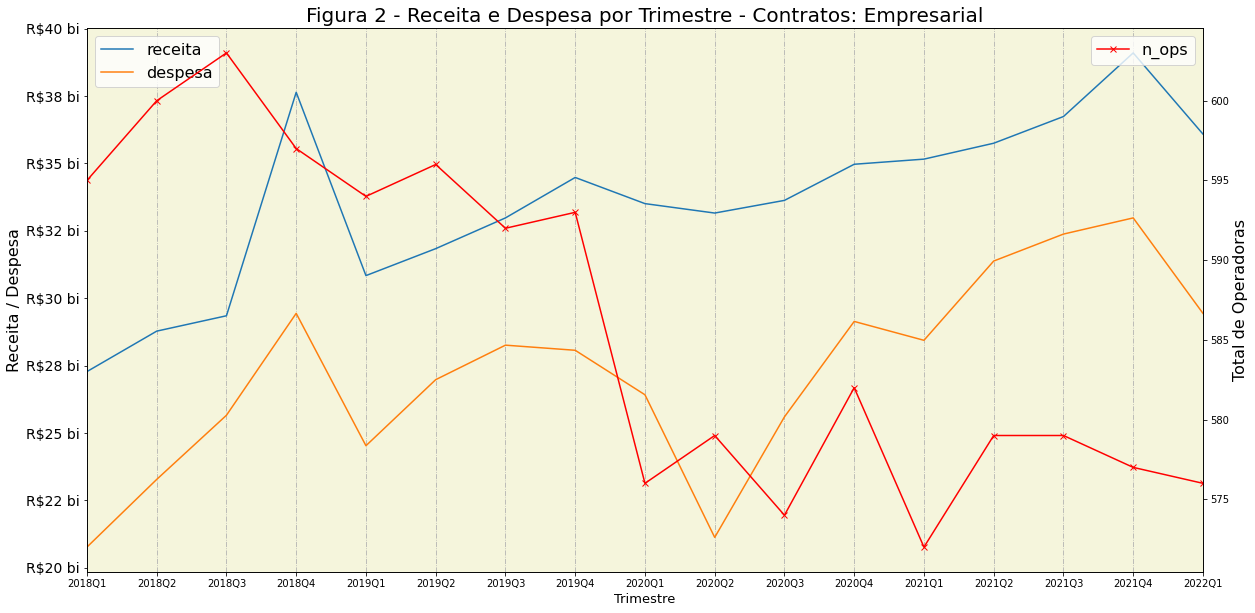

In [76]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_emp.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Empresarial',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_emp.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_emp.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_emp.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_emp.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_emp.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [77]:
diops_tcc_trimestral_ops_cont_emp = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Empresarial')] 

diops_tcc_trimestral_ops_cont_emp_top = diops_tcc_trimestral_ops_cont_emp.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_emp_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_emp_top = diops_tcc_trimestral_ops_cont_emp_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_emp_top.sort_values(by=['trimestre','receita'],ascending = False, inplace=True)

diops_tcc_trimestral_ops_cont_emp_top.head()

ano trimestre  cd_ops        receita        despesa
0   2021    2021Q4    5711 6099863318.000 5424011841.000
25  2021    2021Q4  326305 3402498391.000 2855945023.000
32  2021    2021Q4    6246 3244669747.000 2730546291.000
48  2021    2021Q4  359017 2027821695.000 1617229948.000
57  2021    2021Q4  339679 1656892089.000 1291624359.000

### Receita

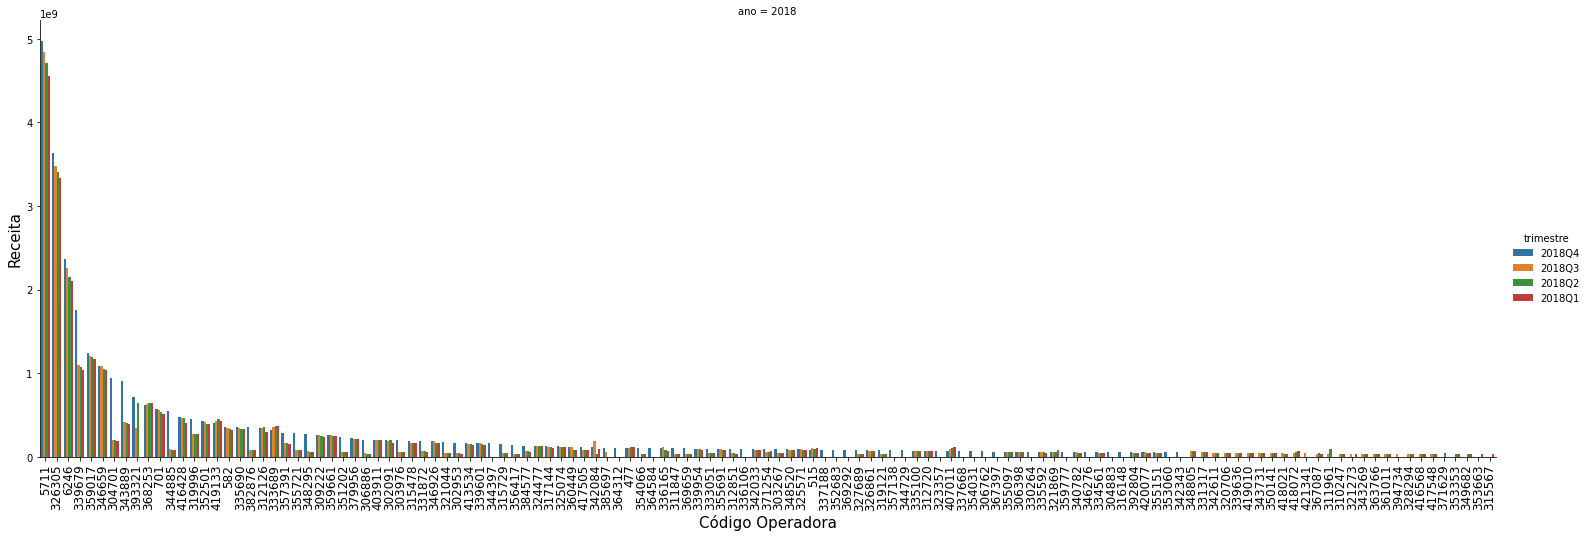

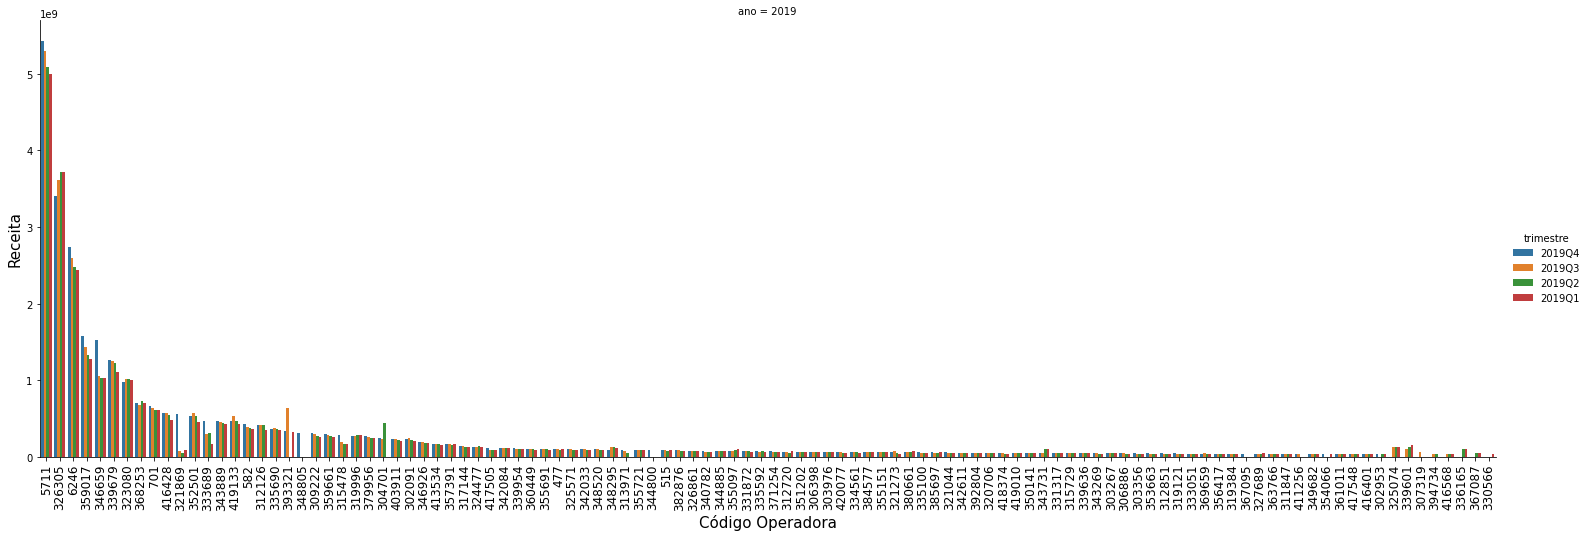

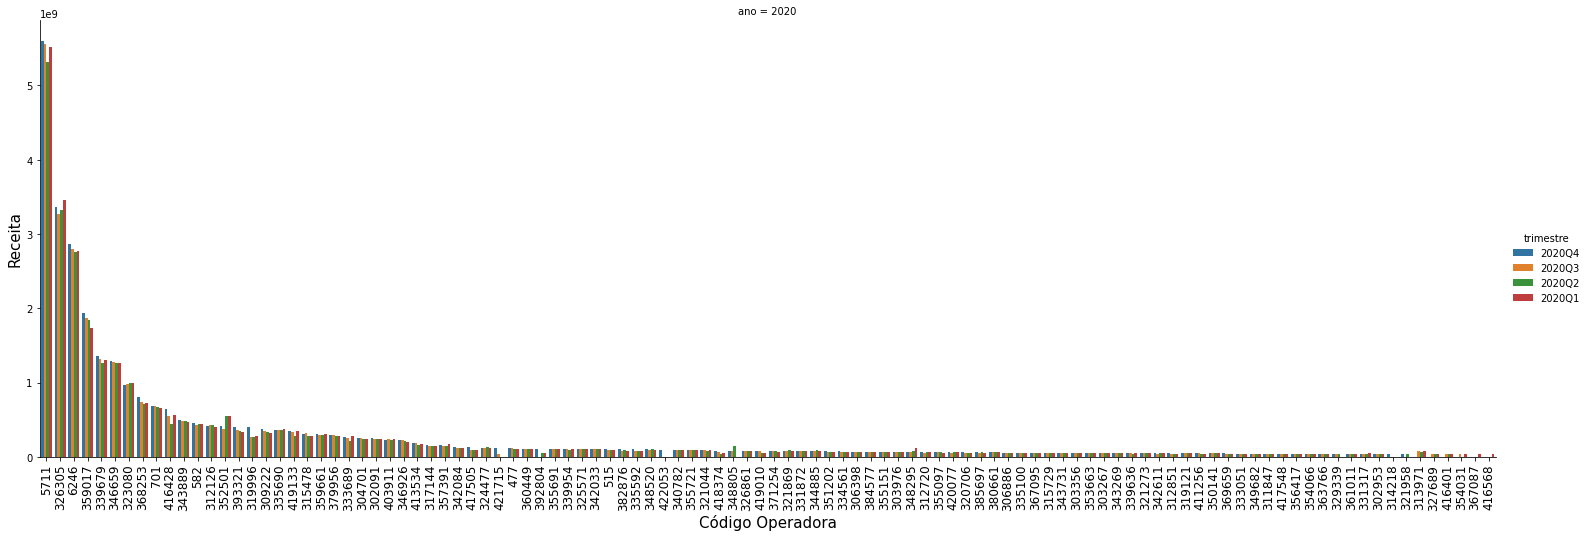

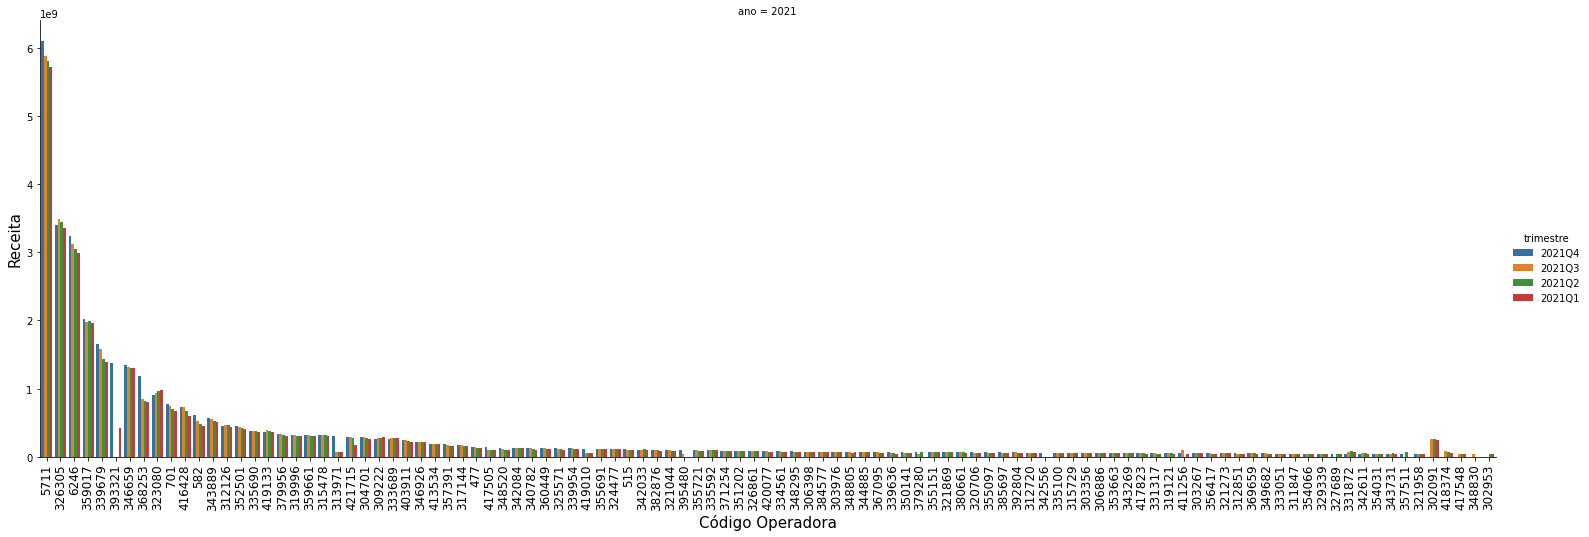

In [78]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Despesa

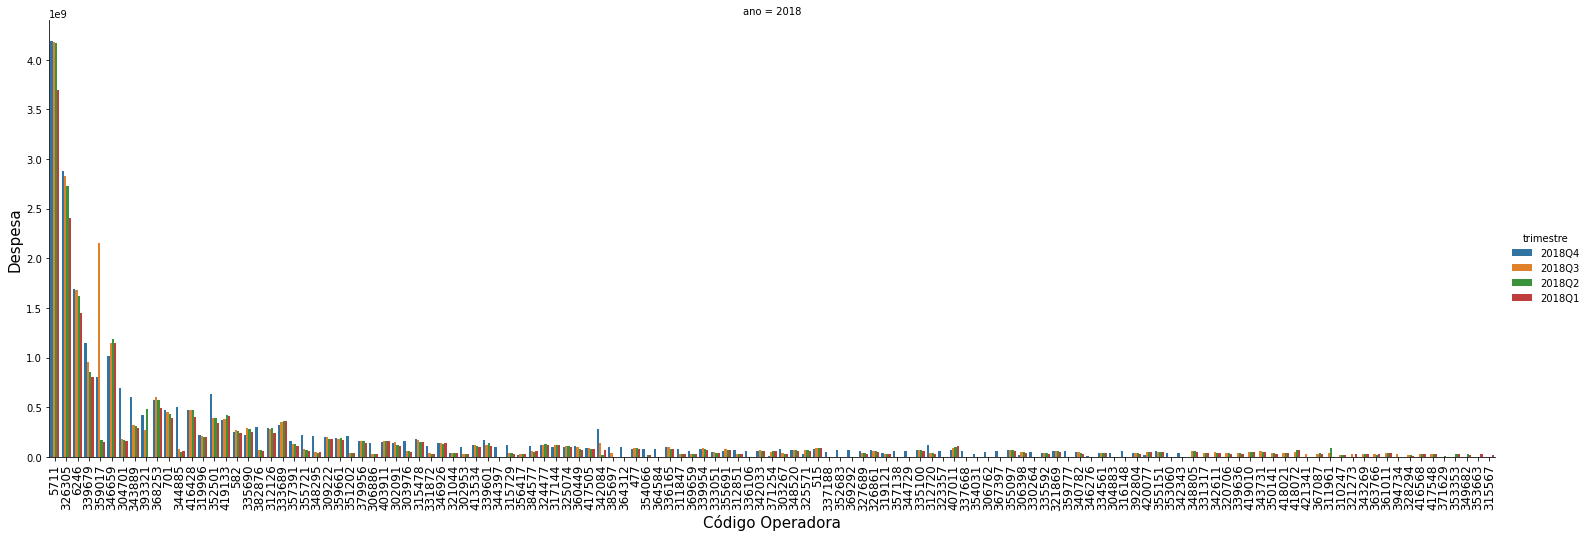

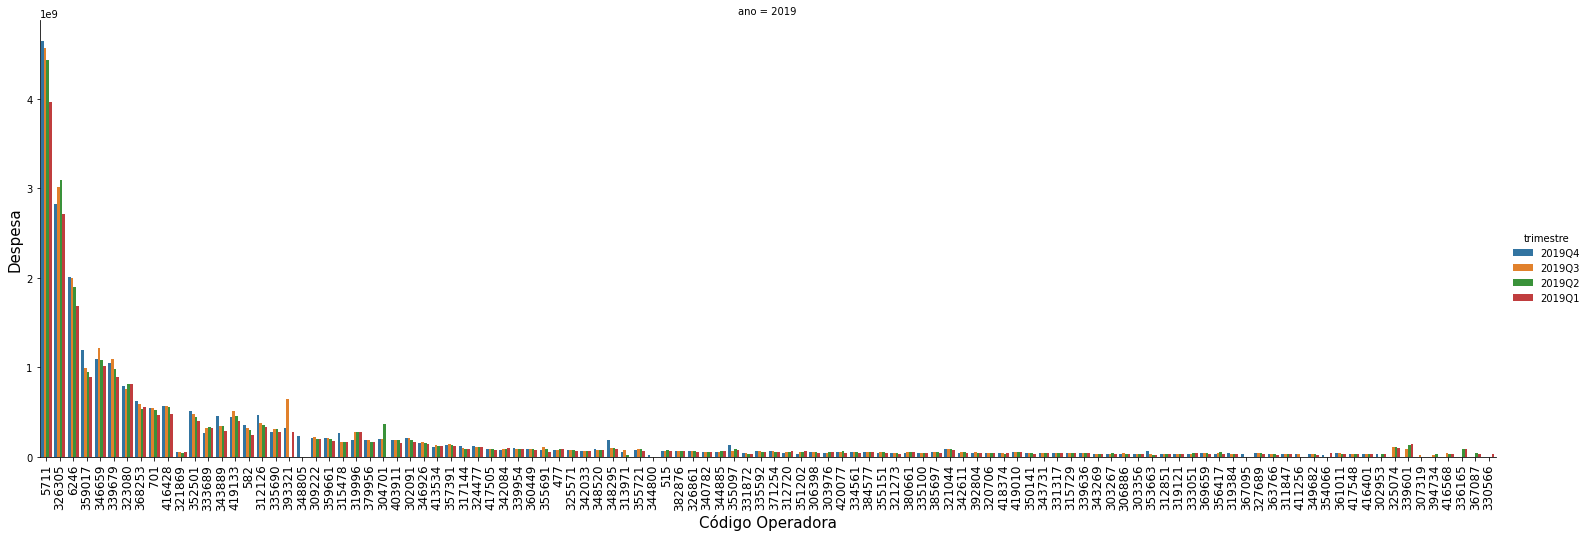

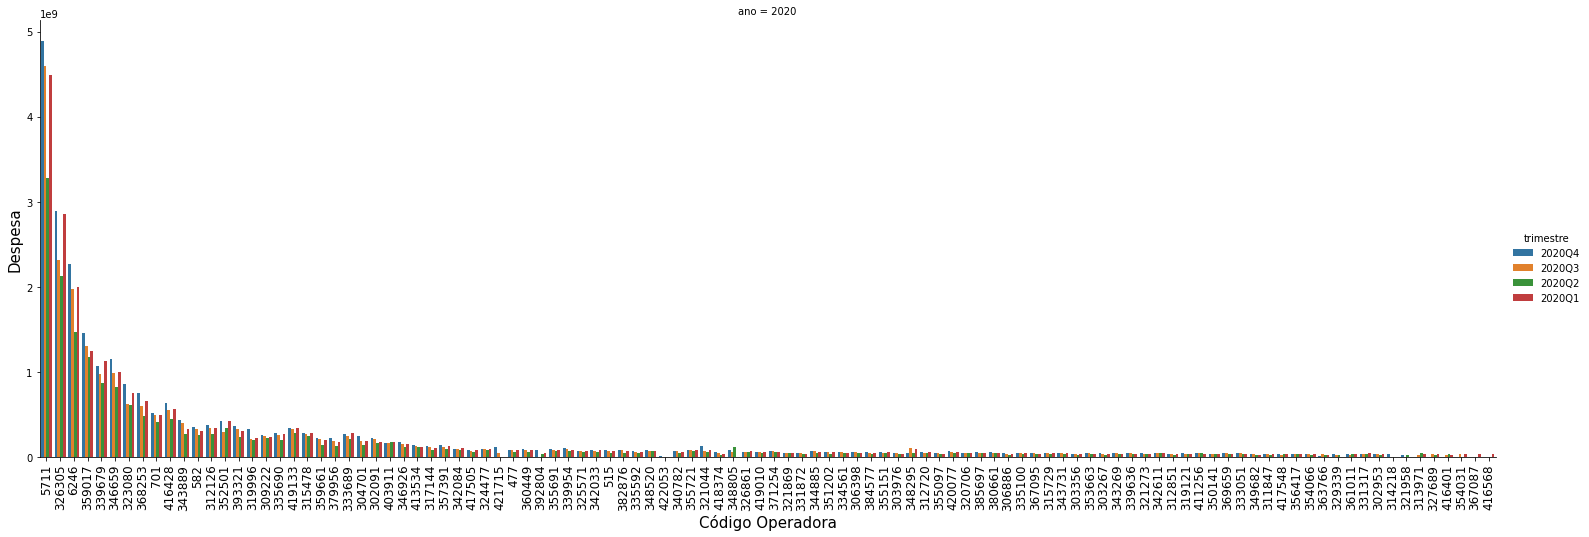

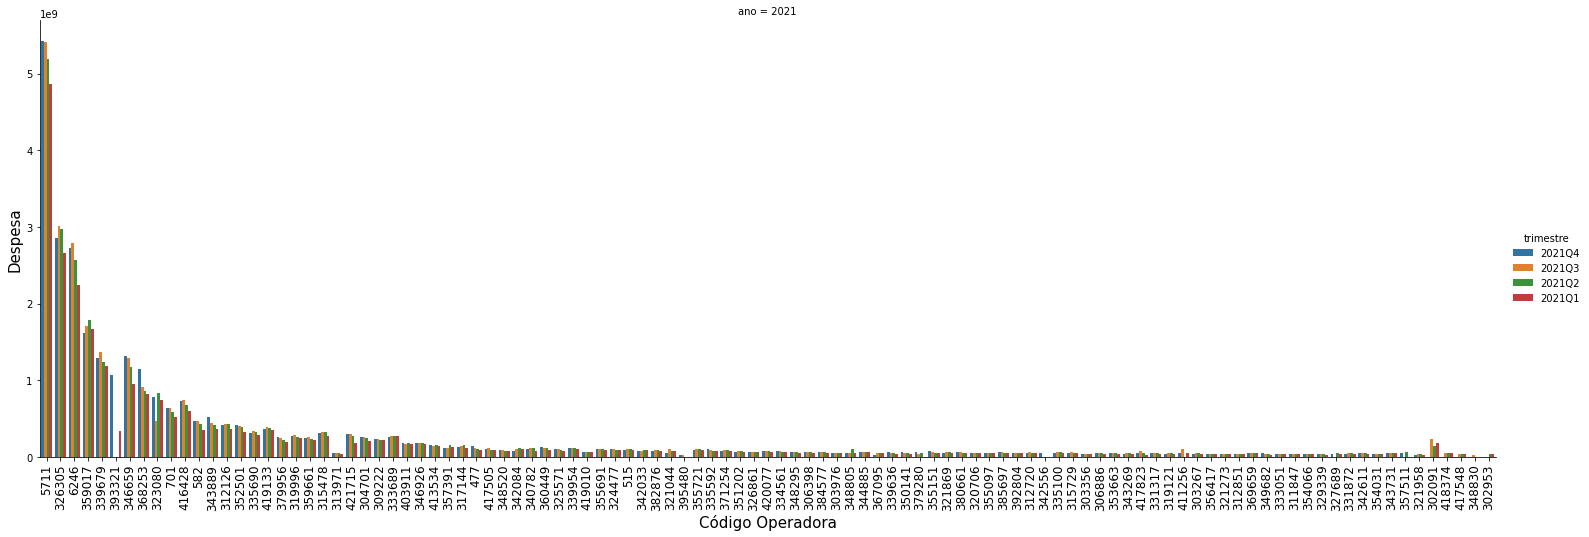

In [79]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Individual

In [80]:
df_tcc_trimestral_cont_ind = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Individual')] 
df_tcc_trimestral_cont_ind

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1     Individual   10.810    8.350    555       77.240
2018Q2     Individual   12.100   10.030    567       82.890
2018Q3     Individual   11.910   10.230    575       85.890
2018Q4     Individual   12.360   18.640    576      150.810
2019Q1     Individual   11.900    9.380    521       78.820
2019Q2     Individual   12.160   10.110    520       83.140
2019Q3     Individual   12.930   11.210    523       86.700
2019Q4     Individual   13.130   10.700    521       81.490
2020Q1     Individual   12.950    9.690    512       74.830
2020Q2     Individual   12.990    8.340    516       64.200
2020Q3     Individual   13.250    9.580    505       72.300
2020Q4     Individual   13.910   10.670    511       76.710
2021Q1     Individual   13.940   10.470    501       75.110
2021Q2     Individual   13.640   10.800    509       79.180
2021Q3     Individual   13.350   11.310    506       84.720
2021Q4     Individual   14.690   13.240    503       90.130
2022Q1     Individual   13.180   11.950    491       90.670

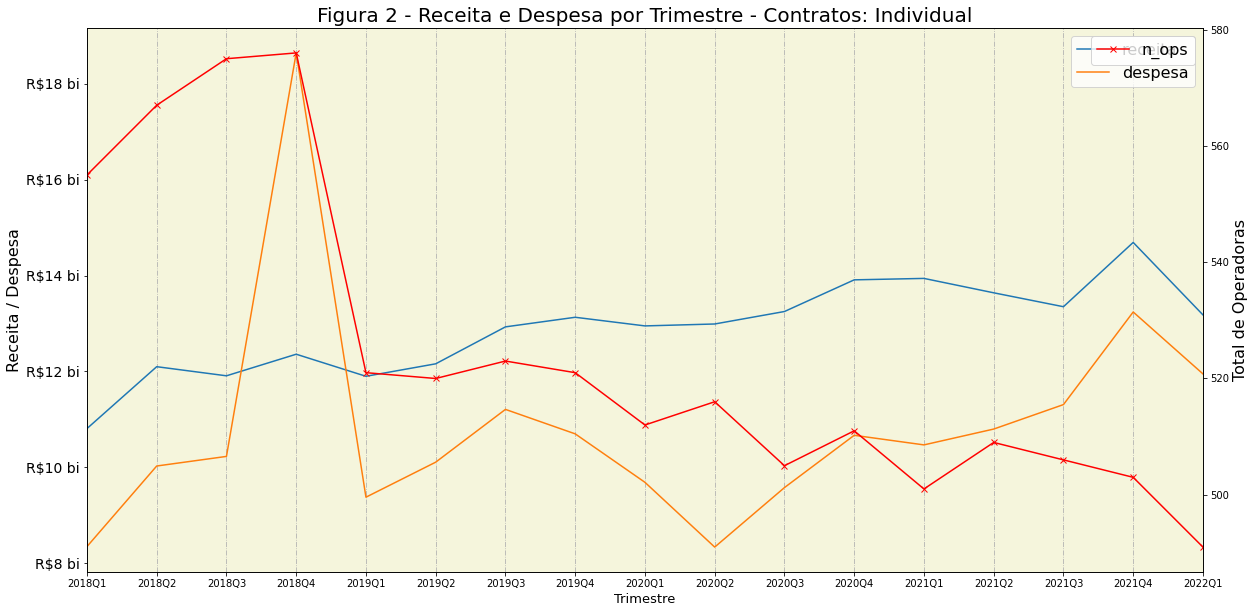

In [81]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_ind.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Individual',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_ind.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_ind.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_ind.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_ind.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_ind.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [82]:
diops_tcc_trimestral_ops_cont_ind = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Individual')] 

diops_tcc_trimestral_ops_cont_ind_top = diops_tcc_trimestral_ops_cont_ind.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_ind_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ind_top = diops_tcc_trimestral_ops_cont_ind_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ind_top.head()

ano trimestre  cd_ops      receita      despesa
1599  2018    2018Q1  319996 18968606.000 84421011.000
1598  2018    2018Q1  328537 19416278.000 12220081.000
1597  2018    2018Q1  406554 19518296.000 13379622.000
1596  2018    2018Q1  394734 19556946.000 12121812.000
1595  2018    2018Q1  352683 19706898.000 15513386.000

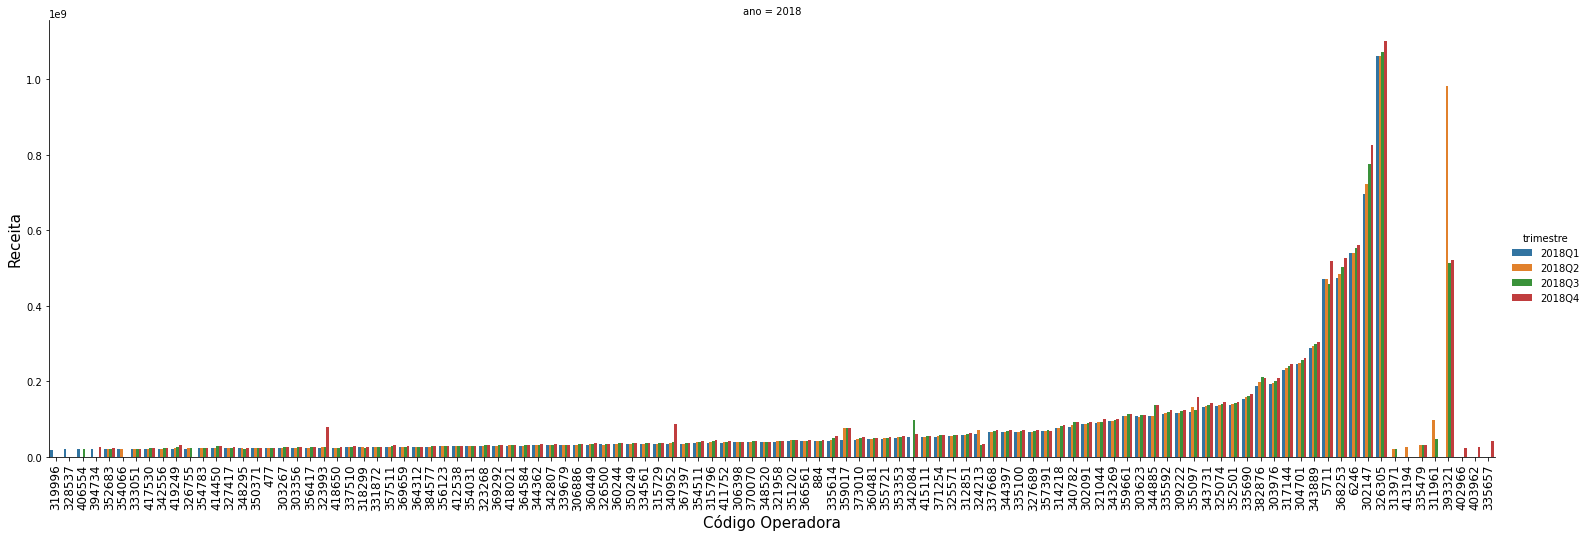

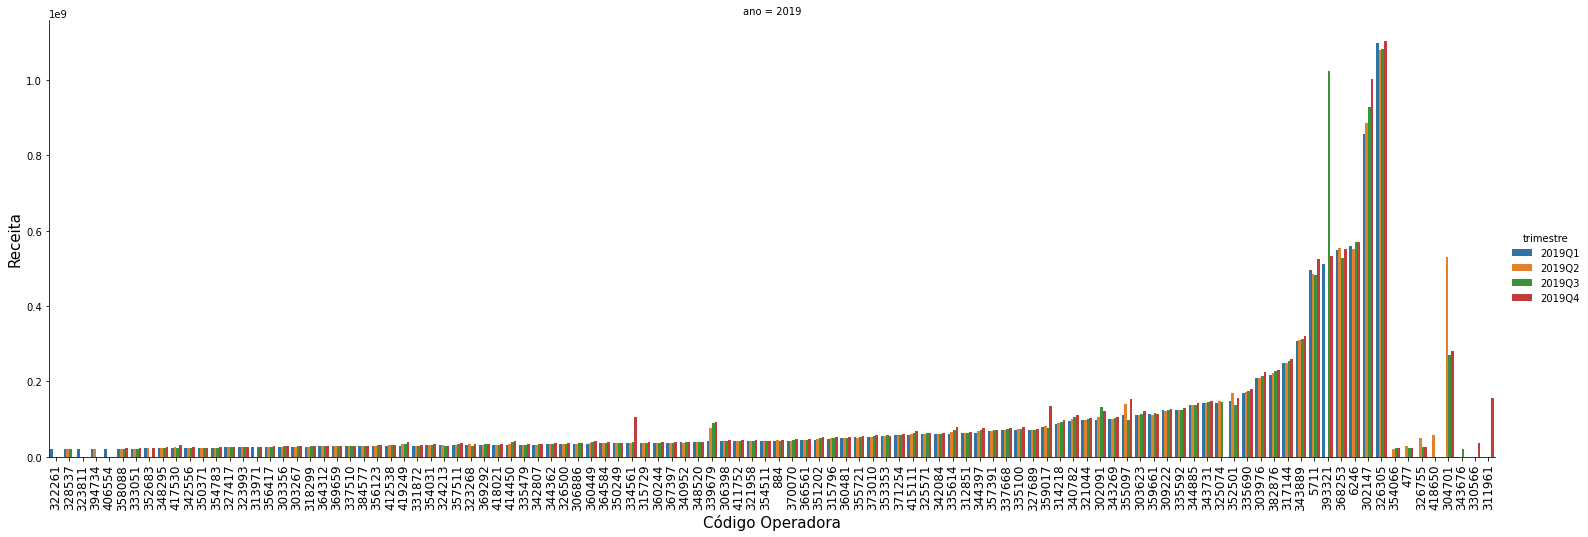

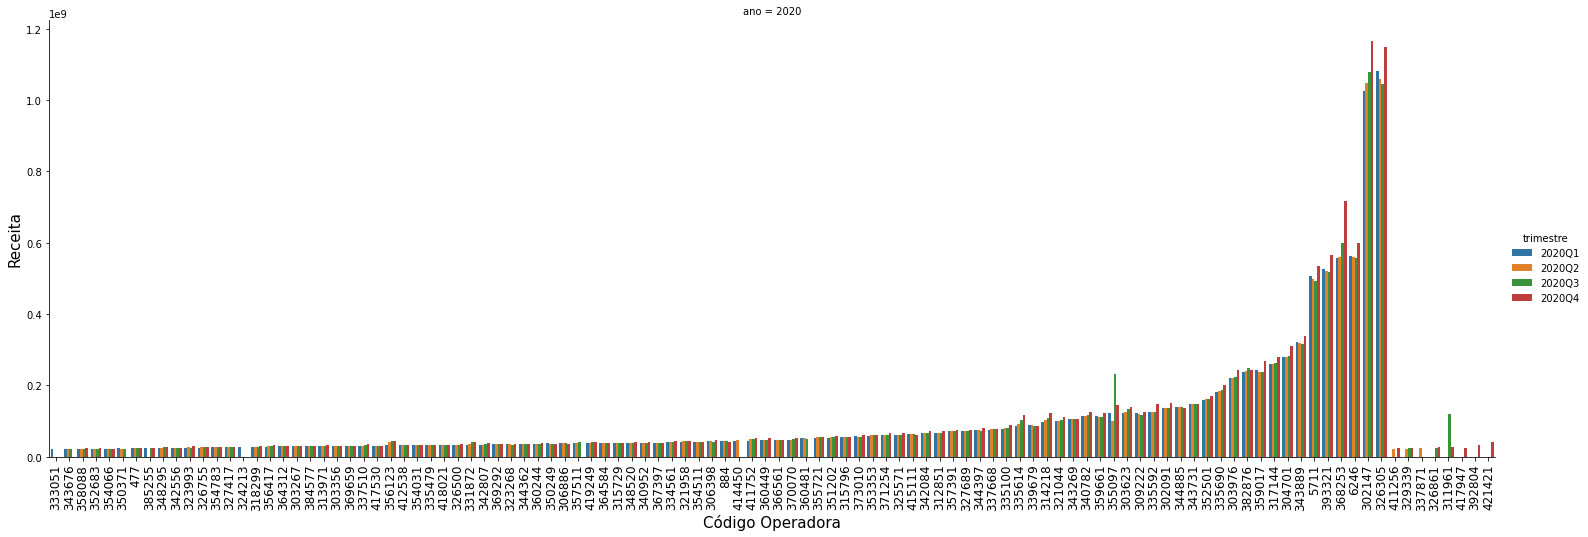

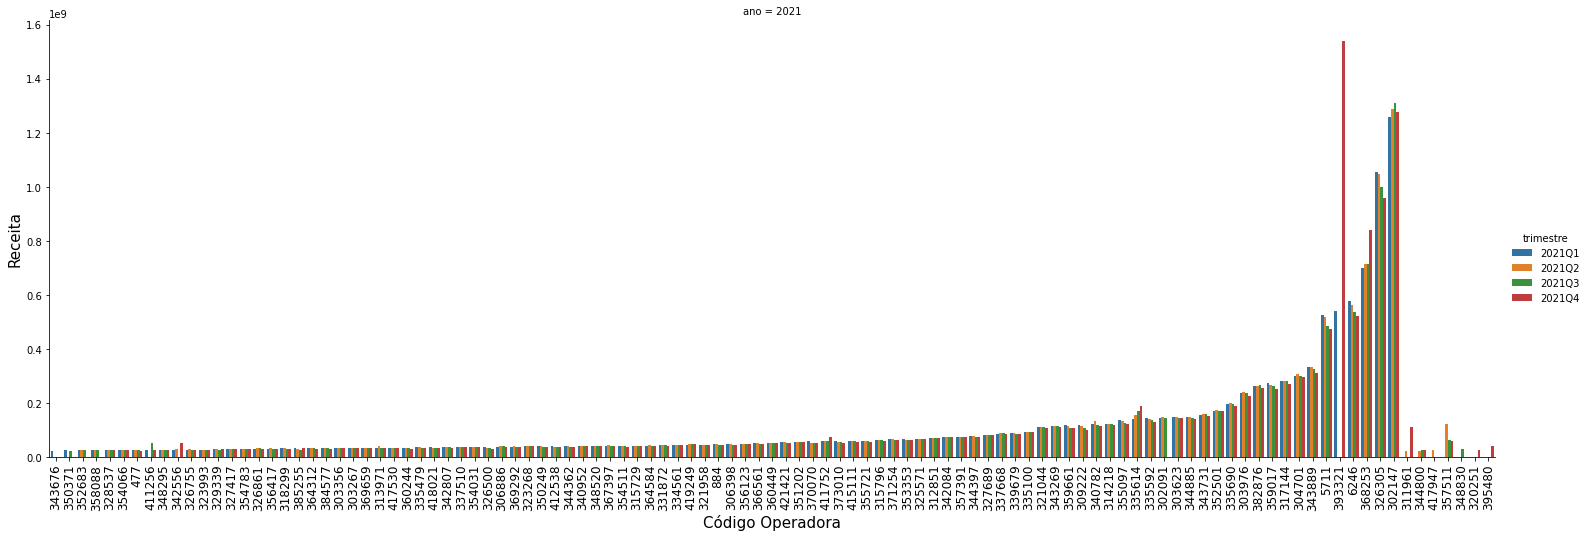

In [83]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

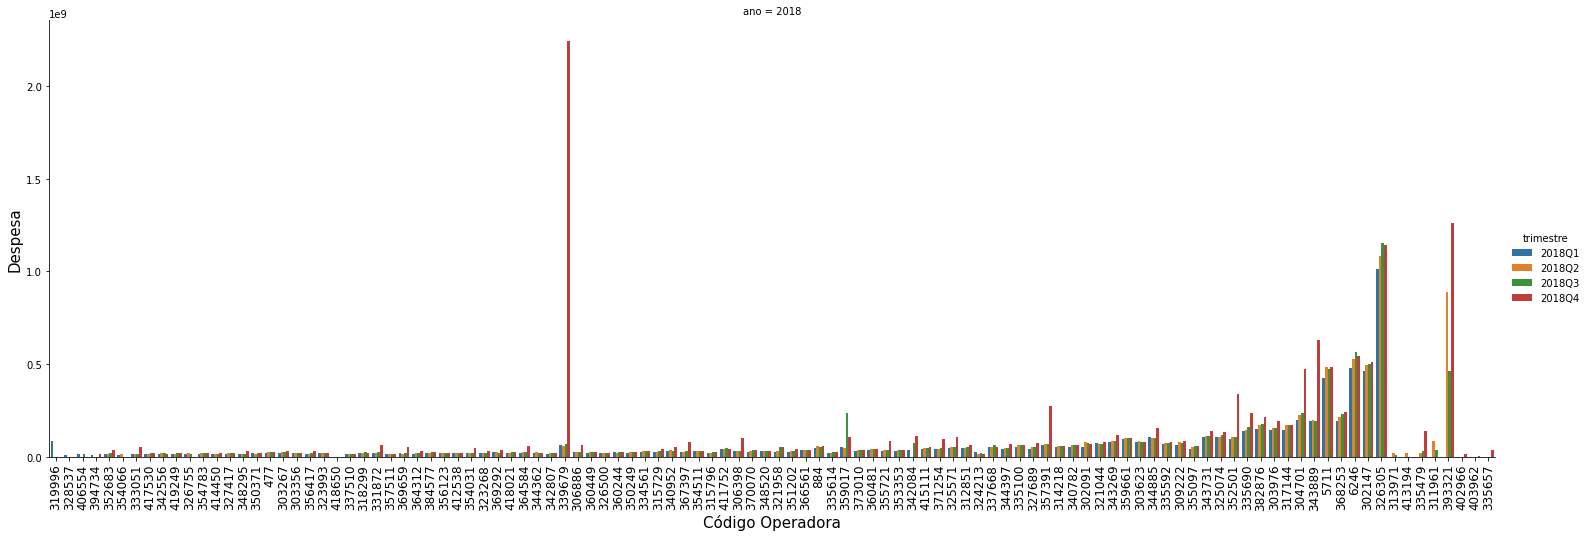

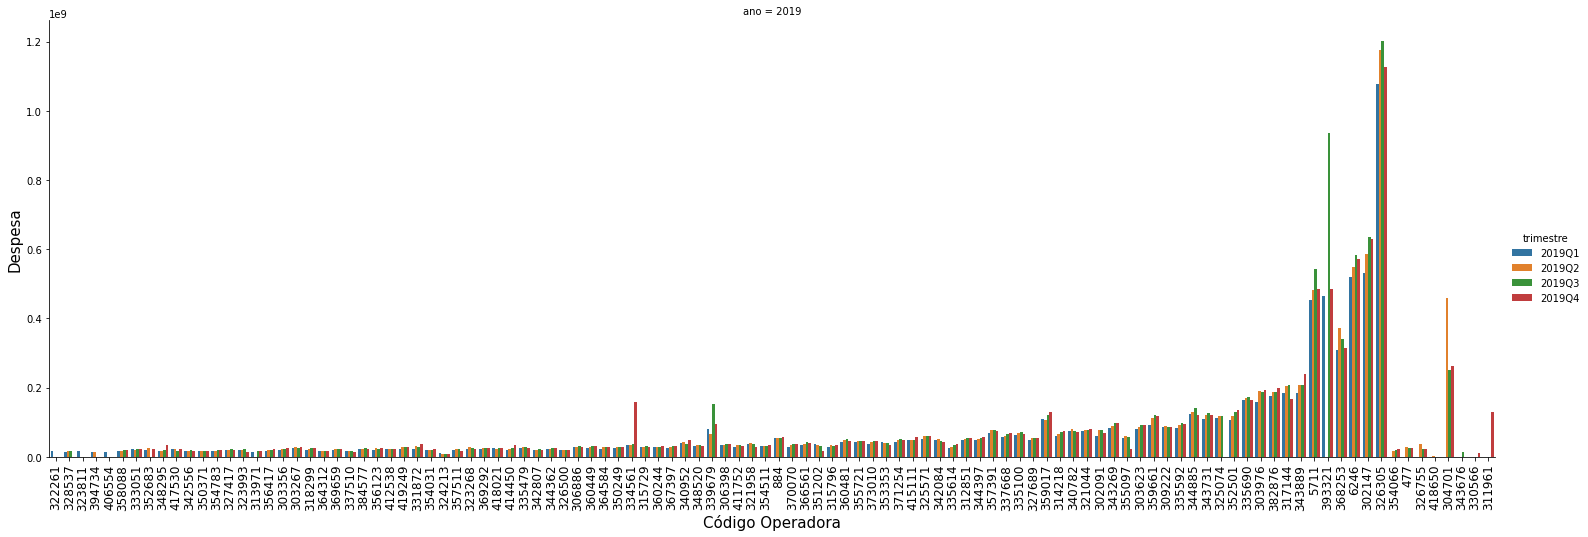

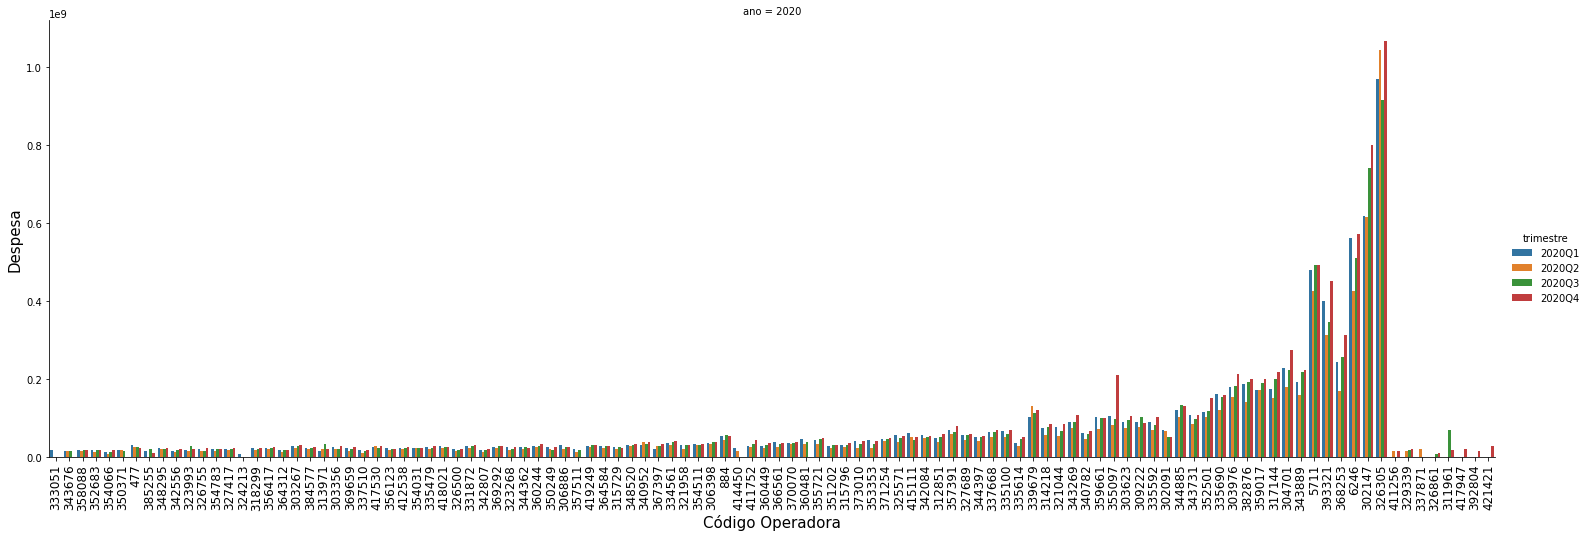

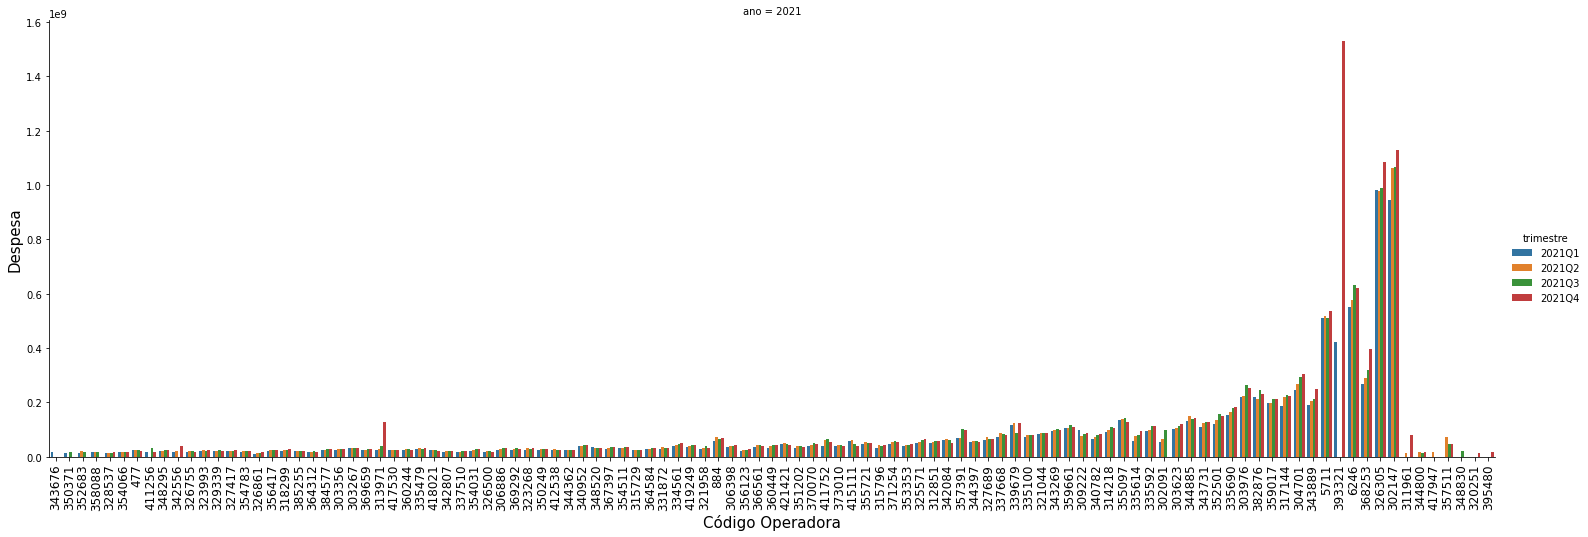

In [84]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

# Dados Filtrados

In [85]:
# filtra os tipos de planos relevantes para a análise

diops_filtrada = diops.loc[  (diops['vigencia'] == 'P') & # planos novos
                    (diops['financiamento'] == 'Pre-estabelecido'), # financiamento pre-estabelecido
                    ['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa']]

diops_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '07-diops_trimestral_acumulada_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')



diops_tcc_filtrada = diops_tcc.loc[  (diops_tcc['vigencia'] == 'P') & # planos novos
                            (diops_tcc['financiamento'] == 'Pre-estabelecido'), # financiamento pre-estabelecido
                            ['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa']]

diops_tcc_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '08-diops_trimestral_tcc_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

In [86]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_trimestral_ops_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                                                                                    'cd_ops':lambda x: x.nunique()})

diops_trimestral_ops_filtrada['pct_despesa'] = diops_trimestral_ops_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_ops_filtrada.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[diops_trimestral_ops_filtrada['trimestre'] >= '2018Q1']

diops_trimestral_ops_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '09-diops_trimestral_acumulada_filtrada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_filtrada.set_index('trimestre', inplace=True)

diops_trimestral_ops_filtrada

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      38.500   28.690    649       74.520
2018Q2      80.280   61.820    655       77.010
2018Q3     122.390   95.160    659       77.750
2018Q4     164.810  119.700    653       72.630
2019Q1      42.870   32.310    643       75.370
2019Q2      84.800   66.340    642       78.230
2019Q3     132.420  104.970    642       79.270
2019Q4     177.780  140.530    643       79.050
2020Q1      46.630   34.470    629       73.920
2020Q2      93.720   62.860    629       67.070
2020Q3     140.660   96.520    617       68.620
2020Q4     189.320  134.200    625       70.890
2021Q1      49.650   37.700    618       75.930
2021Q2      97.030   76.770    627       79.120
2021Q3     146.610  118.240    625       80.650
2021Q4     202.320  164.420    621       81.270
2022Q1      52.330   42.470    619       81.160

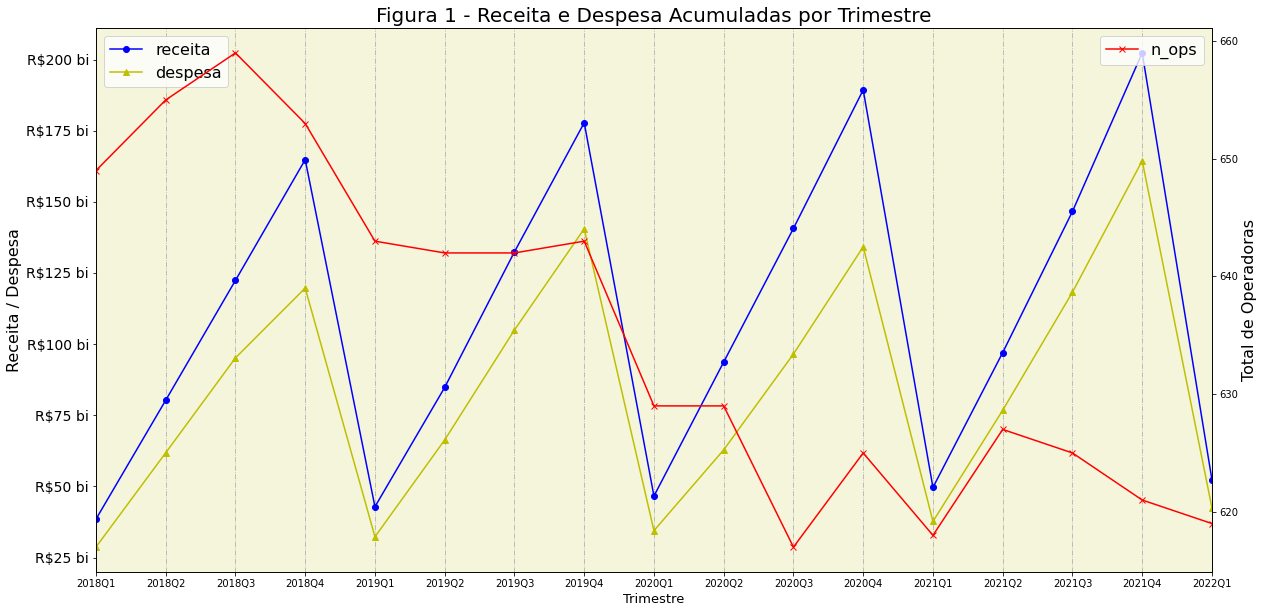

In [87]:
fig,ax1 = plt.subplots()

diops_trimestral_ops_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre',fontsize = 20)
ax1.set_xticks(diops_trimestral_ops_filtrada.index)
ax1.set_xticklabels(diops_trimestral_ops_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_trimestral_ops_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_ops_filtrada.index)
ax2.set_xticklabels(diops_trimestral_ops_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [88]:
diops_trimestral_ops_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({ 'receita': 'sum',
                                                                                                                                                        'despesa': 'sum'})

diops_trimestral_ops_filtrada['receita'] = diops_trimestral_ops_filtrada['receita'].apply(np.floor)

diops_trimestral_ops_filtrada['despesa'] = diops_trimestral_ops_filtrada['despesa'].apply(np.floor)

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[(diops_trimestral_ops_filtrada['receita'] != 0) & (diops_trimestral_ops_filtrada['despesa'] != 0)]

diops_trimestral_ops_filtrada['ano'] = diops_trimestral_ops_filtrada['id_calendar'].dt.to_period('Y')

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[['cd_ops','ano','trimestre','receita','despesa']]

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[(diops_trimestral_ops_filtrada['trimestre'] >= '2018Q1') & (diops_trimestral_ops_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_filtrada.head()

cd_ops   ano trimestre         receita         despesa
11476    5711  2021    2021Q4 22688305229.000 20327425181.000
8985     5711  2020    2020Q4 21005723600.000 16157936569.000
6485     5711  2019    2019Q4 19086103221.000 16007242015.000
4616   326305  2019    2019Q4 18880579544.000 16186560328.000
2014   326305  2018    2018Q4 18264112817.000 15027122529.000

In [89]:
diops_trimestral_ops_top_filtrada = diops_trimestral_ops_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_trimestral_ops_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_trimestral_ops_top_filtrada = diops_trimestral_ops_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

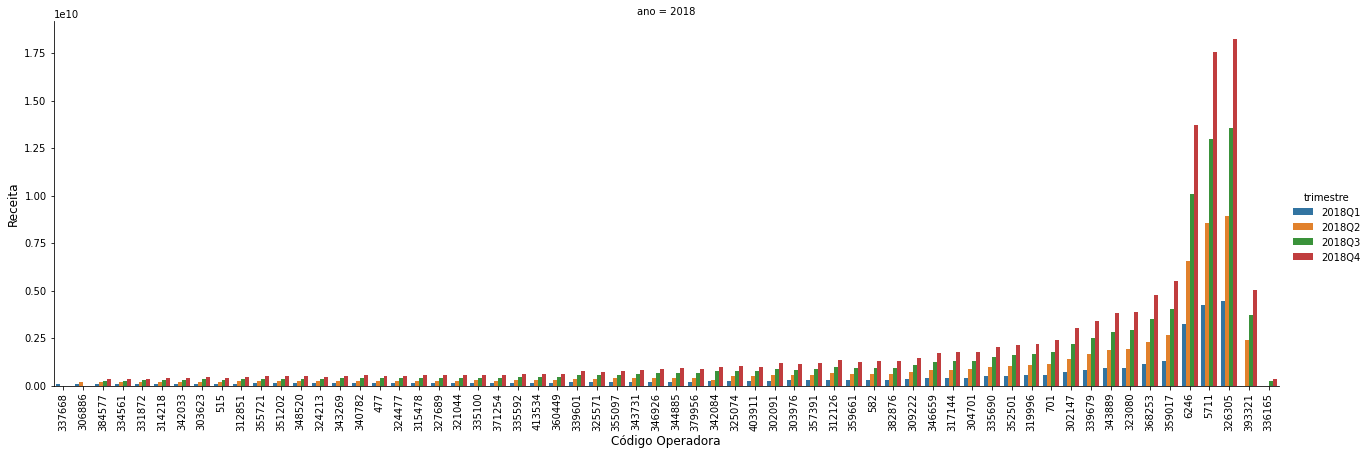

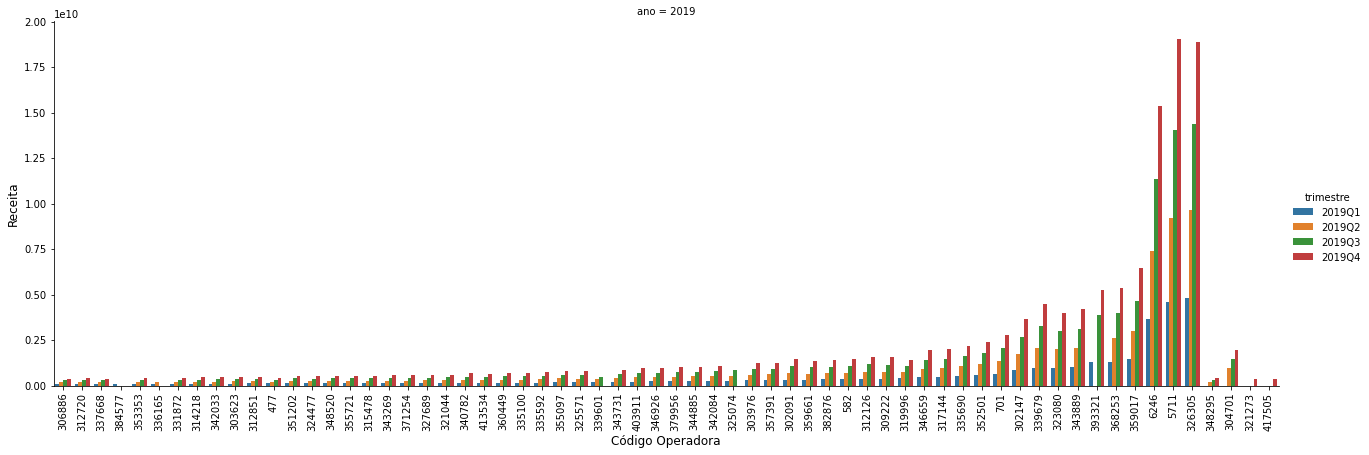

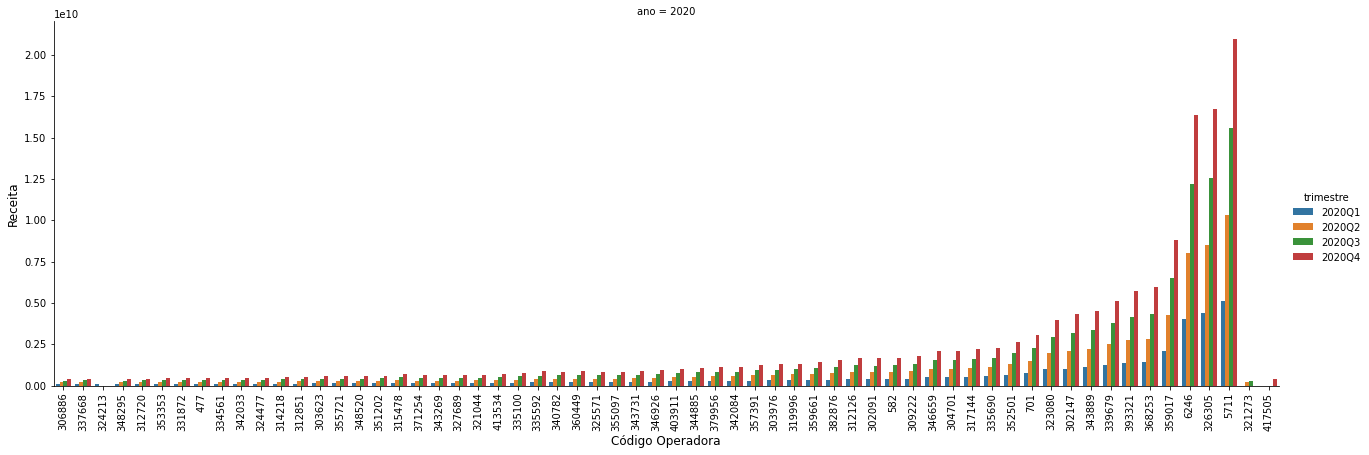

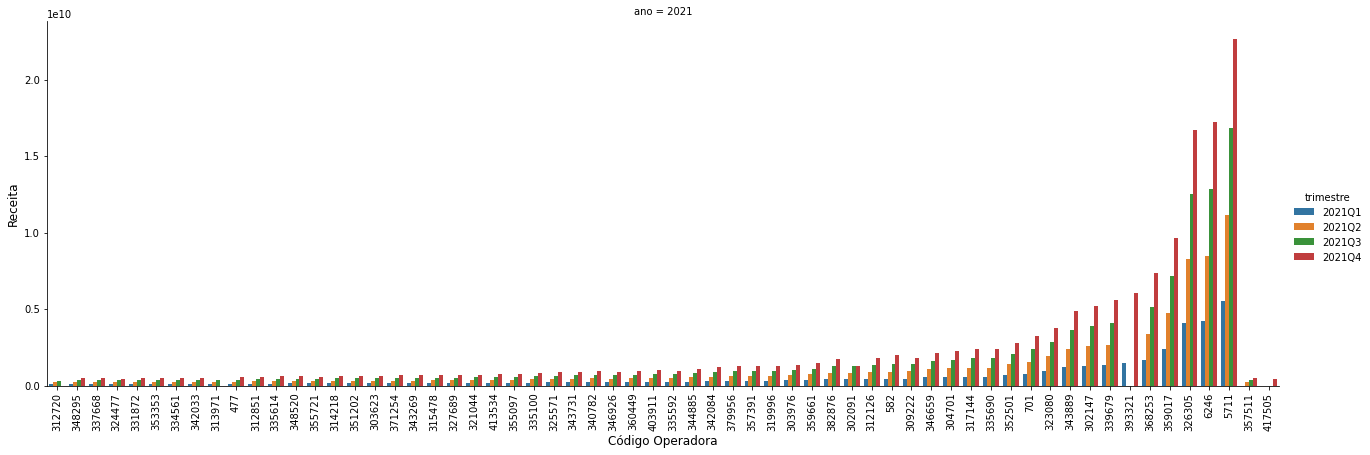

In [90]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 10)
ax[0].set_xlabels('Código Operadora', fontsize=12)
ax[0].set_ylabels('Receita', fontsize= 12)

ax[1].set_xticklabels(rotation = 90, fontsize= 10)
ax[1].set_xlabels('Código Operadora', fontsize=12)
ax[1].set_ylabels('Receita', fontsize= 12)

ax[2].set_xticklabels(rotation = 90, fontsize= 10)
ax[2].set_xlabels('Código Operadora', fontsize=12)
ax[2].set_ylabels('Receita', fontsize= 12)

ax[3].set_xticklabels(rotation = 90, fontsize= 10)
ax[3].set_xlabels('Código Operadora', fontsize=12)
ax[3].set_ylabels('Receita', fontsize= 12)

fig.tight_layout()

plt.close(1)
fig.show()

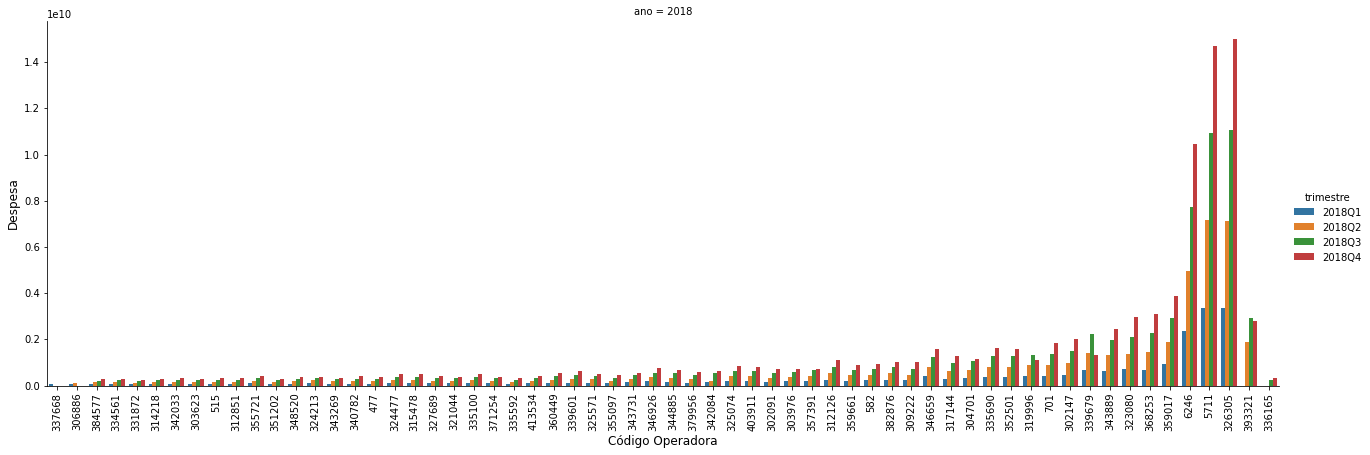

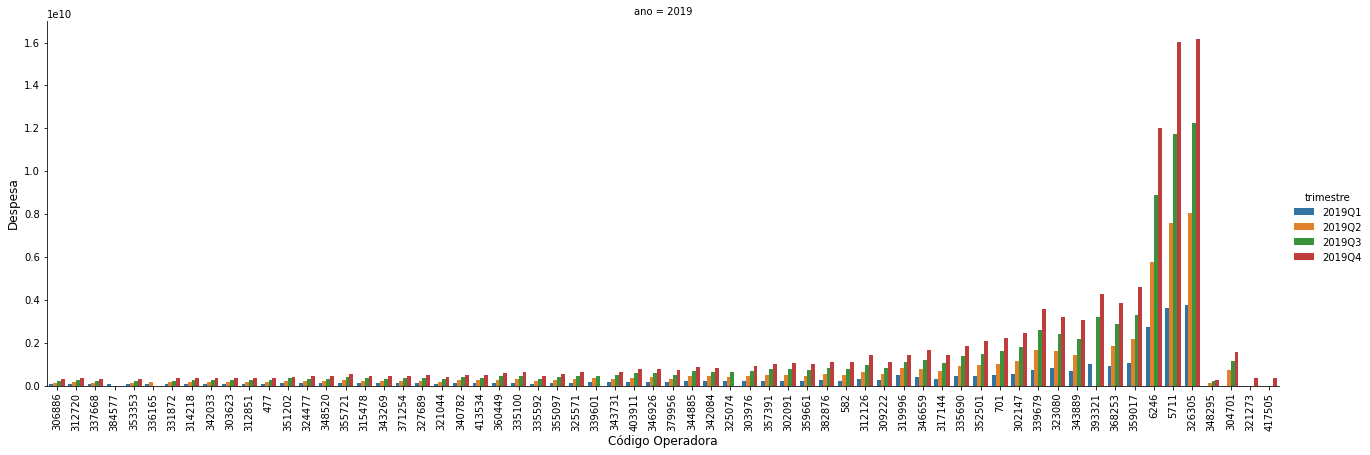

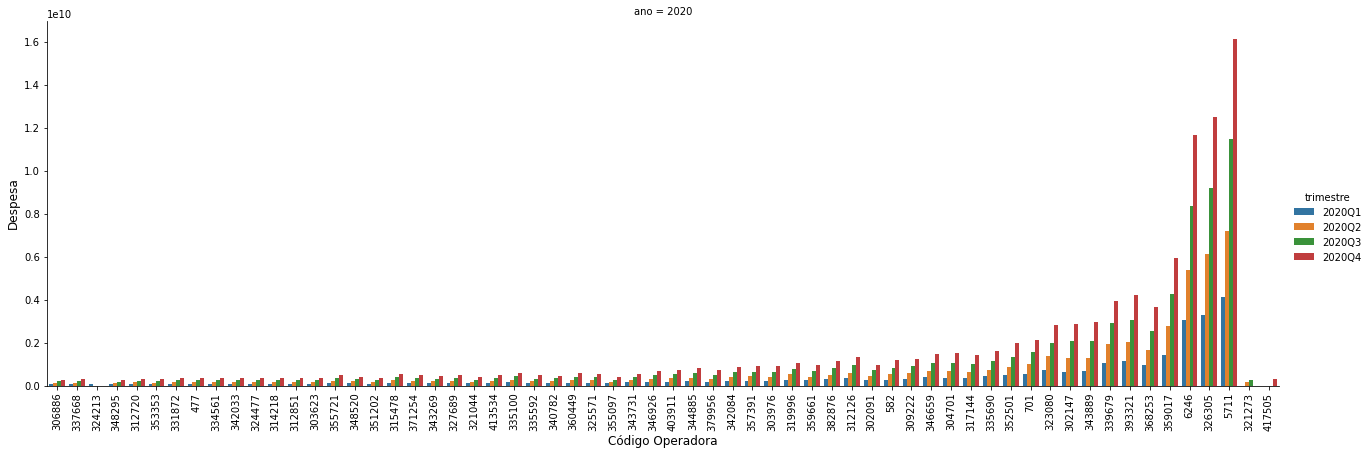

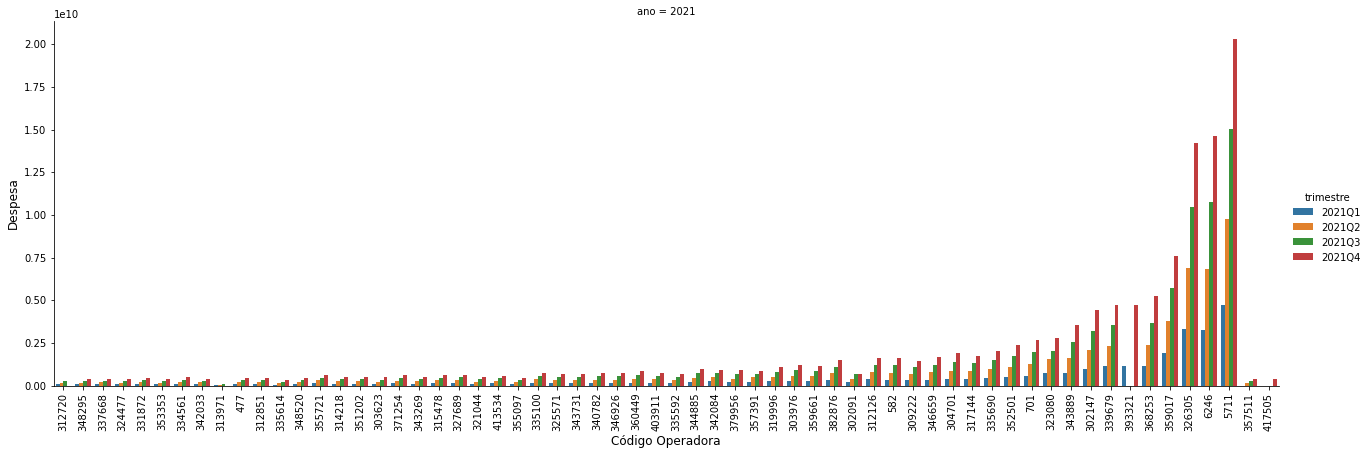

In [91]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 10)
ax[0].set_xlabels('Código Operadora', fontsize=12)
ax[0].set_ylabels('Despesa', fontsize= 12)

ax[1].set_xticklabels(rotation = 90, fontsize= 10)
ax[1].set_xlabels('Código Operadora', fontsize=12)
ax[1].set_ylabels('Despesa', fontsize= 12)

ax[2].set_xticklabels(rotation = 90, fontsize= 10)
ax[2].set_xlabels('Código Operadora', fontsize=12)
ax[2].set_ylabels('Despesa', fontsize= 12)

ax[3].set_xticklabels(rotation = 90, fontsize= 10)
ax[3].set_xlabels('Código Operadora', fontsize=12)
ax[3].set_ylabels('Despesa', fontsize= 12)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato - Base Filtrada

In [92]:
diops_trimestral_cont_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                                                                                                        'despesa':lambda x: sum_billion(x),
                                                                                                                                                                        'cd_ops':lambda x: x.nunique()})

diops_trimestral_cont_filtrada['pct_despesa'] = diops_trimestral_cont_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_cont_filtrada.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_cont_filtrada = diops_trimestral_cont_filtrada[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_cont_filtrada = diops_trimestral_cont_filtrada[diops_trimestral_cont_filtrada['trimestre'] >= '2018Q1']

diops_trimestral_cont_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '10-diops_contrato_trimestral_acumulada_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_cont_filtrada.set_index('trimestre', inplace=True)

In [93]:
diops_trimestral_ops_cont_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita': 'sum',
                                                                                                                                                                                'despesa': 'sum'})

diops_trimestral_ops_cont_filtrada['receita'] = diops_trimestral_ops_cont_filtrada['receita'].apply(np.floor)

diops_trimestral_ops_cont_filtrada['despesa'] = diops_trimestral_ops_cont_filtrada['despesa'].apply(np.floor)

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['receita'] != 0) & (diops_trimestral_ops_cont_filtrada['despesa'] != 0)]

diops_trimestral_ops_cont_filtrada['ano'] = diops_trimestral_ops_cont_filtrada['id_calendar'].dt.to_period('Y')

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['trimestre'] >= '2018Q1') & (diops_trimestral_ops_cont_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops_cont_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_cont_filtrada.head(20)

ano trimestre  cd_ops  contratacao         receita         despesa
27832  2021    2021Q4    5711  Empresarial 20925787383.000 18568865339.000
21722  2020    2020Q4    5711  Empresarial 19239408607.000 14726690270.000
15604  2019    2019Q4    5711  Empresarial 17564629074.000 14601518571.000
9386   2018    2018Q4    5711  Empresarial 16120079584.000 13390342989.000
27831  2021    2021Q3    5711  Empresarial 15498324775.000 13720808303.000
21721  2020    2020Q3    5711  Empresarial 14333634868.000 10467686894.000
11173  2019    2019Q4  326305  Empresarial 13550223978.000 10839762470.000
4952   2018    2018Q4  326305  Empresarial 12996937938.000 10062037920.000
15603  2019    2019Q3    5711  Empresarial 12951859813.000 10707431989.000
23424  2021    2021Q4  326305  Empresarial 12517510507.000 10223201694.000
27848  2021    2021Q4    6246  Empresarial 12319706549.000 10246469691.000
17331  2020    2020Q4  326305  Empresarial 12155429835.000  8988898031.000
9385   2018    2018Q3    5711  Empresarial 11927501042.000  9959130939.000
21738  2020    2020Q4    6246  Empresarial 11095113498.000  7630070595.000
11172  2019    2019Q3  326305  Empresarial 10367561564.000  8214937844.000
27830  2021    2021Q2    5711  Empresarial 10247914573.000  8893162487.000
15620  2019    2019Q4    6246  Empresarial 10120975005.000  7493377492.000
4951   2018    2018Q3  326305  Empresarial  9598706041.000  7385891384.000
21720  2020    2020Q2    5711  Empresarial  9499488732.000  6536622137.000
23423  2021    2021Q3  326305  Empresarial  9379099718.000  7631539282.000

## Adesão Filtrada

In [94]:
diops_trimestral_cont_ade_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Adesao')] 
diops_trimestral_cont_ade_filtrada

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1         Adesao    6.570    5.740    462       87.370
2018Q2         Adesao   14.100   12.410    468       88.010
2018Q3         Adesao   21.620   16.930    469       78.310
2018Q4         Adesao   28.920   20.930    465       72.370
2019Q1         Adesao    6.420    5.110    470       79.600
2019Q2         Adesao   12.050   10.050    471       83.400
2019Q3         Adesao   19.940   16.260    469       81.540
2019Q4         Adesao   26.660   21.810    474       81.810
2020Q1         Adesao    6.850    5.170    460       75.470
2020Q2         Adesao   13.810    9.450    471       68.430
2020Q3         Adesao   20.840   14.720    472       70.630
2020Q4         Adesao   28.080   20.410    476       72.690
2021Q1         Adesao    7.460    5.760    470       77.210
2021Q2         Adesao   13.780   11.230    475       81.490
2021Q3         Adesao   20.870   17.240    480       82.610
2021Q4         Adesao   30.190   25.220    476       83.540
2022Q1         Adesao    7.820    6.460    473       82.610

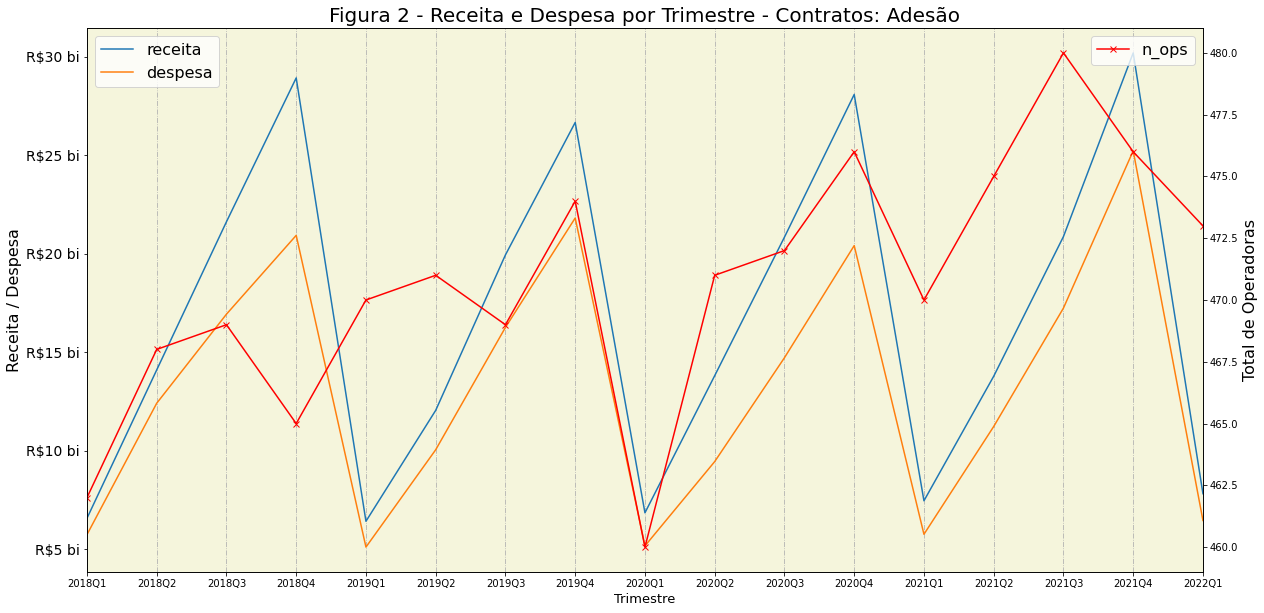

In [95]:
fig,ax1 = plt.subplots()

diops_trimestral_cont_ade_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Adesão',fontsize = 20)
ax1.set_xticks(diops_trimestral_cont_ade_filtrada.index)
ax1.set_xticklabels(diops_trimestral_cont_ade_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

diops_trimestral_cont_ade_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_cont_ade_filtrada.index)
ax2.set_xticklabels(diops_trimestral_cont_ade_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [96]:
diops_trimestral_ops_cont_ade_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['contratacao']=='Adesao')] 

diops_trimestral_ops_cont_ade_top_filtrada = diops_trimestral_ops_cont_ade_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_trimestral_ops_cont_ade_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_trimestral_ops_cont_ade_top_filtrada = diops_trimestral_ops_cont_ade_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_trimestral_ops_cont_ade_top_filtrada.head()

ano trimestre  cd_ops      receita      despesa
959  2018    2018Q1  369659 17575957.000 18296973.000
958  2018    2018Q1  343269 17742724.000 12272076.000
956  2018    2018Q1  371106 17780471.000 12604148.000
955  2018    2018Q1  417530 18111003.000 14113346.000
953  2018    2018Q1  339679 18671332.000 22645512.000

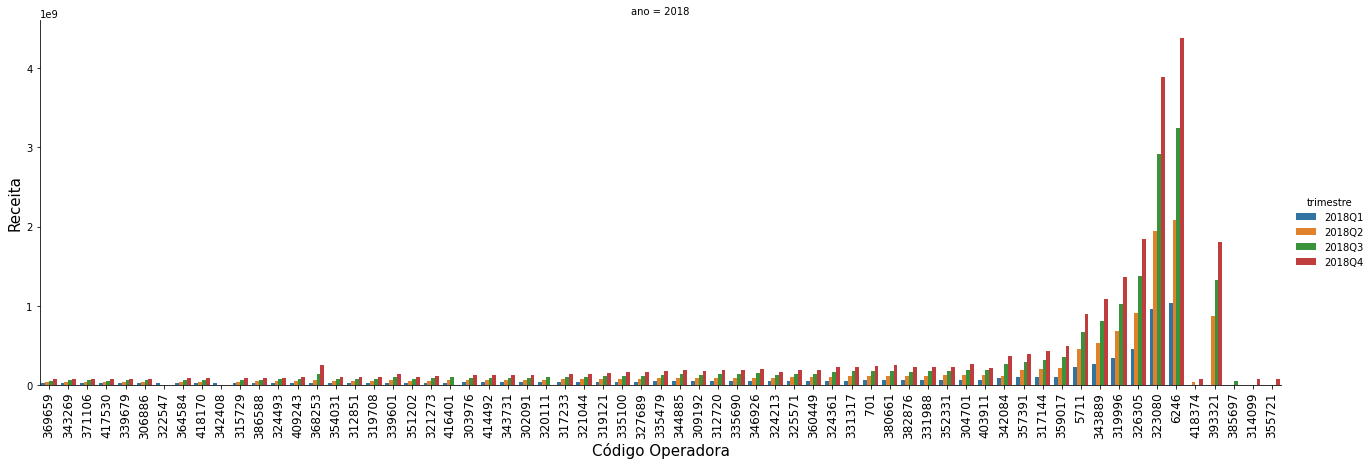

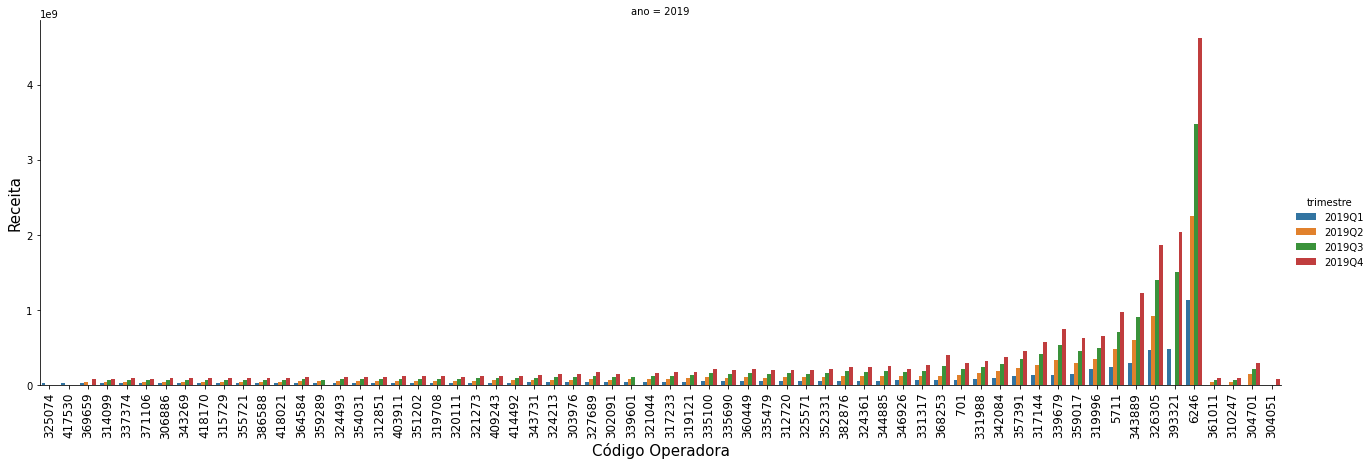

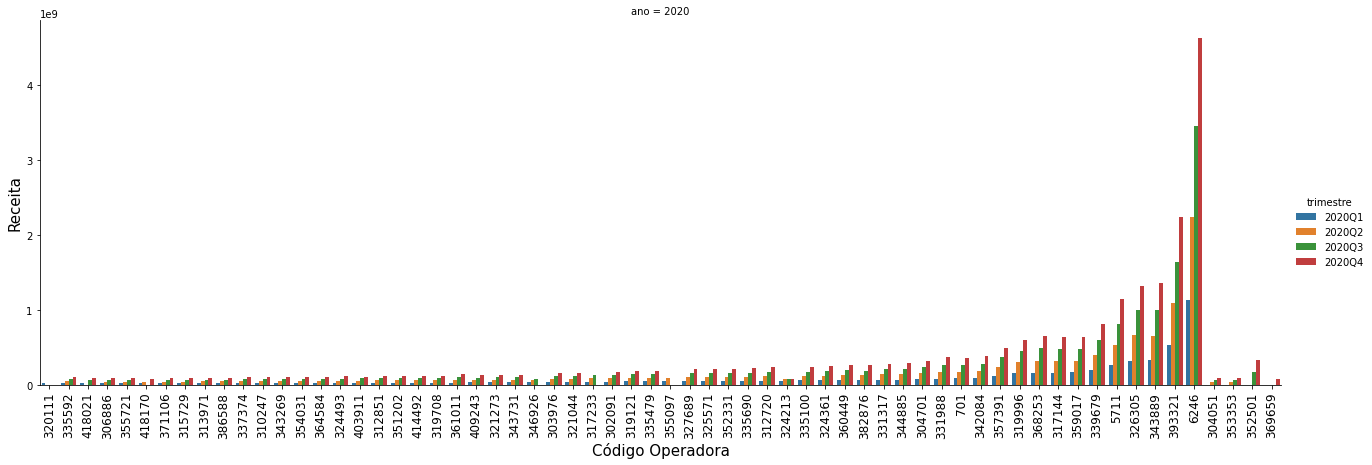

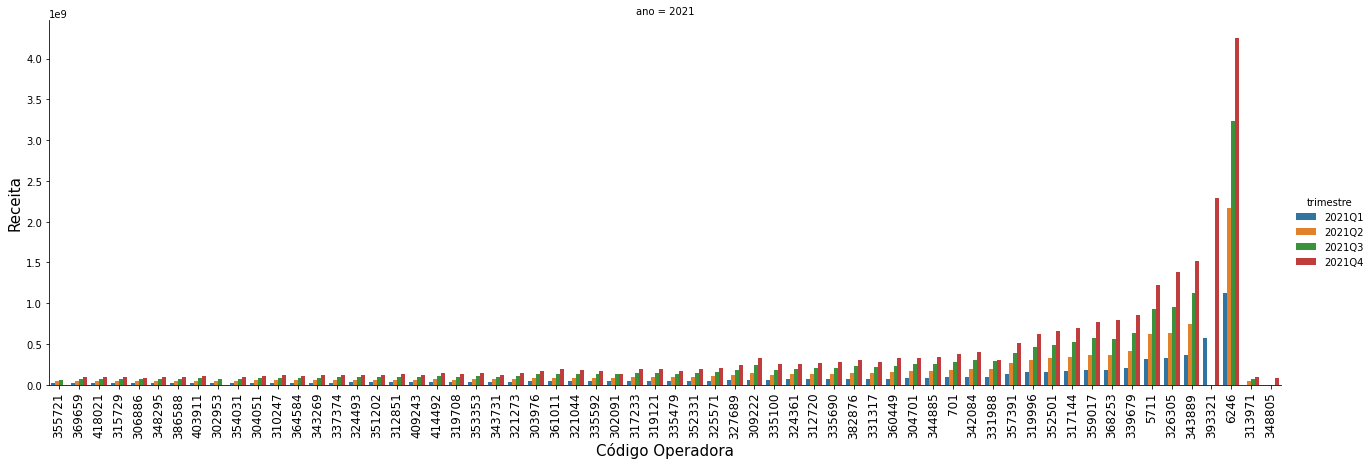

In [97]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

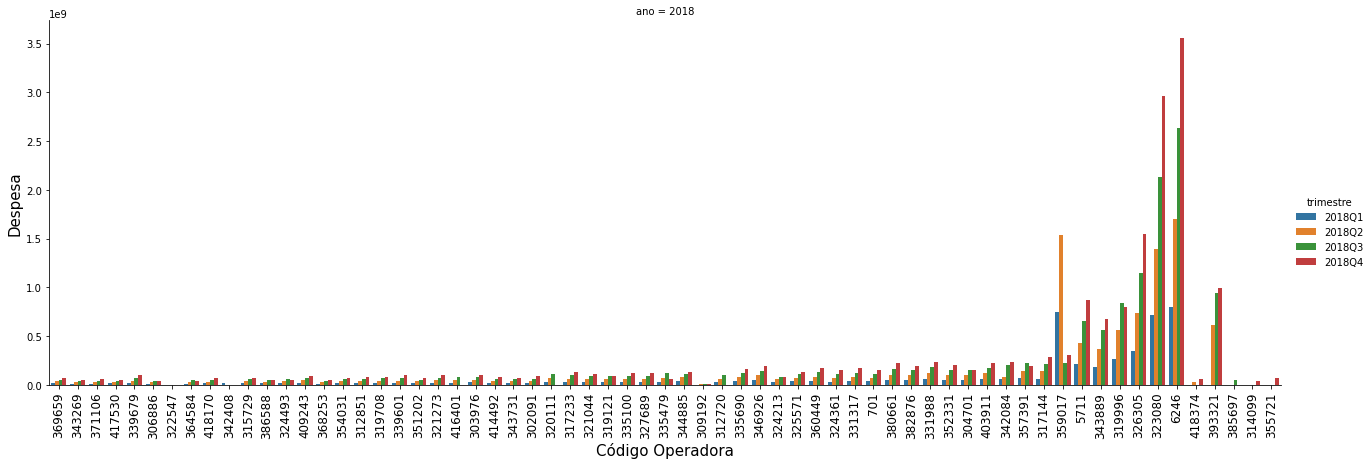

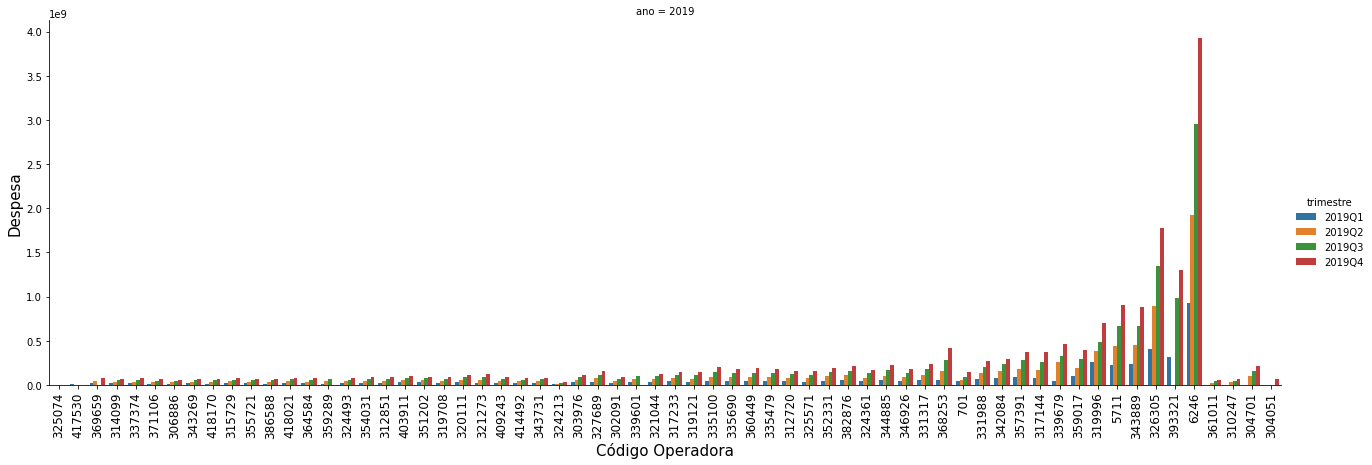

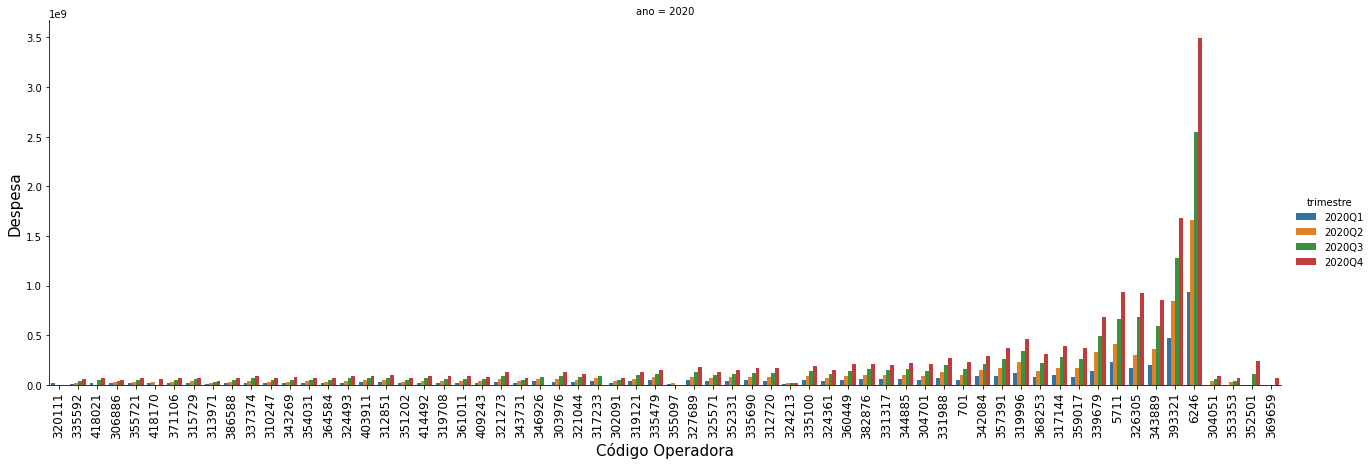

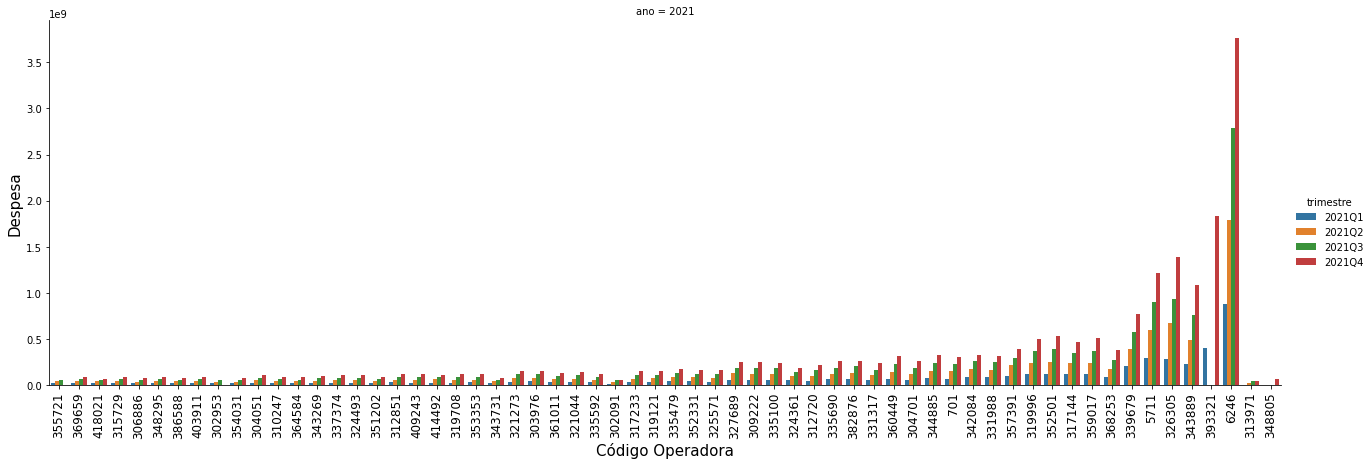

In [98]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial - Filtrada

In [99]:
df_trimestral_cont_emp_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Empresarial')] 
df_trimestral_cont_emp_filtrada

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                   
2018Q1     Empresarial   22.970   16.740    572       72.880
2018Q2     Empresarial   47.060   35.620    576       75.690
2018Q3     Empresarial   71.690   56.830    579       79.270
2018Q4     Empresarial   96.780   71.710    574       74.100
2019Q1     Empresarial   26.420   20.060    574       75.930
2019Q2     Empresarial   53.080   41.820    574       78.790
2019Q3     Empresarial   81.370   65.110    572       80.020
2019Q4     Empresarial  109.290   87.290    573       79.870
2020Q1     Empresarial   28.670   21.860    558       76.250
2020Q2     Empresarial   57.750   39.520    561       68.430
2020Q3     Empresarial   86.560   60.630    555       70.040
2020Q4     Empresarial  116.280   84.530    561       72.700
2021Q1     Empresarial   30.280   23.810    551       78.630
2021Q2     Empresarial   60.230   49.410    558       82.040
2021Q3     Empresarial   91.320   76.070    557       83.300
2021Q4     Empresarial  124.560  103.670    555       83.230
2022Q1     Empresarial   33.090   26.680    557       80.630

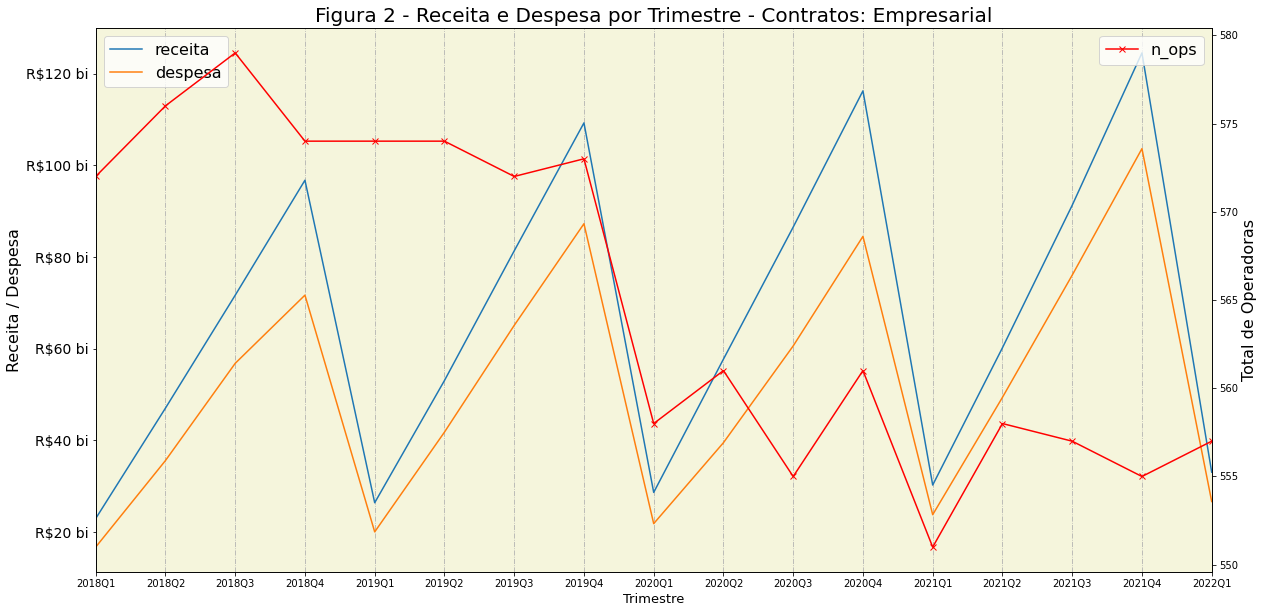

In [100]:
fig,ax1 = plt.subplots()

df_trimestral_cont_emp_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Empresarial',fontsize = 20)
ax1.set_xticks(df_trimestral_cont_emp_filtrada.index)
ax1.set_xticklabels(df_trimestral_cont_emp_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_trimestral_cont_emp_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_trimestral_cont_emp_filtrada.index)
ax2.set_xticklabels(df_trimestral_cont_emp_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

## Individual - Filtrada

In [101]:
df_trimestral_cont_ind_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Individual')] 
df_trimestral_cont_ind_filtrada

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1     Individual    8.960    6.210    522       69.310
2018Q2     Individual   19.110   13.790    526       72.160
2018Q3     Individual   29.080   21.400    530       73.590
2018Q4     Individual   39.110   27.060    519       69.190
2019Q1     Individual   10.030    7.150    508       71.290
2019Q2     Individual   19.670   14.470    509       73.560
2019Q3     Individual   31.110   23.610    514       75.890
2019Q4     Individual   41.830   31.430    510       75.140
2020Q1     Individual   11.110    7.440    501       66.970
2020Q2     Individual   22.160   13.890    506       62.680
2020Q3     Individual   33.250   21.170    495       63.670
2020Q4     Individual   44.950   29.260    502       65.090
2021Q1     Individual   11.910    8.120    495       68.180
2021Q2     Individual   23.020   16.130    501       70.070
2021Q3     Individual   34.420   24.940    498       72.460
2021Q4     Individual   47.580   35.530    494       74.670
2022Q1     Individual   11.420    9.320    488       81.610

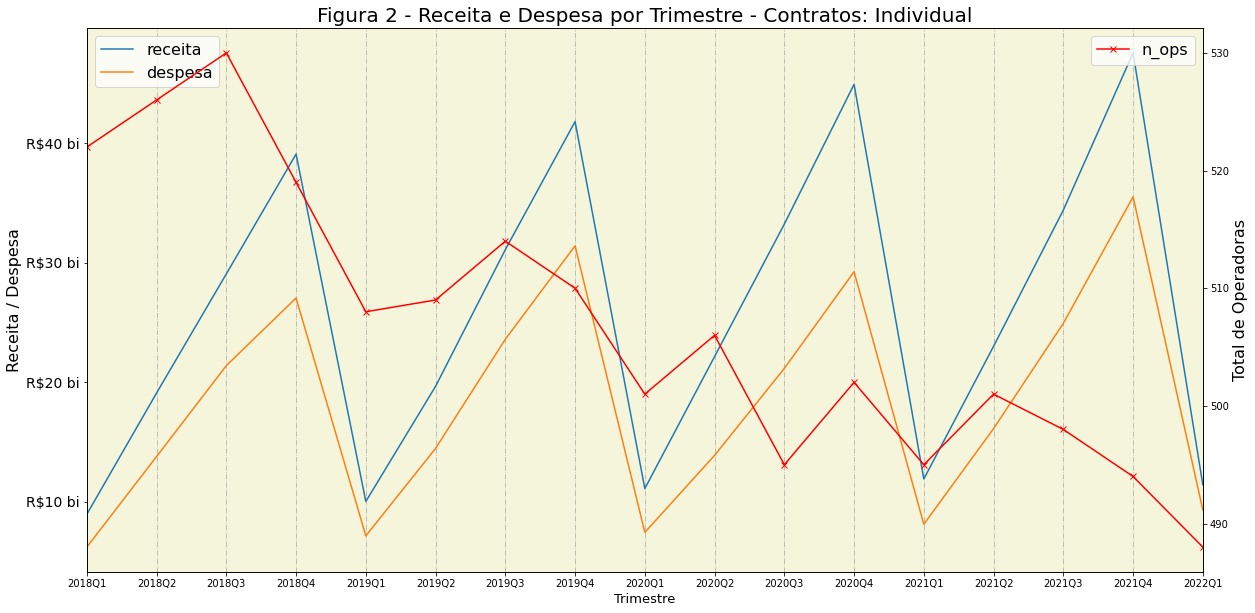

In [102]:
fig,ax1 = plt.subplots()

df_trimestral_cont_ind_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Individual',fontsize = 20)
ax1.set_xticks(df_trimestral_cont_ind_filtrada.index)
ax1.set_xticklabels(df_trimestral_cont_ind_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_trimestral_cont_ind_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_trimestral_cont_ind_filtrada.index)
ax2.set_xticklabels(df_trimestral_cont_ind_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [103]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_tcc_trimestral_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_filtrada['pct_despesa'] = diops_tcc_trimestral_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_filtrada.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_filtrada = diops_tcc_trimestral_filtrada[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_filtrada = diops_tcc_trimestral_filtrada[diops_tcc_trimestral_filtrada['trimestre'] >= '2018Q1']

diops_tcc_trimestral_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '11-diops_trimestral_tcc_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_filtrada.set_index('trimestre', inplace=True)

diops_tcc_trimestral_filtrada

receita  despesa  n_ops  pct_despesa
trimestre                                      
2018Q1      38.500   28.690    649       74.520
2018Q2      41.830   33.150    655       79.250
2018Q3      42.170   36.020    659       85.420
2018Q4      43.370   29.720    653       68.530
2019Q1      42.870   32.310    643       75.370
2019Q2      43.280   35.080    642       81.050
2019Q3      46.500   37.720    642       81.120
2019Q4      46.940   36.790    643       78.380
2020Q1      46.630   34.470    629       73.920
2020Q2      47.090   28.400    629       60.310
2020Q3      47.650   34.010    617       71.370
2020Q4      49.090   37.940    625       77.290
2021Q1      49.650   37.700    618       75.930
2021Q2      48.960   40.260    627       82.230
2021Q3      49.700   41.590    625       83.680
2021Q4      55.010   45.450    621       82.620
2022Q1      52.330   42.470    619       81.160

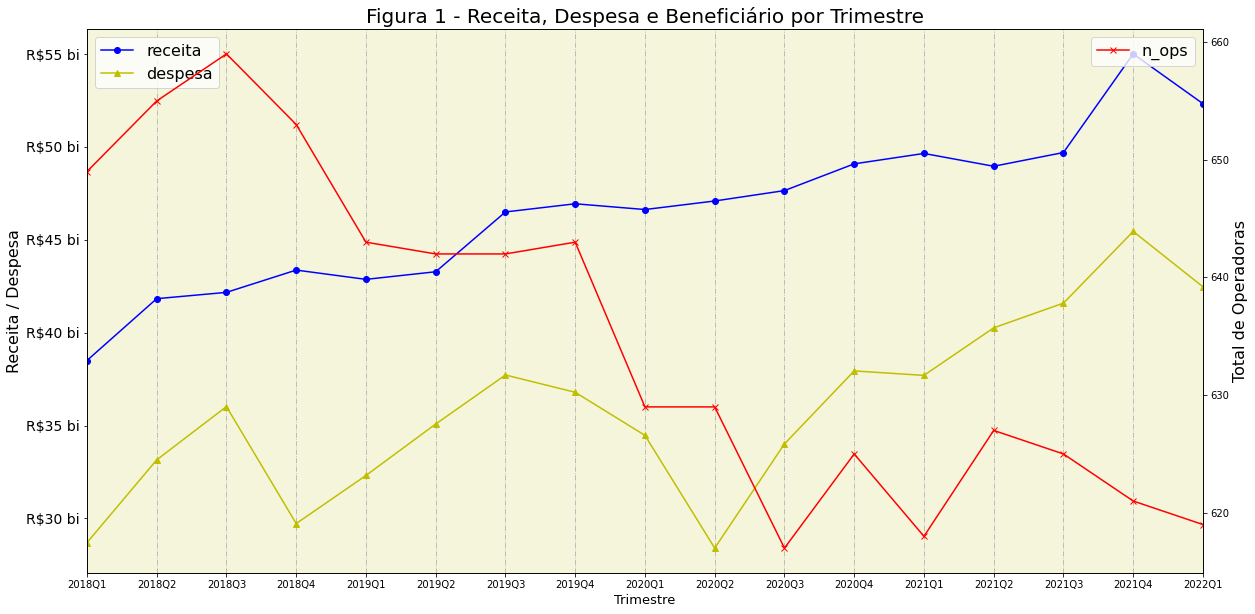

In [104]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita, Despesa e Beneficiário por Trimestre',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [105]:
diops_tcc_trimestral_ops_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                         'despesa': 'sum'})

diops_tcc_trimestral_ops_filtrada['receita'] = diops_tcc_trimestral_ops_filtrada['receita'].apply(np.floor)

diops_tcc_trimestral_ops_filtrada['despesa'] = diops_tcc_trimestral_ops_filtrada['despesa'].apply(np.floor)

diops_tcc_tridiops_tcc_trimestral_ops_filtradamestral_ops = diops_tcc_trimestral_ops_filtrada[(diops_tcc_trimestral_ops_filtrada['receita'] != 0) & (diops_tcc_trimestral_ops_filtrada['despesa'] != 0)]

diops_tcc_trimestral_ops_filtrada['ano'] = diops_tcc_trimestral_ops_filtrada['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_filtrada = diops_tcc_trimestral_ops_filtrada[['cd_ops','ano','trimestre','receita','despesa']]

diops_tcc_trimestral_ops_filtrada = diops_tcc_trimestral_ops_filtrada[(diops_tcc_trimestral_ops_filtrada['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_filtrada['trimestre'] < '2022Q1') ]

diops_tcc_trimestral_ops_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_filtrada.head()

cd_ops   ano trimestre        receita        despesa
11476   5711  2021    2021Q4 5854047696.000 5304192708.000
11475   5711  2021    2021Q3 5684732079.000 5271231460.000
11474   5711  2021    2021Q2 5607522749.000 5047162890.000
11473   5711  2021    2021Q1 5542002705.000 4704838122.000
8985    5711  2020    2020Q4 5424027156.000 4662958578.000

In [106]:
diops_tcc_trimestral_ops_top_filtrada = diops_tcc_trimestral_ops_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_top_filtrada = diops_tcc_trimestral_ops_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

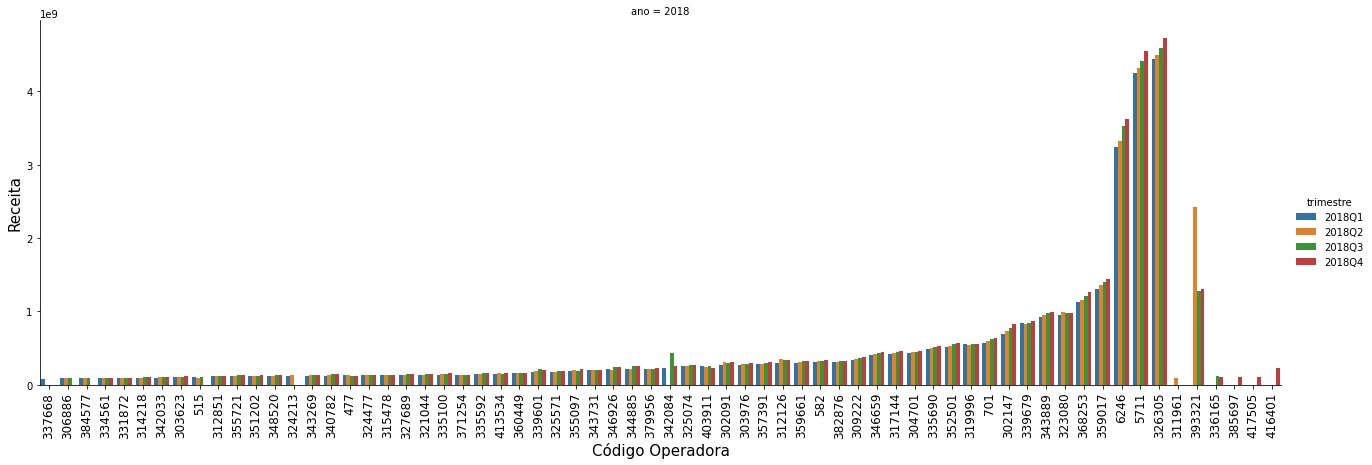

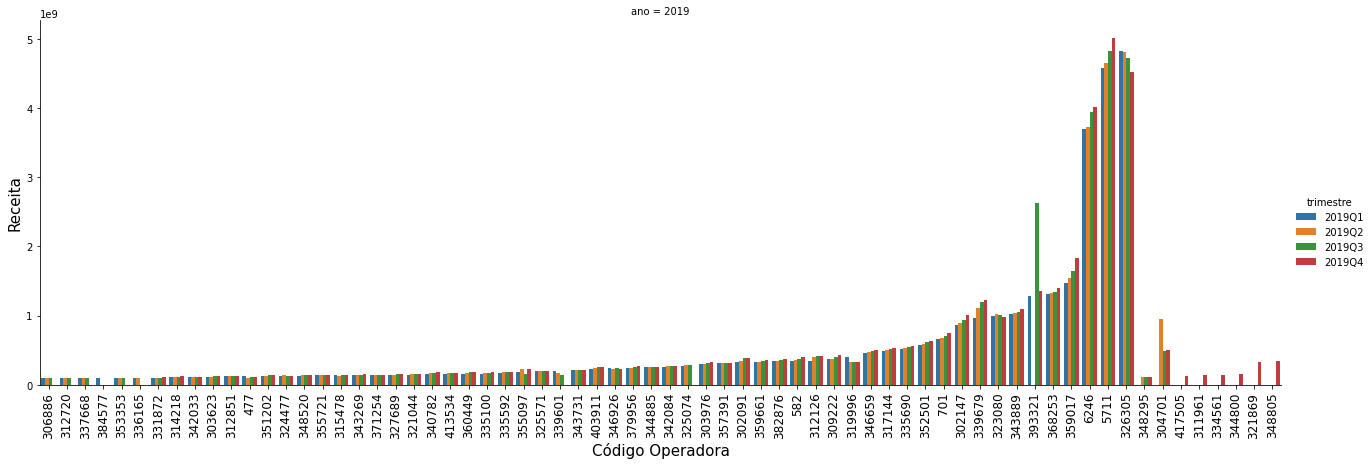

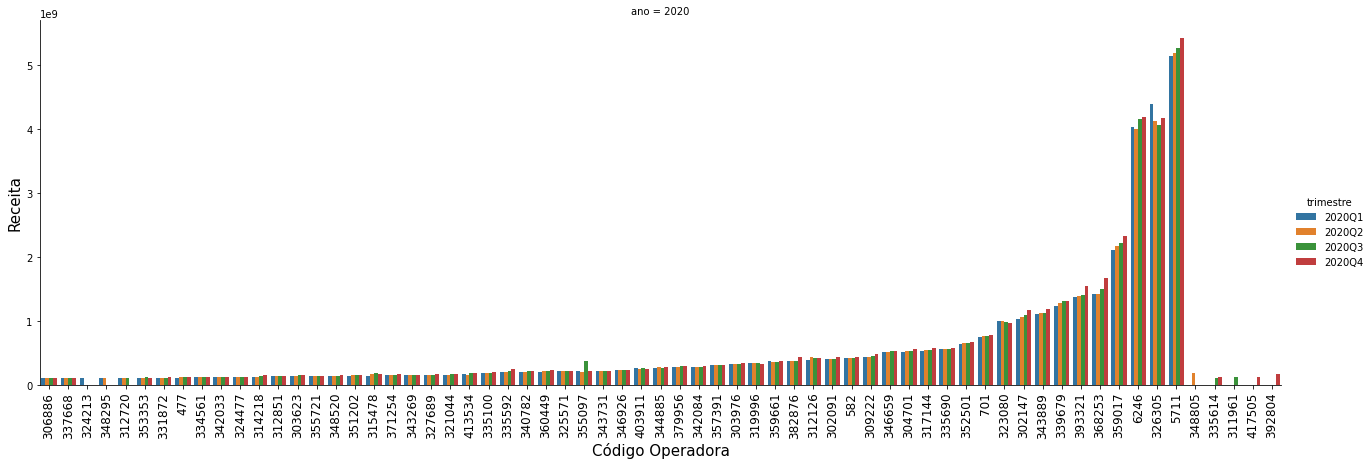

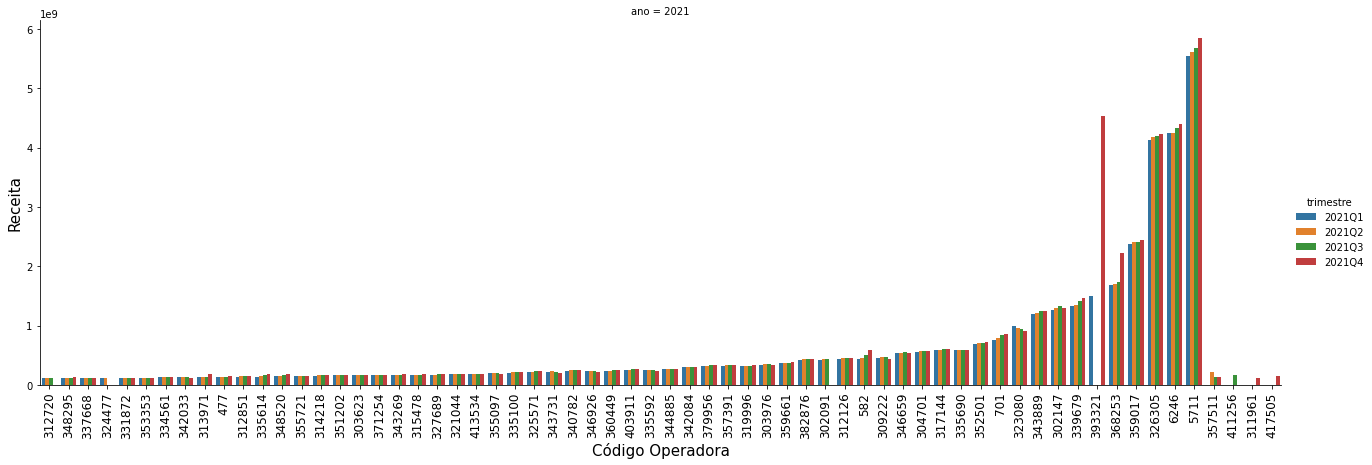

In [107]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

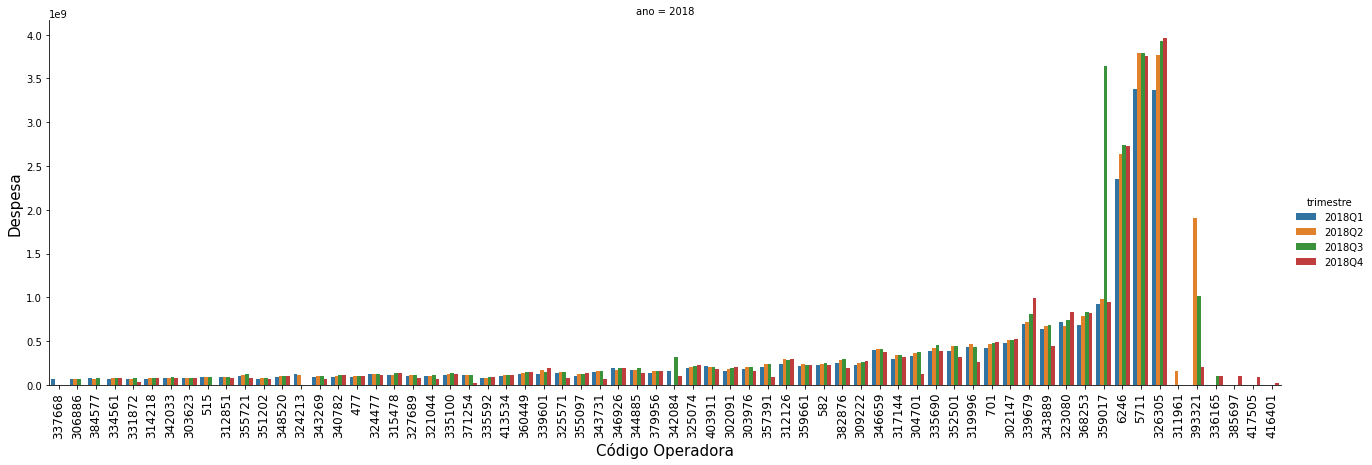

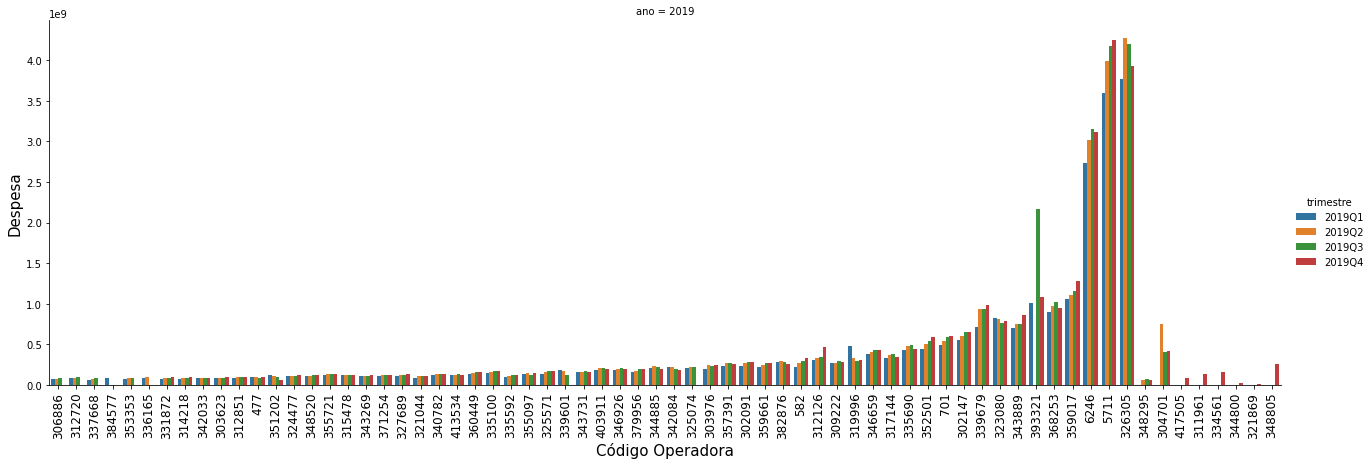

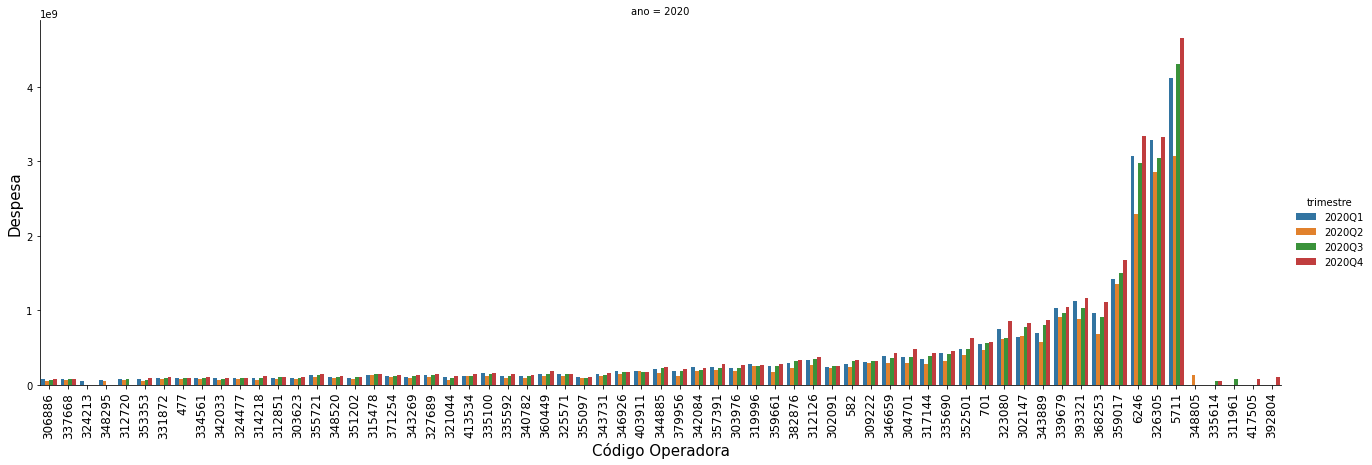

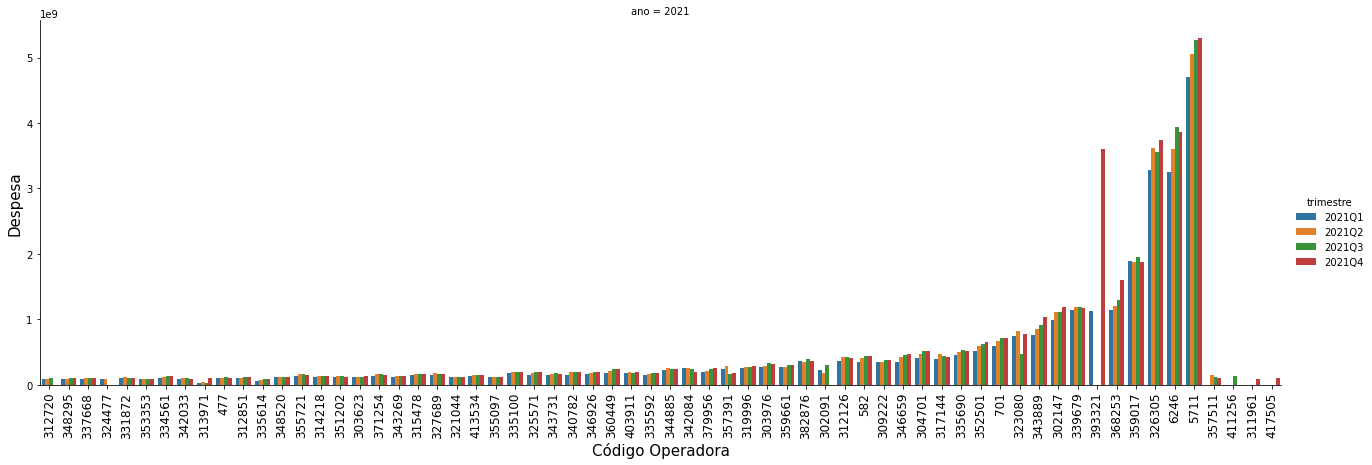

In [108]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato - Filtrada

In [109]:
diops_tcc_trimestral_cont_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao', 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                                                                  'despesa':lambda x: sum_billion(x),
                                                                                                                                                                                  'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_cont_filtrada['pct_despesa'] = diops_tcc_trimestral_cont_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_cont_filtrada.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_cont_filtrada = diops_tcc_trimestral_cont_filtrada[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_cont_filtrada = diops_tcc_trimestral_cont_filtrada[diops_tcc_trimestral_cont_filtrada['trimestre'] >= '2018Q1']

diops_tcc_trimestral_cont_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '12-diops_contrato_trimestral_tcc_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_cont_filtrada.set_index('trimestre', inplace=True)

In [110]:
diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita': 'sum',
                                                                                                                                                                                    'despesa': 'sum'})

diops_tcc_trimestral_ops_cont_filtrada['receita'] = diops_tcc_trimestral_ops_cont_filtrada['receita'].apply(np.floor)

diops_tcc_trimestral_ops_cont_filtrada['despesa'] = diops_tcc_trimestral_ops_cont_filtrada['despesa'].apply(np.floor)

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['receita'] != 0) & (diops_tcc_trimestral_ops_cont_filtrada['despesa'] != 0)]

diops_tcc_trimestral_ops_cont_filtrada['ano'] = diops_tcc_trimestral_ops_cont_filtrada['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_cont_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_tcc_trimestral_ops_cont_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_cont_filtrada.head(20)

ano trimestre  cd_ops  contratacao        receita        despesa
27832  2021    2021Q4    5711  Empresarial 5427462608.000 4848057035.000
27831  2021    2021Q3    5711  Empresarial 5250410202.000 4827645816.000
27830  2021    2021Q2    5711  Empresarial 5170117267.000 4618480419.000
27829  2021    2021Q1    5711  Empresarial 5077797306.000 4274682068.000
21722  2020    2020Q4    5711  Empresarial 4905773738.000 4259003376.000
21721  2020    2020Q3    5711  Empresarial 4834146136.000 3931064756.000
21720  2020    2020Q2    5711  Empresarial 4769671535.000 2770584911.000
21719  2020    2020Q1    5711  Empresarial 4729817197.000 3766037225.000
15604  2019    2019Q4    5711  Empresarial 4612769261.000 3894086581.000
15603  2019    2019Q3    5711  Empresarial 4451208456.000 3798931156.000
15602  2019    2019Q2    5711  Empresarial 4289092459.000 3651729781.000
15601  2019    2019Q1    5711  Empresarial 4211558896.000 3256771052.000
9386   2018    2018Q4    5711  Empresarial 4192578542.000 3431212050.000
9385   2018    2018Q3    5711  Empresarial 4079763013.000 3447197735.000
9384   2018    2018Q2    5711  Empresarial 3953896222.000 3445004995.000
9383   2018    2018Q1    5711  Empresarial 3893841807.000 3066928207.000
11170  2019    2019Q1  326305  Empresarial 3497111512.000 2527445862.000
11171  2019    2019Q2  326305  Empresarial 3489481153.000 2882401386.000
4952   2018    2018Q4  326305  Empresarial 3398231897.000 2676146535.000
11172  2019    2019Q3  326305  Empresarial 3380968898.000 2805090595.000

## Adesão

In [111]:
diops_tcc_trimestral_cont_ade_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Adesao')]
diops_tcc_trimestral_cont_ade_filtrada 

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1         Adesao    6.570    5.740    462       87.370
2018Q2         Adesao    7.540    6.670    468       88.460
2018Q3         Adesao    7.530    7.190    469       95.480
2018Q4         Adesao    7.650    4.940    465       64.580
2019Q1         Adesao    6.420    5.110    470       79.600
2019Q2         Adesao    6.130    5.270    471       85.970
2019Q3         Adesao    7.500    5.930    469       79.070
2019Q4         Adesao    7.010    5.680    474       81.030
2020Q1         Adesao    6.850    5.170    460       75.470
2020Q2         Adesao    6.960    4.280    471       61.490
2020Q3         Adesao    7.290    5.340    472       73.250
2020Q4         Adesao    7.330    5.740    476       78.310
2021Q1         Adesao    7.460    5.760    470       77.210
2021Q2         Adesao    6.900    5.880    475       85.220
2021Q3         Adesao    7.100    6.010    480       84.650
2021Q4         Adesao    8.870    7.660    476       86.360
2022Q1         Adesao    7.820    6.460    473       82.610

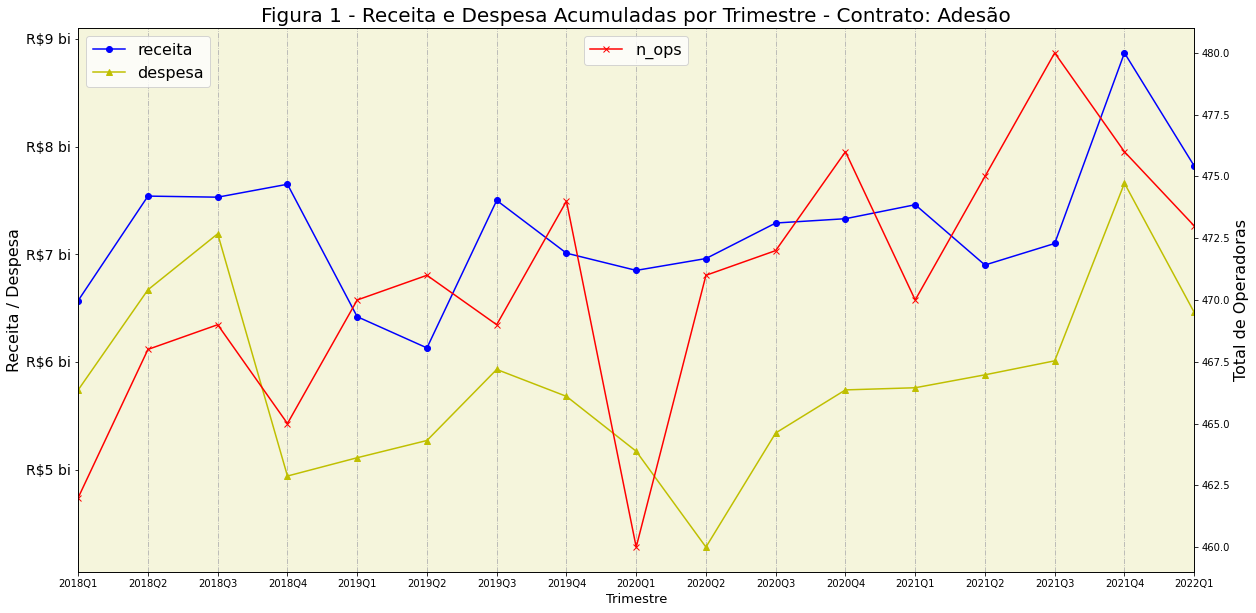

In [112]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_ade_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Adesão',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_ade_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_ade_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_ade_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_ade_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_ade_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [113]:
diops_tcc_trimestral_ops_cont_ade_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Adesao')] 

diops_tcc_trimestral_ops_cont_ade_top_filtrada = diops_tcc_trimestral_ops_cont_ade_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_ade_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ade_top_filtrada = diops_tcc_trimestral_ops_cont_ade_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ade_top_filtrada.head()

ano trimestre  cd_ops      receita      despesa
959  2018    2018Q1  369659 17575957.000 18296973.000
958  2018    2018Q1  343269 17742724.000 12272076.000
956  2018    2018Q1  371106 17780471.000 12604148.000
953  2018    2018Q1  417530 18111003.000 14113346.000
949  2018    2018Q1  339679 18671332.000 22645512.000

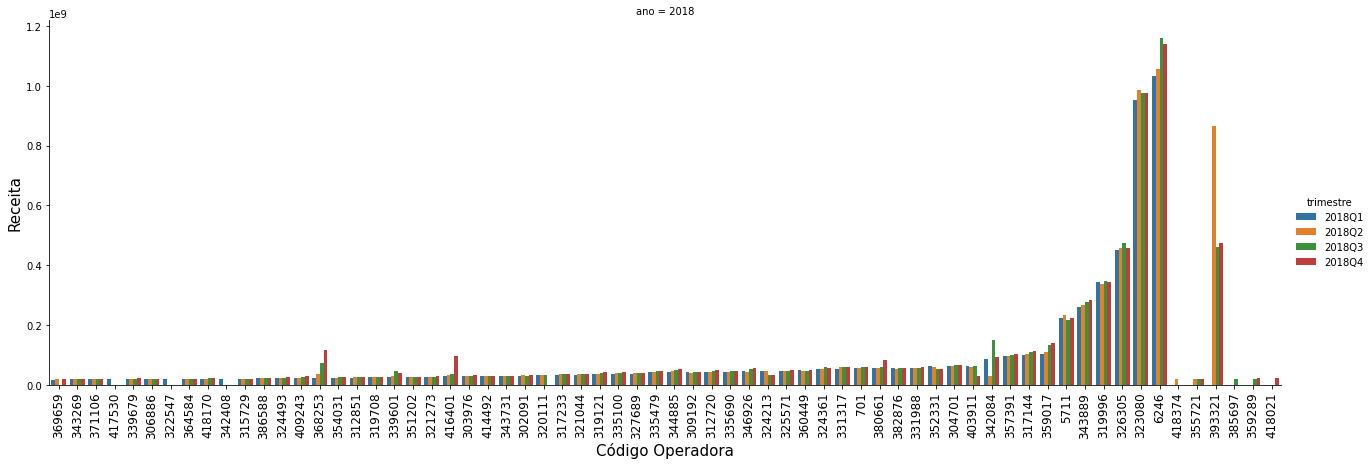

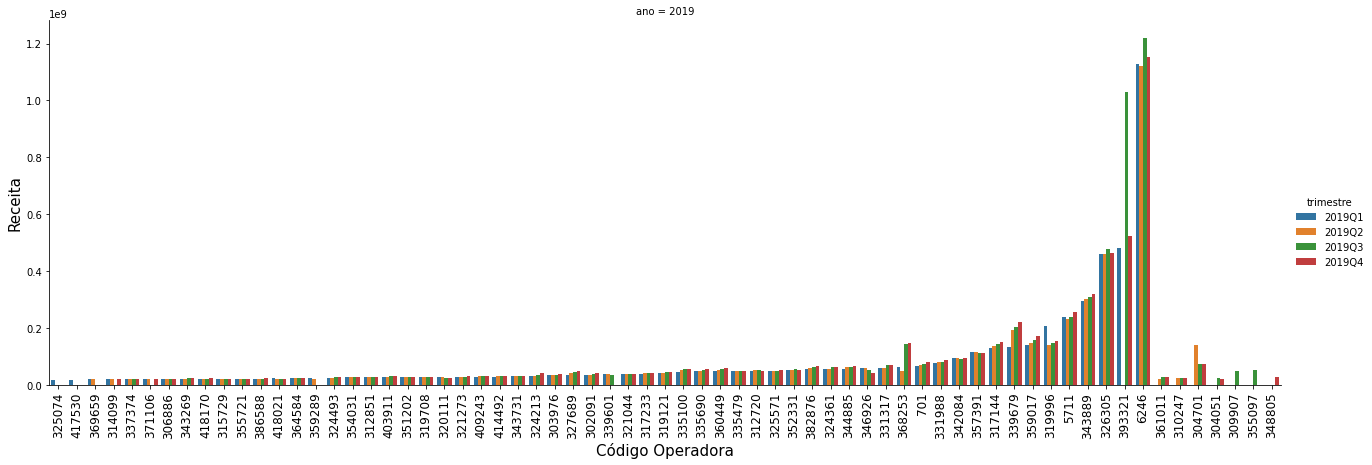

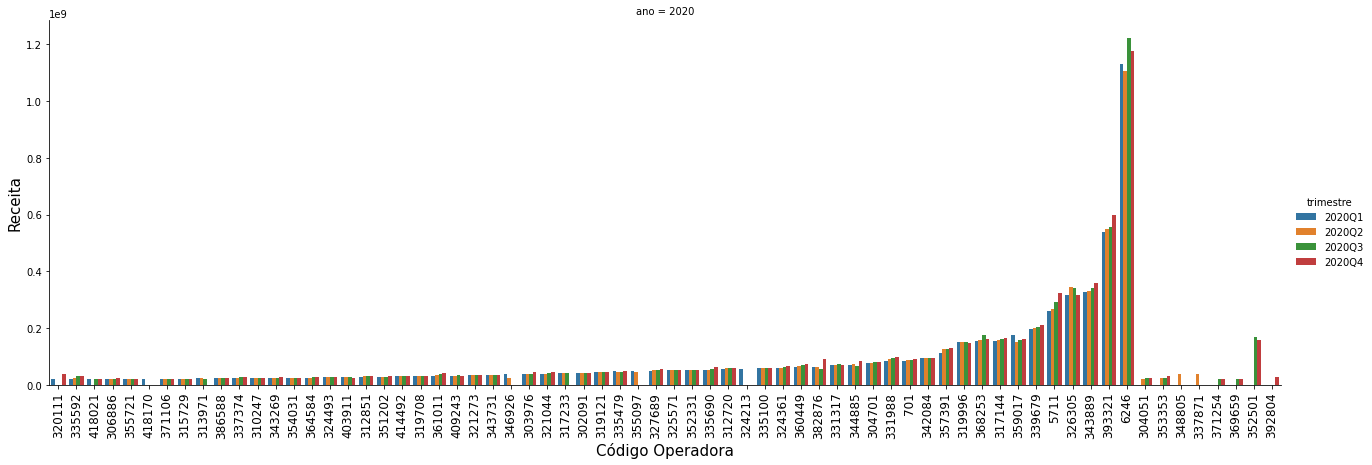

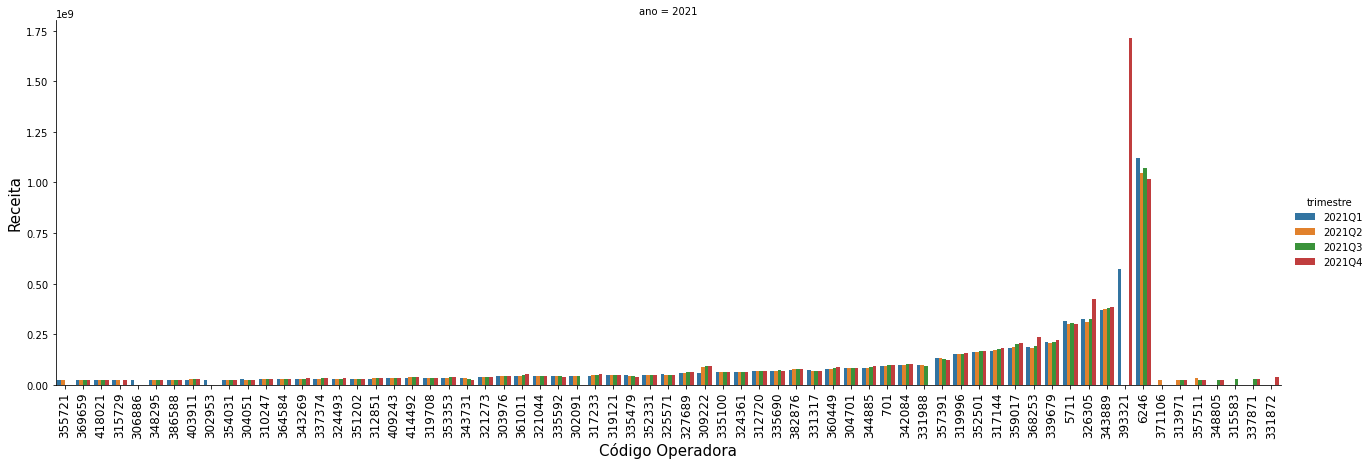

In [114]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

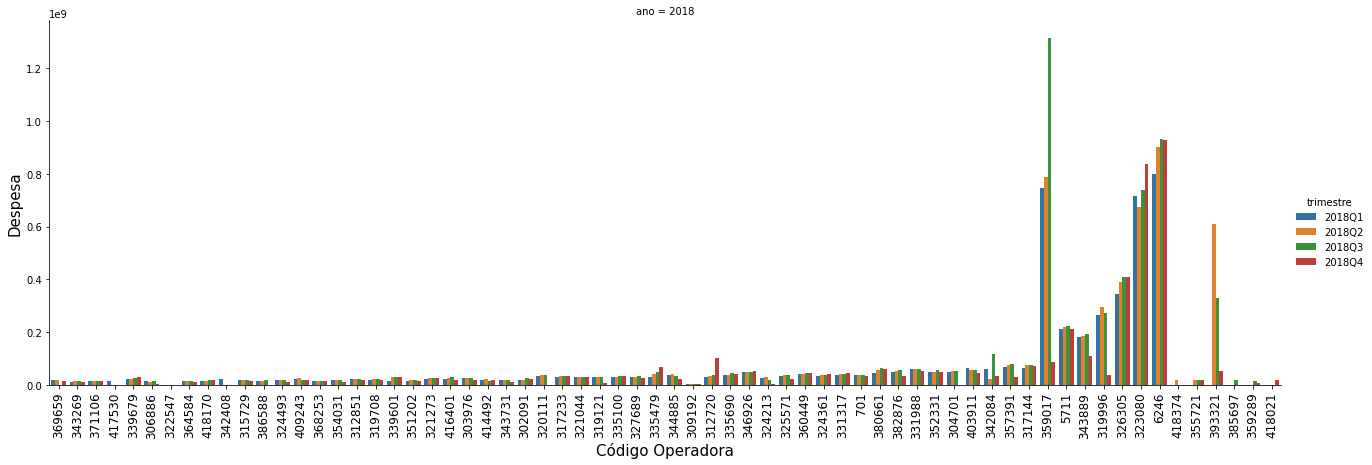

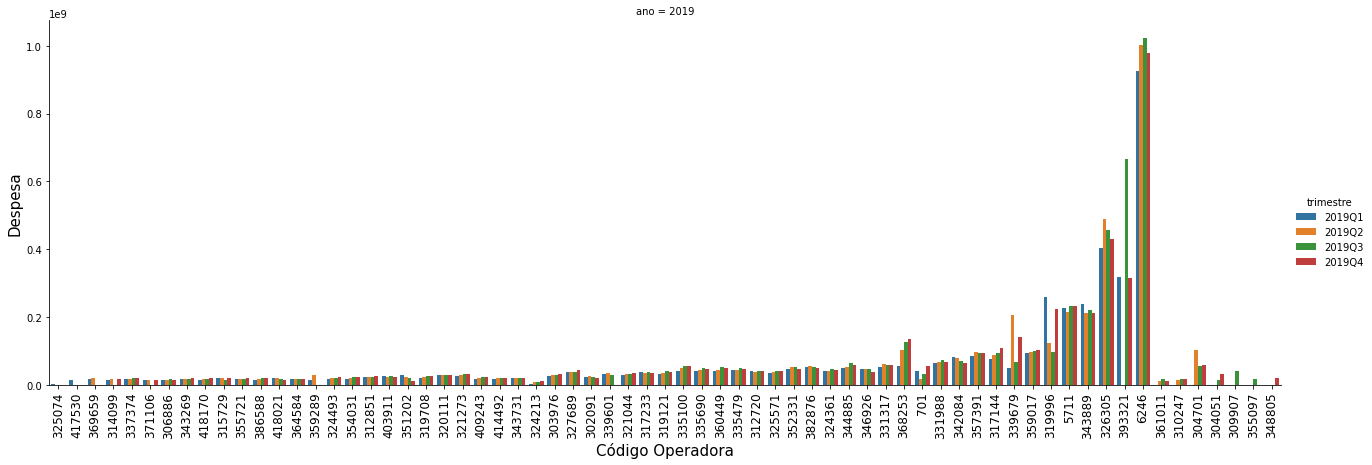

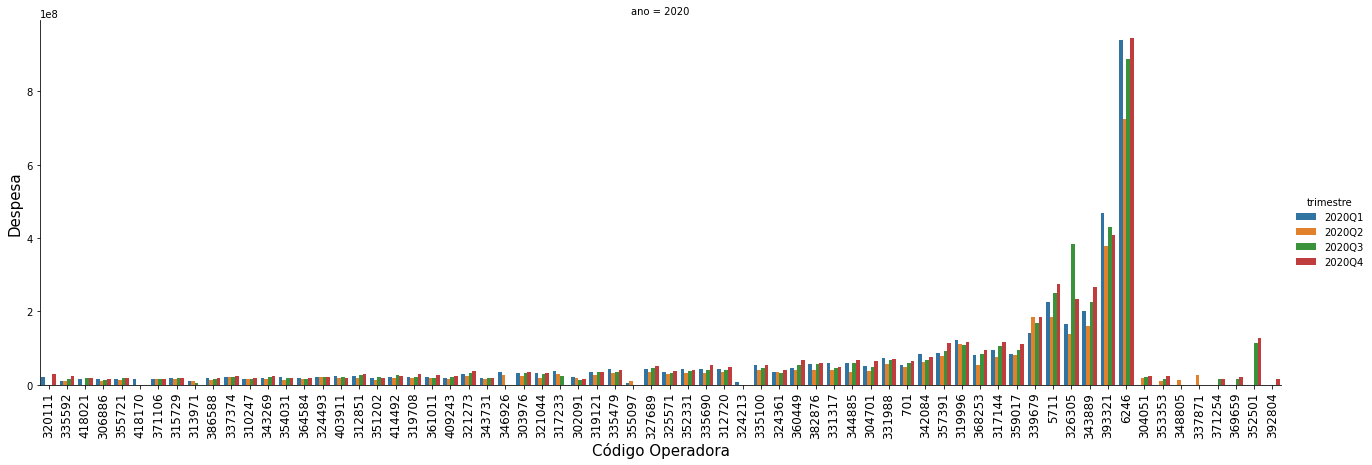

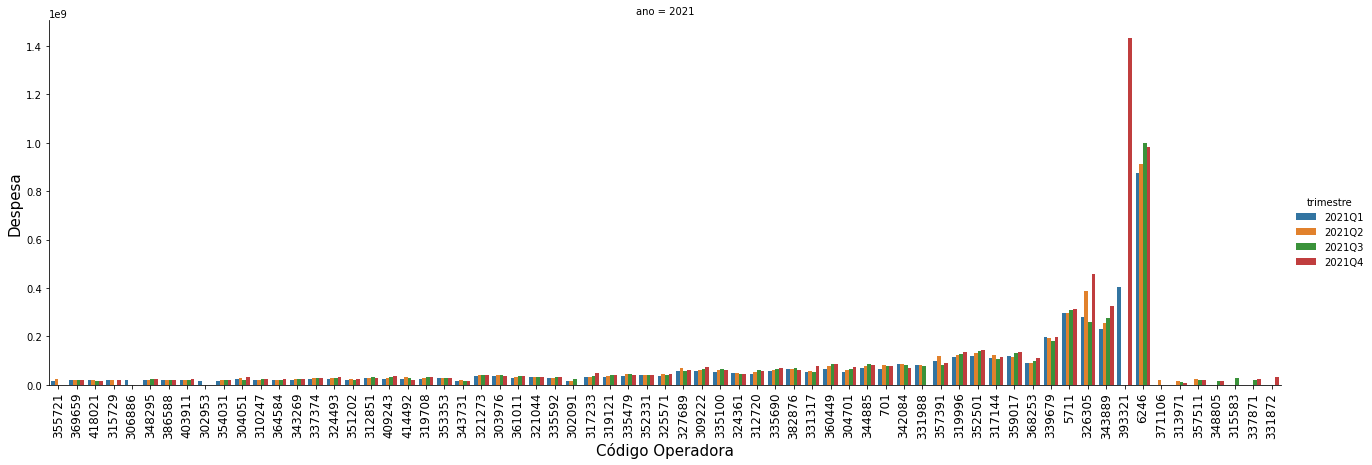

In [115]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial

In [116]:
diops_tcc_trimestral_cont_emp_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Empresarial')]
diops_tcc_trimestral_cont_emp_filtrada 

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                   
2018Q1     Empresarial   22.970   16.740    572       72.880
2018Q2     Empresarial   24.120   18.900    576       78.360
2018Q3     Empresarial   24.650   21.220    579       86.090
2018Q4     Empresarial   25.410   18.460    574       72.650
2019Q1     Empresarial   26.420   20.060    574       75.930
2019Q2     Empresarial   27.010   22.050    574       81.640
2019Q3     Empresarial   28.000   23.040    572       82.290
2019Q4     Empresarial   28.760   22.930    573       79.730
2020Q1     Empresarial   28.670   21.860    558       76.250
2020Q2     Empresarial   29.080   17.660    561       60.730
2020Q3     Empresarial   29.050   21.270    555       73.220
2020Q4     Empresarial   29.830   23.980    561       80.390
2021Q1     Empresarial   30.280   23.810    551       78.630
2021Q2     Empresarial   30.410   25.980    558       85.430
2021Q3     Empresarial   31.160   26.740    557       85.820
2021Q4     Empresarial   33.380   27.510    555       82.410
2022Q1     Empresarial   33.090   26.680    557       80.630

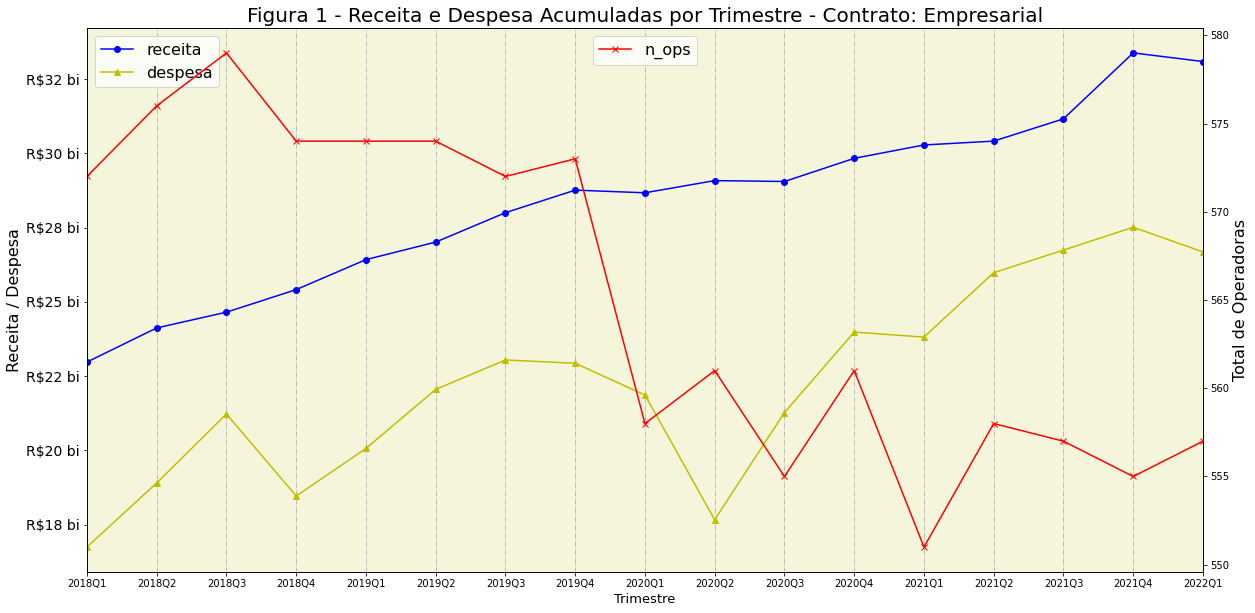

In [117]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_emp_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Empresarial',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_emp_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_emp_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_emp_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_emp_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_emp_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [118]:
diops_tcc_trimestral_ops_cont_emp_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Empresarial')] 

diops_tcc_trimestral_ops_cont_emp_top_filtrada = diops_tcc_trimestral_ops_cont_emp_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_emp_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_emp_top_filtrada = diops_tcc_trimestral_ops_cont_emp_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_emp_top_filtrada.head()

ano trimestre  cd_ops      receita      despesa
959  2018    2018Q1  340782 42244893.000 31144642.000
958  2018    2018Q1  333051 42857561.000 38862715.000
956  2018    2018Q1  320706 43527127.000 31429116.000
954  2018    2018Q1  355691 45838467.000 33159627.000
953  2018    2018Q1  335592 45912050.000 24473188.000

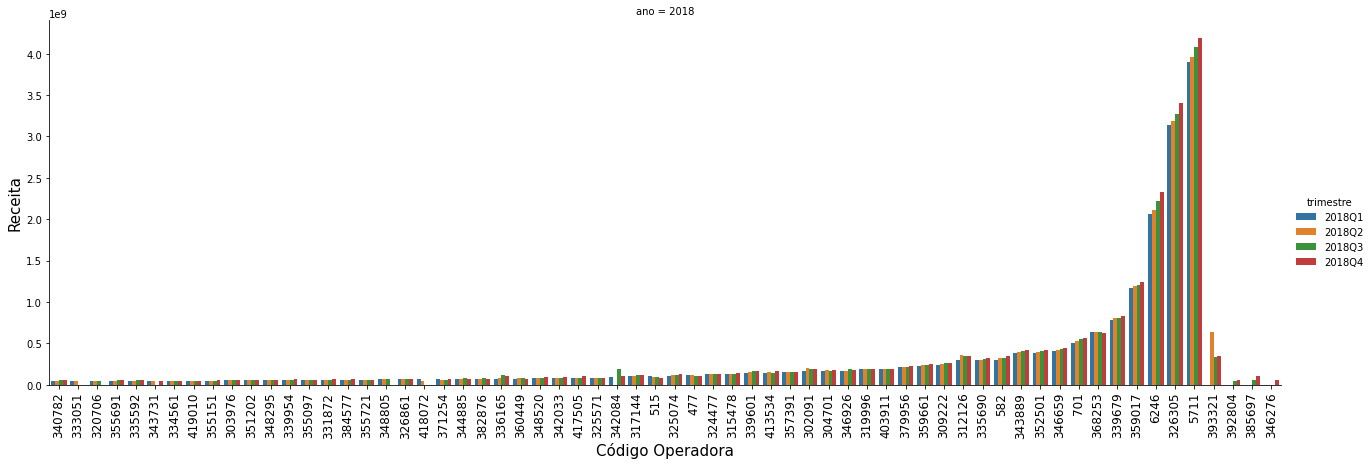

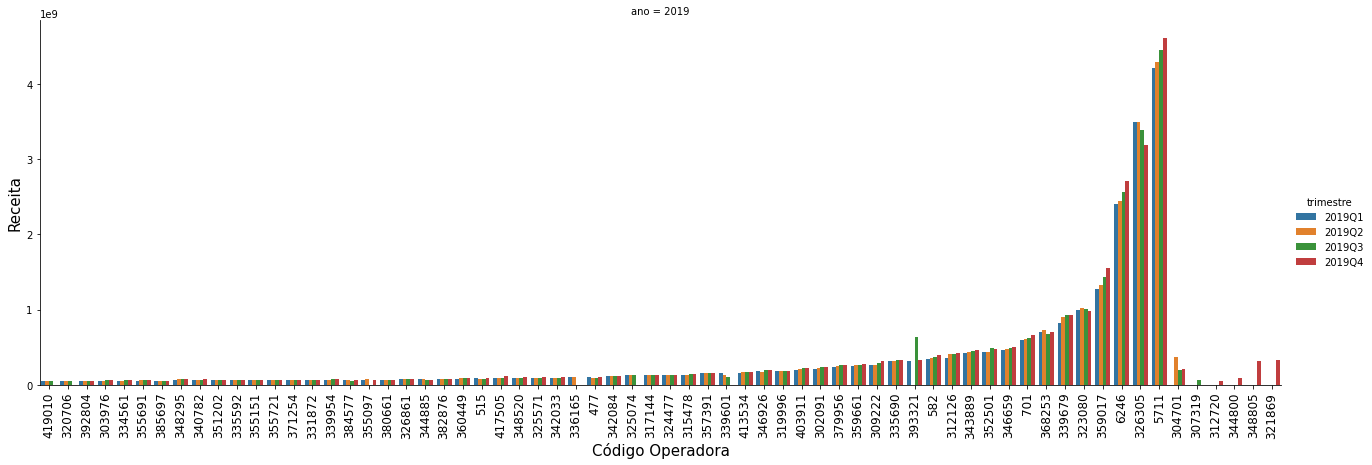

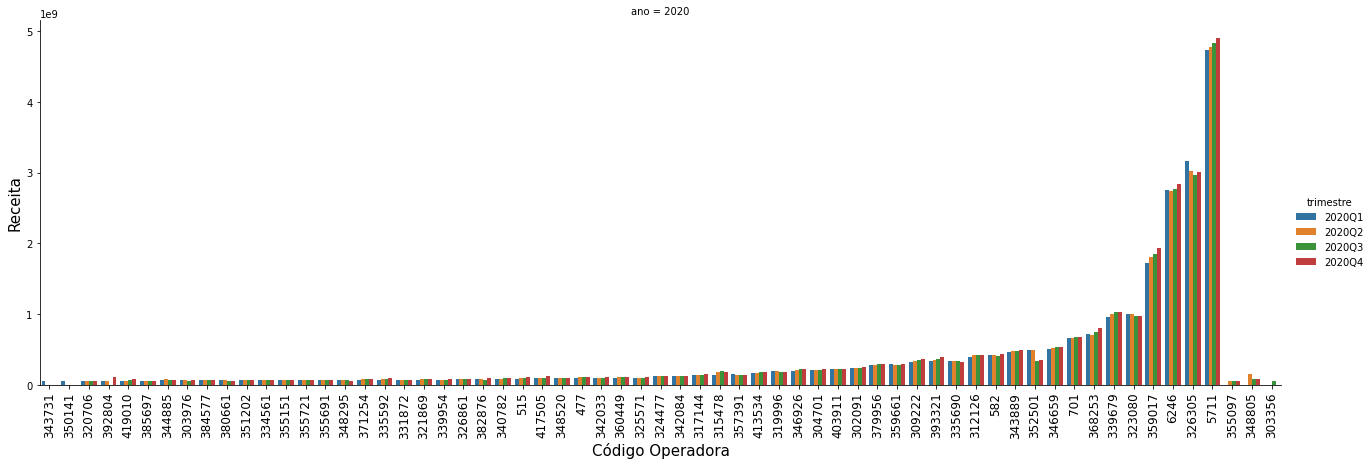

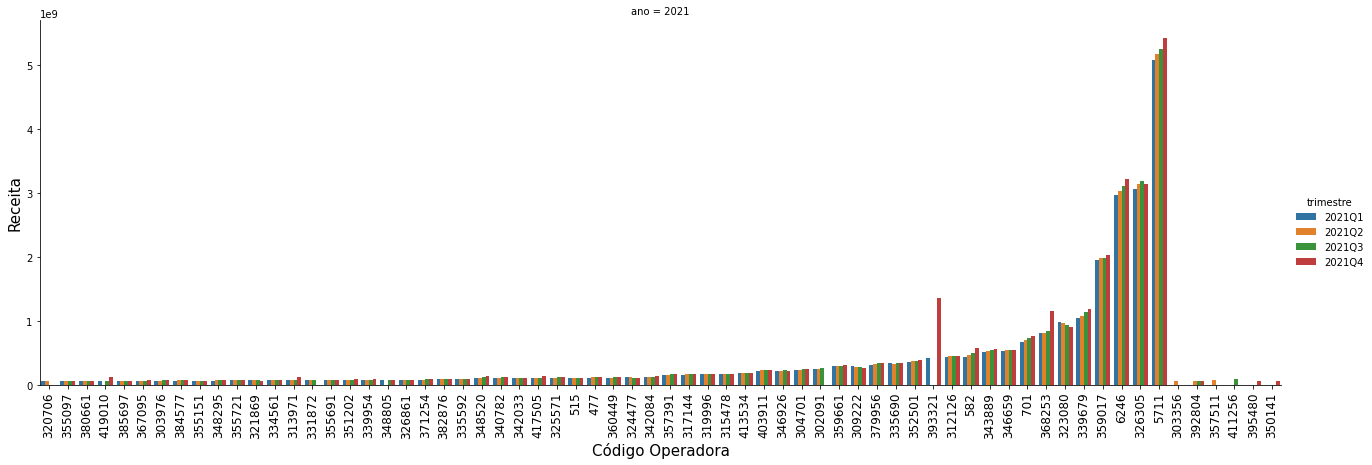

In [119]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

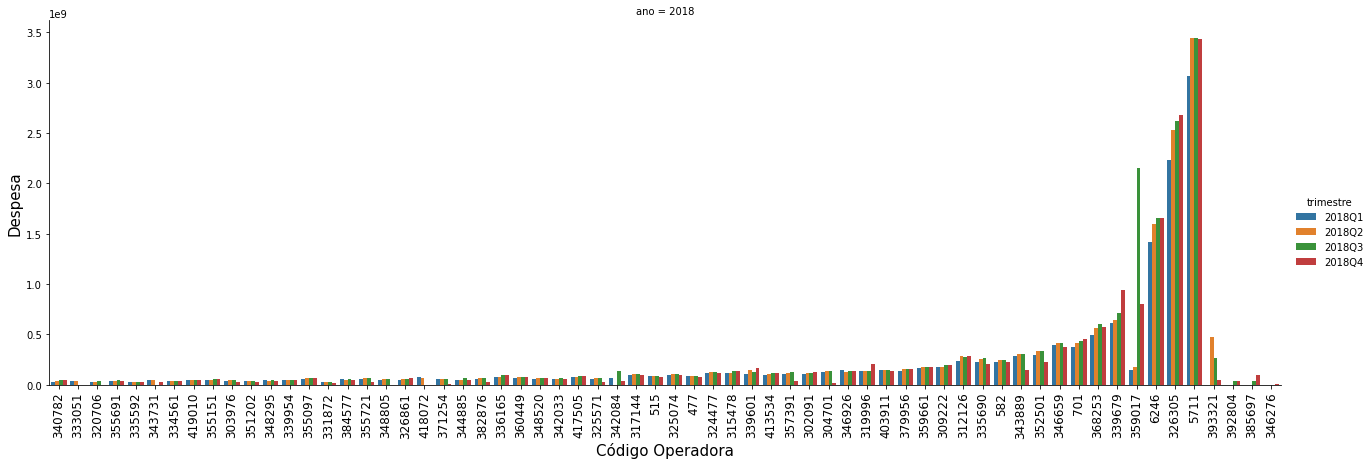

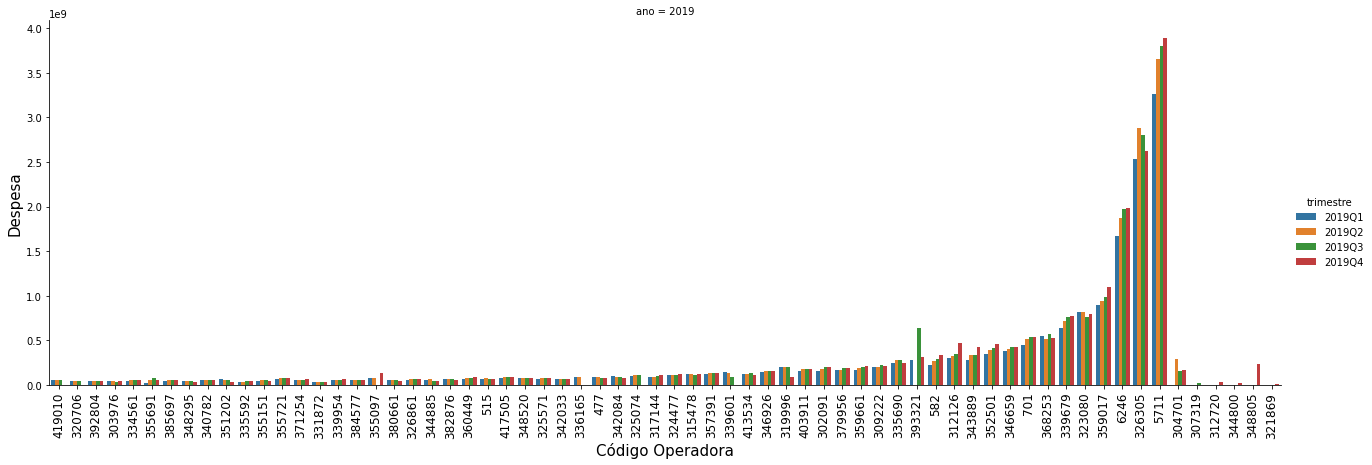

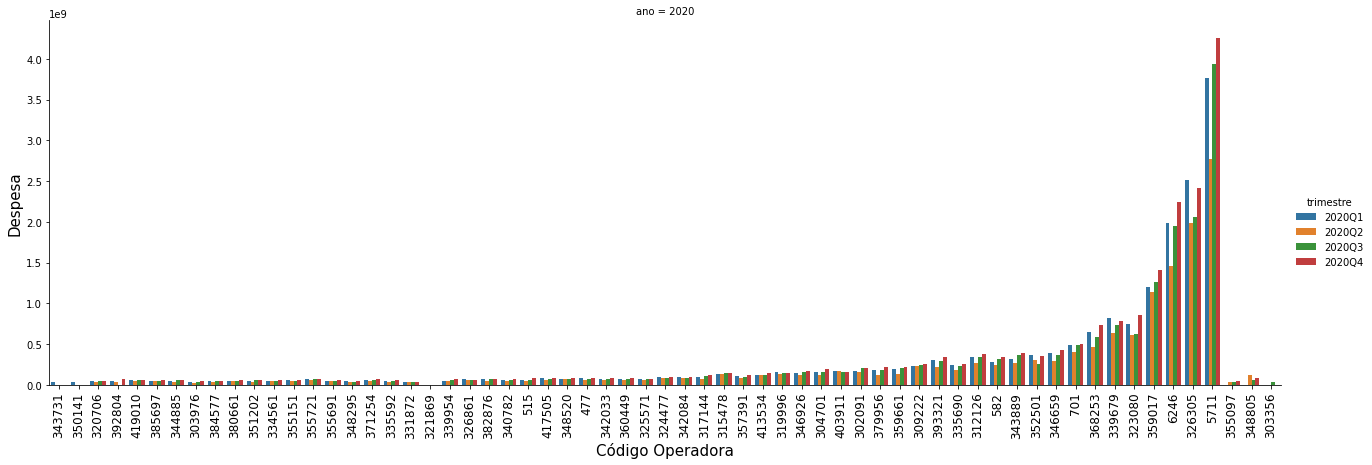

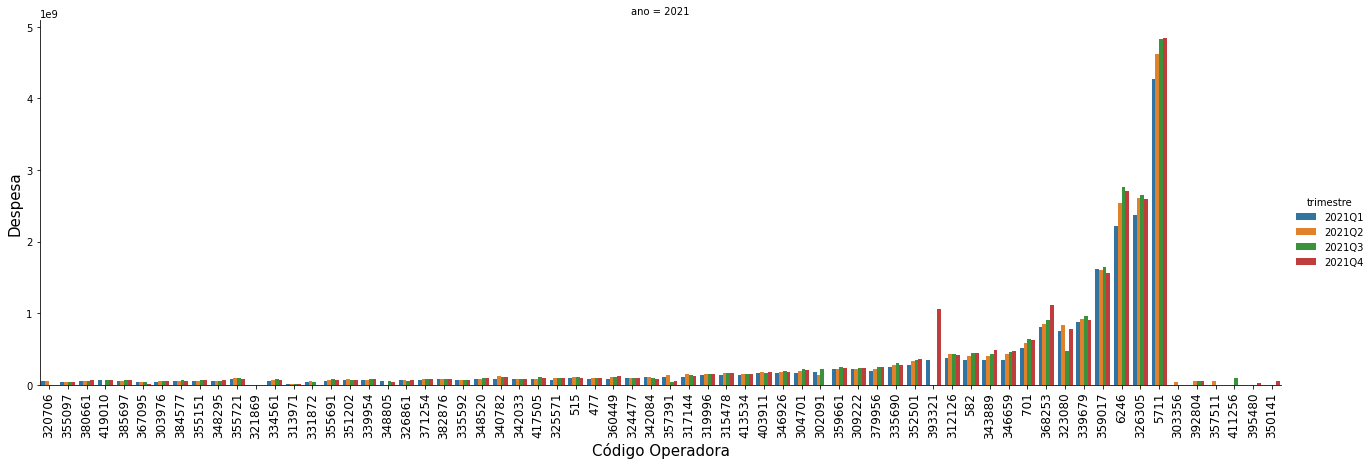

In [120]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Individual

In [121]:
diops_tcc_trimestral_cont_ind_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Individual')]
diops_tcc_trimestral_cont_ind_filtrada 

contratacao  receita  despesa  n_ops  pct_despesa
trimestre                                                  
2018Q1     Individual    8.960    6.210    522       69.310
2018Q2     Individual   10.170    7.590    526       74.630
2018Q3     Individual    9.980    7.610    530       76.250
2018Q4     Individual   10.310    6.320    519       61.300
2019Q1     Individual   10.030    7.150    508       71.290
2019Q2     Individual   10.150    7.760    509       76.450
2019Q3     Individual   10.990    8.740    514       79.530
2019Q4     Individual   11.160    8.180    510       73.300
2020Q1     Individual   11.110    7.440    501       66.970
2020Q2     Individual   11.050    6.450    506       58.370
2020Q3     Individual   11.310    7.390    495       65.340
2020Q4     Individual   11.930    8.210    502       68.820
2021Q1     Individual   11.910    8.120    495       68.180
2021Q2     Individual   11.650    8.400    501       72.100
2021Q3     Individual   11.440    8.840    498       77.270
2021Q4     Individual   12.760   10.280    494       80.560
2022Q1     Individual   11.420    9.320    488       81.610

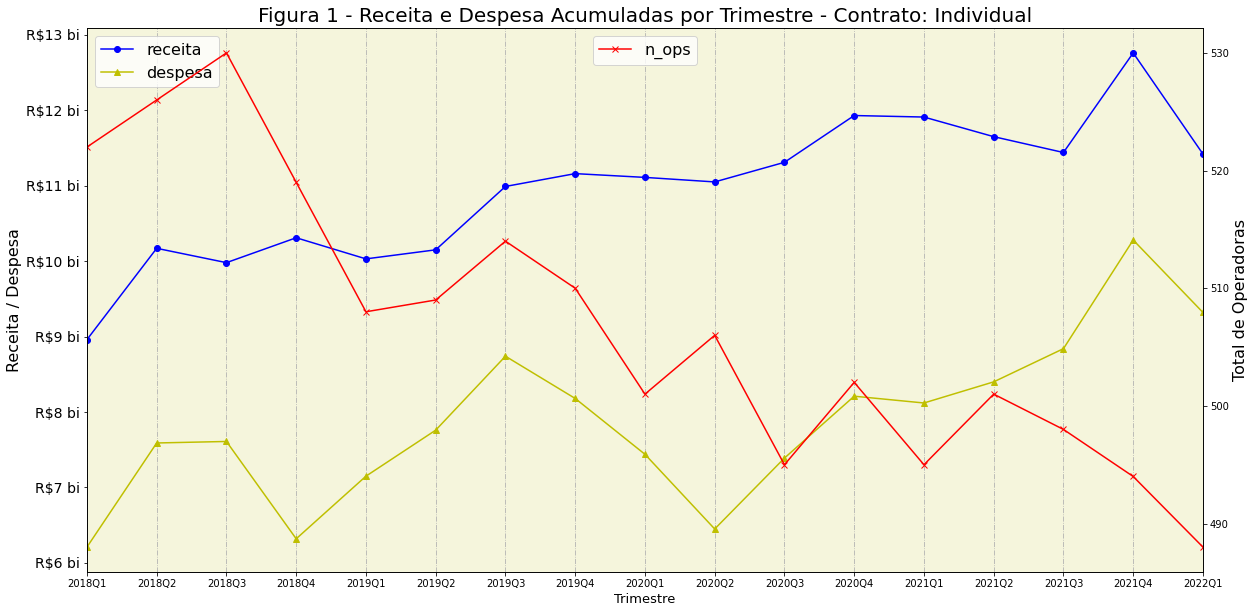

In [122]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_ind_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Individual',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_ind_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_ind_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_ind_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_ind_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_ind_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()


In [123]:
diops_tcc_trimestral_ops_cont_ind_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Individual')] 

diops_tcc_trimestral_ops_cont_ind_top_filtrada = diops_tcc_trimestral_ops_cont_ind_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_ind_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ind_top_filtrada = diops_tcc_trimestral_ops_cont_ind_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ind_top_filtrada.head()

ano trimestre  cd_ops      receita      despesa
959  2018    2018Q1  359017 28689654.000 22628018.000
958  2018    2018Q1  354511 28729315.000 23183620.000
957  2018    2018Q1  306886 28888616.000 20997391.000
956  2018    2018Q1  360481 28913802.000 23973315.000
953  2018    2018Q1  344362 29285773.000 20057000.000

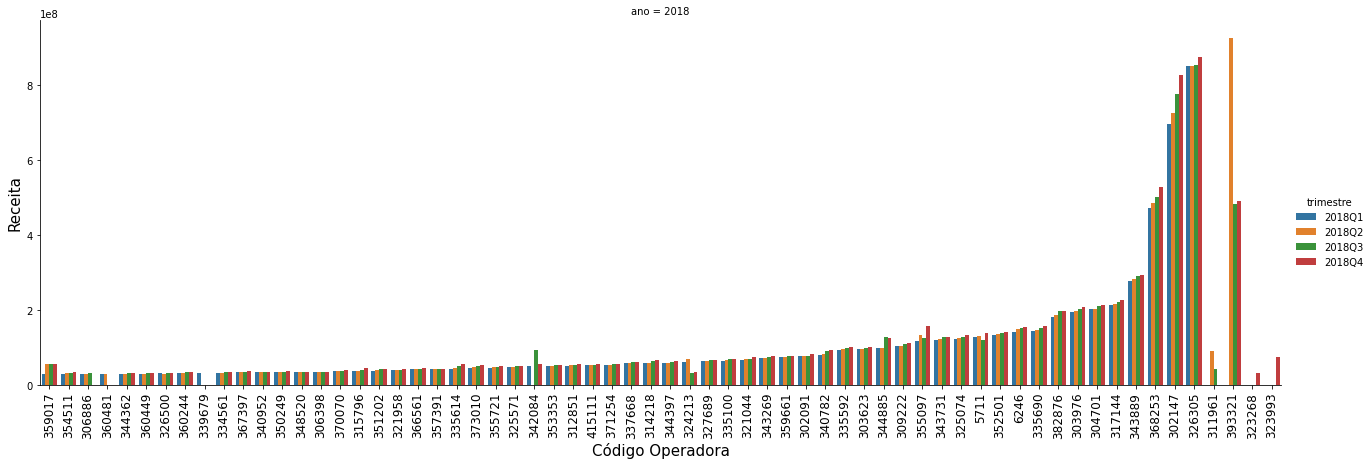

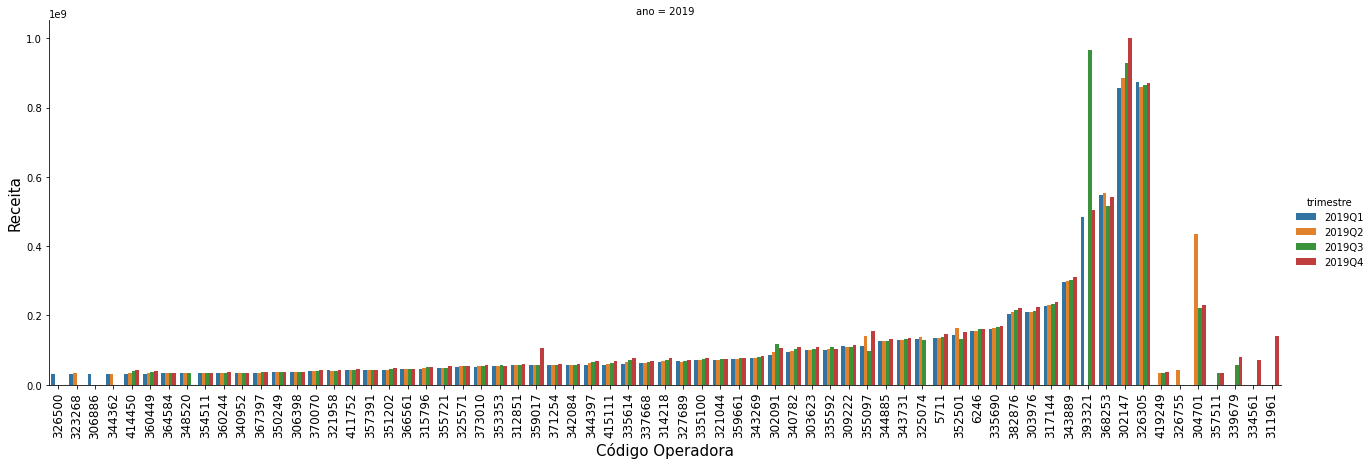

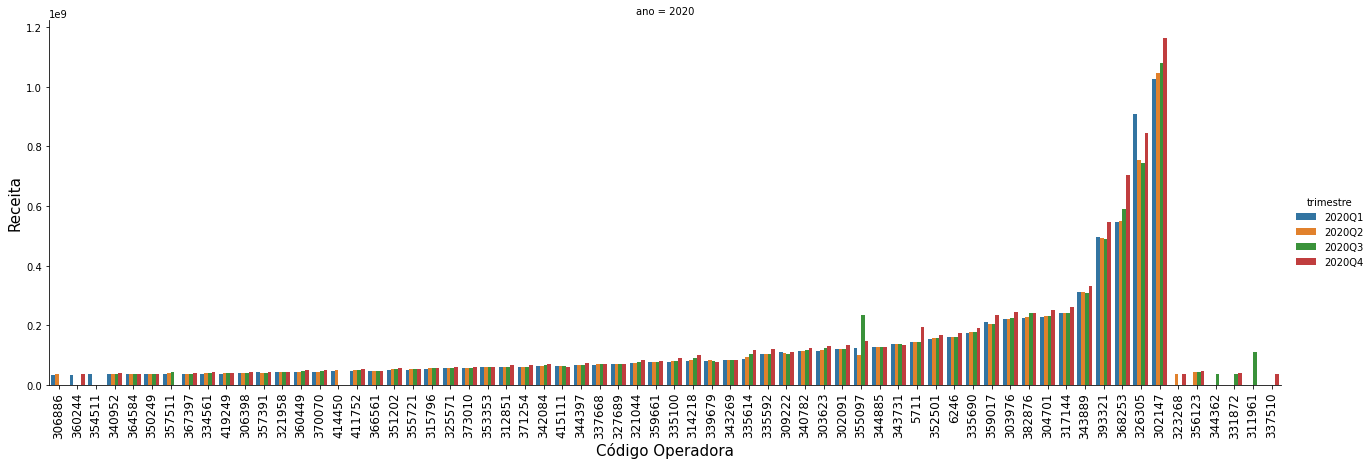

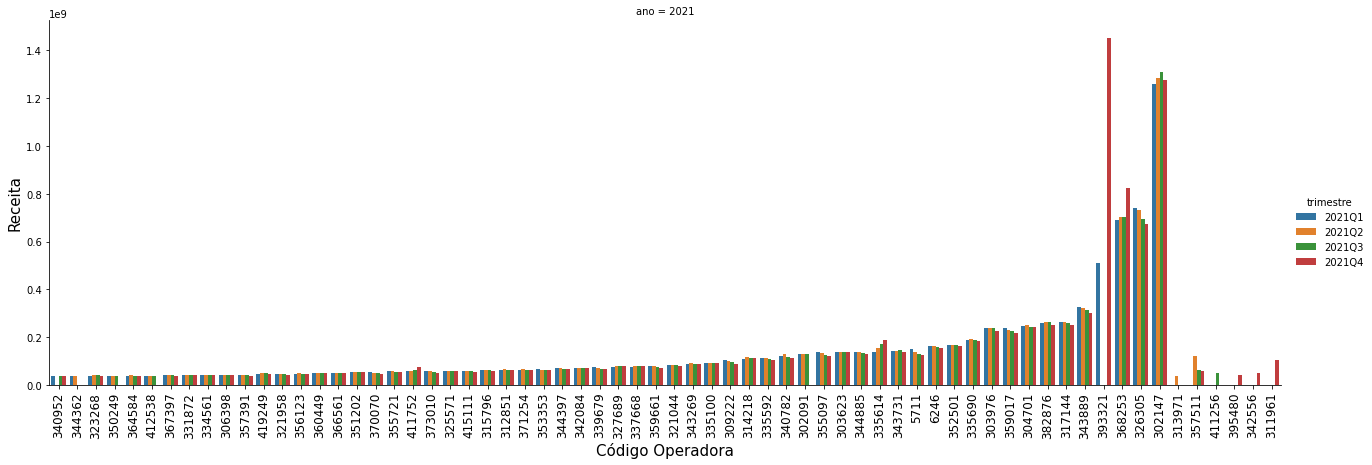

In [124]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

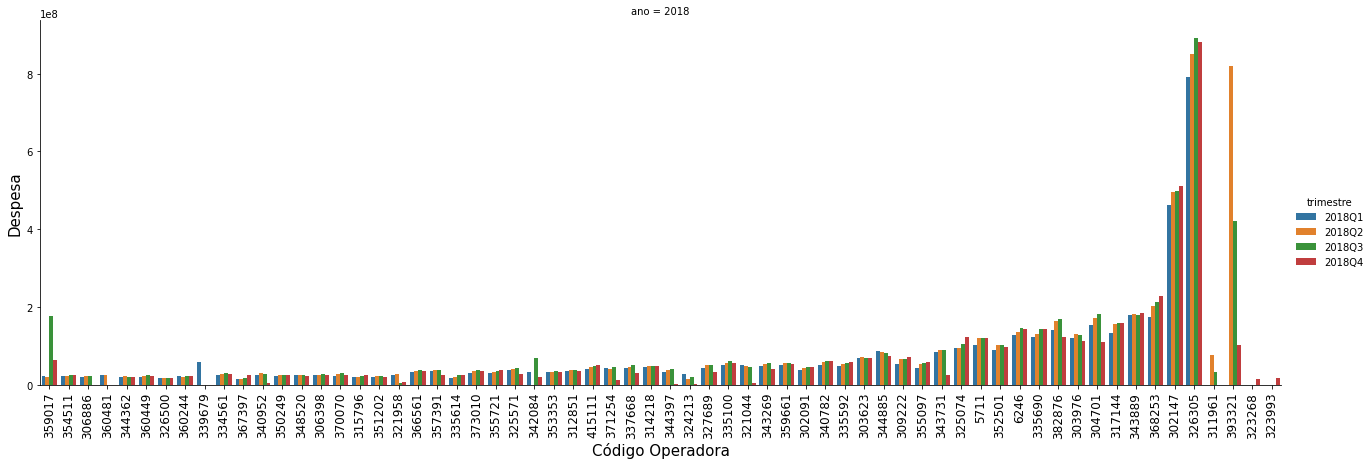

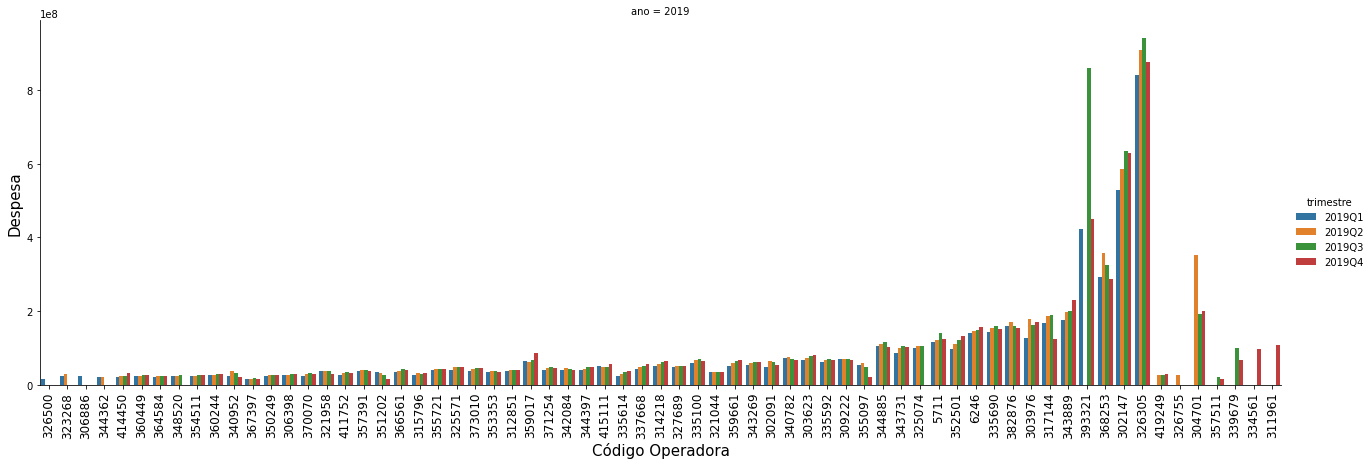

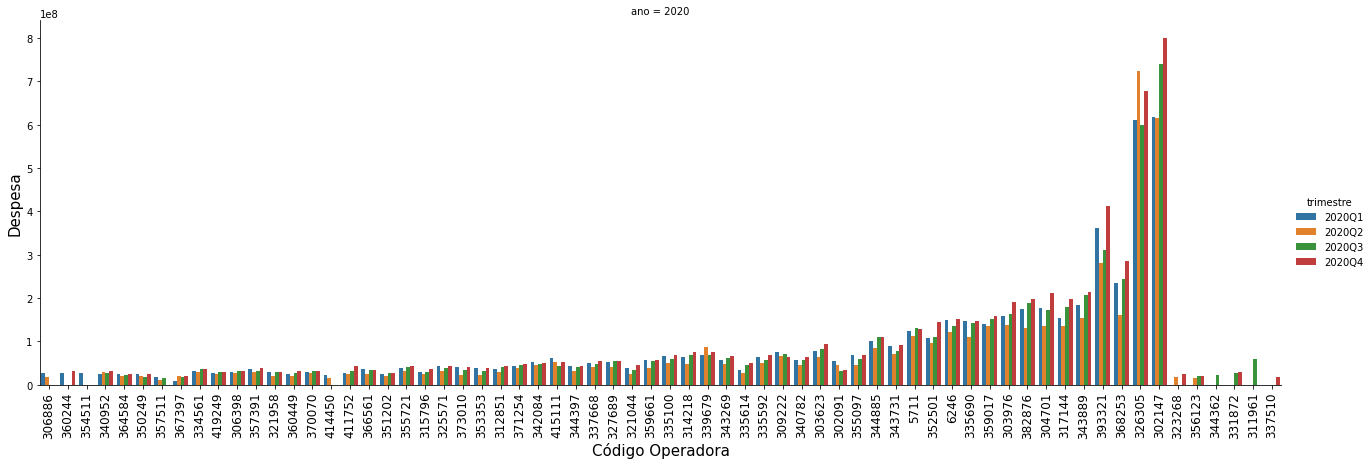

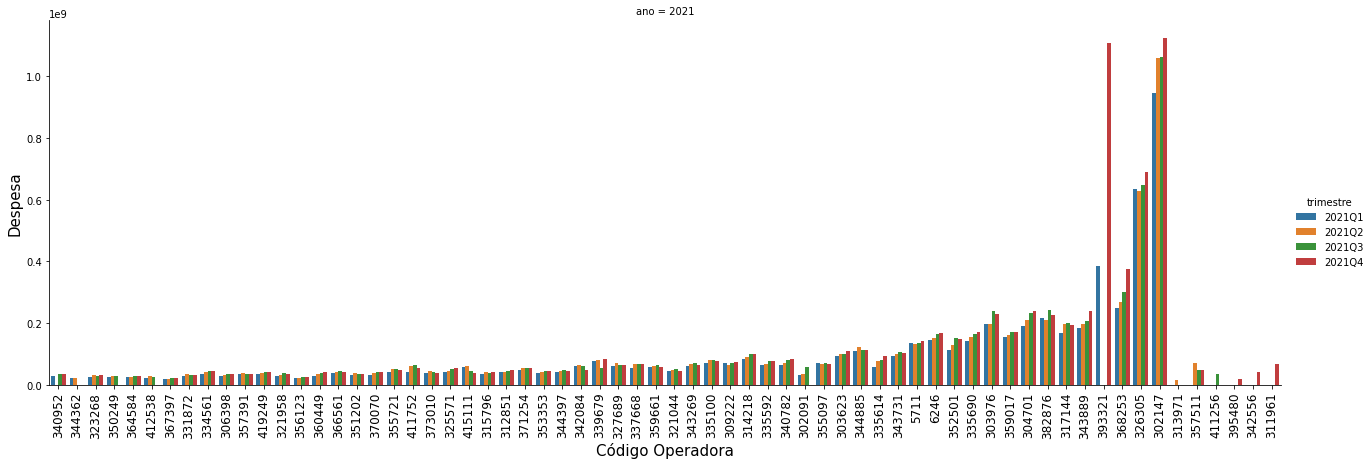

In [125]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

# VDA

In [126]:
def df_trim(df, column, whisker_width = 1.5):
    #Calulos dos quantis
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

df_VDA_analise_trim = df_trim(df_VDA,'dpb')

df_VDA_analise_trim.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '21-vda_analise_trim.csv', sep=';',  index=False, encoding='mbcs', decimal=',')

NameError: name 'df_VDA' is not defined

In [ ]:
#####################################################################################################################################################################################
# VDA - TCC
######################################################################################################################################################################################

df_VDA_tcc = diops_tcc_filtrada.copy() 

df_VDA_tcc

In [ ]:
df_VDA_tcc = pd.merge(df_VDA_tcc, sib_filtrada, how='inner', on=['cd_ops', 'contratacao', 'id_calendar', 'trimestre'])

df_VDA_tcc = pd.merge(df_VDA_tcc, cadop, how='inner', on='cd_ops')

df_VDA_tcc.drop(['ano_y', 'razao_social'], axis='columns', inplace=True)

df_VDA_tcc.rename(columns = {'ano_x':'ano'}, inplace = True)

df_VDA_tcc = df_VDA_tcc.loc[(df_VDA_tcc['lg_cancelada']==0) & (df_VDA_tcc['lg_nova_ops']==0) & (df_VDA_tcc['despesa']>0) & (df_VDA_tcc['n_meses']==3)]

df_VDA_tcc = df_VDA_tcc[['cd_ops', 'modalidade', 'port_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa', 'benefm']]

df_VDA_tcc.sort_values(by=['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre'])

#Duvida Aqui
df_VDA_tcc['dpb'] = np.where(df_VDA_tcc['benefm'] >= 0, df_VDA_tcc['despesa']/df_VDA_tcc['benefm'], 'NaN')

df_VDA_tcc['dpb'] = pd.to_numeric(df_VDA_tcc['dpb'], errors='coerce')

#print("")
#print("VDA TCC")
#print(df_VDA_tcc)

df_VDA_tcc.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '22-vda_tcc.csv',  index=False, sep=';', encoding='mbcs', decimal=',')

df_VDA_tcc